In [4]:
#-*-coding:utf-8-*-
from __future__ import print_function, division
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.models import Sequential
import util
import utils
import tensorflow.contrib.gan as tfgan
num_images_to_eval = 500
import torch.nn as nn
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, imgs, transform=None):
        # super().__init__()
        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        img = self.imgs[index]
        if self.transform is not None:
            img = self.transform(img)
        else:
            img = torch.from_numpy(img)
        return img


import math
import os
import numpy as np
import ot
import torch
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.models as models

from scipy import linalg

from keras.datasets import mnist
import matplotlib.pyplot as plt

def giveName(iter):  # 7 digit name.
    ans = str(iter)
    return ans.zfill(7)

def make_dataset(dataset, dataroot, imageSize):
    """
    :param dataset: must be in 'cifar10 | lsun | imagenet | folder | lfw | fake'
    :return: pytorch dataset for DataLoader to utilize
    """
    if dataset in ['imagenet', 'folder', 'lfw']:
        print(os.getcwd() + dataroot)  # 函数的作用是用于返回当前工作目录
        # folder dataset
        # dataset = dset.ImageFolder(root=dataroot,
        dataset = dset.ImageFolder(root=os.getcwd() + dataroot,
                                   transform=transforms.Compose([
                                       transforms.Resize(imageSize),
                                       # transforms.CenterCrop(imageSize),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   ]))
    elif dataset == 'lsun':
        dataset = dset.LSUN(db_path=dataroot, classes=['bedroom_train'],
                            transform=transforms.Compose([
                                transforms.Resize(imageSize),
                                transforms.CenterCrop(imageSize),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ]))
    elif dataset == 'cifar10':
        dataset = dset.CIFAR10(root=dataroot, download=True,
                               transform=transforms.Compose([
                                   transforms.Resize(imageSize),
                                   transforms.ToTensor(),
                                   transforms.Normalize(
                                       (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))
    elif dataset == 'celeba':
        dataset = dset.ImageFolder(root=dataroot,
                                   transform=transforms.Compose([
                                       transforms.CenterCrop(138),
                                       transforms.Resize(imageSize),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   ]))
    else:
        raise Exception('--dataset must be in cifar10 | lsun | imagenet | folder | lfw | fake')
    assert dataset
    return dataset

MNIST_CLASSIFIER_FROZEN_GRAPH = './classify_mnist_graph_def.pb'
INPUT_TENSOR = 'inputs:0'
OUTPUT_TENSOR = 'logits:0'
# CONV_TENSOR = 'fc3/Relu:0'
CONV_TENSOR = 'fc4/BiasAdd:0'
class ConvNetFeatureSaver(object):
    def __init__(self, model='cnn', workers=4, batchSize=64):
        '''
        model: inception_v3, vgg13, vgg16, vgg19, resnet18, resnet34,
               resnet50, resnet101, or resnet152
        '''
        self.model = model
        self.batch_size = batchSize
        self.workers = workers
        if self.model.find('tfgan') >= 0:
            print('tfgan')

        elif self.model.find('vgg') >= 0:
            self.vgg = getattr(models, model)(pretrained=True).cuda().eval()
            self.trans = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),
                                     (0.229, 0.224, 0.225)),
            ])
        elif self.model.find('resnet') >= 0:
            resnet = getattr(models, model)(pretrained=True)
            resnet.cuda().eval()
            resnet_feature = nn.Sequential(resnet.conv1, resnet.bn1,
                                           resnet.relu,
                                           resnet.maxpool, resnet.layer1,
                                           resnet.layer2, resnet.layer3,
                                           resnet.layer4).cuda().eval()
            self.resnet = resnet
            self.resnet_feature = resnet_feature
            self.trans = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),
                                     (0.229, 0.224, 0.225)),
            ])
        elif self.model == 'inception' or self.model == 'inception_v3':
            inception = models.inception_v3(
                pretrained=True, transform_input=False).cuda().eval()
            inception_feature = nn.Sequential(inception.Conv2d_1a_3x3,
                                              inception.Conv2d_2a_3x3,
                                              inception.Conv2d_2b_3x3,
                                              nn.MaxPool2d(3, 2),
                                              inception.Conv2d_3b_1x1,
                                              inception.Conv2d_4a_3x3,
                                              nn.MaxPool2d(3, 2),
                                              inception.Mixed_5b,
                                              inception.Mixed_5c,
                                              inception.Mixed_5d,
                                              inception.Mixed_6a,
                                              inception.Mixed_6b,
                                              inception.Mixed_6c,
                                              inception.Mixed_6d,
                                              inception.Mixed_7a,
                                              inception.Mixed_7b,
                                              inception.Mixed_7c,
                                              ).cuda().eval()
            self.inception = inception
            self.inception_feature = inception_feature
            self.trans = transforms.Compose([
                transforms.Resize(299),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
        else:
            raise NotImplementedError

    def save(self, imgFolder, dataloader, save2disk=False):
        feature_pixl, feature_conv, feature_smax, feature_logit = [], [], [], []

        for img in dataloader:
            with torch.no_grad():
                input = img.cuda()
                if self.model == 'tfgan':
                    gen_imgs = np.array(img)
                    eval_images = tf.convert_to_tensor(gen_imgs)
                    flogit = util.mnist_logits(eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH, INPUT_TENSOR, OUTPUT_TENSOR)
                    fconv = util.mnist_logits(eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH, INPUT_TENSOR, CONV_TENSOR)
                    flogit,fconv=tf.Session().run([flogit,fconv])

                    flogit=torch.from_numpy(flogit)
                    fconv=torch.from_numpy(fconv)
                elif self.model == 'vgg' or self.model == 'vgg16':
                    print(self.vgg.features(input).shape)
                    fconv = self.vgg.features(input).view(input.size(0), -1)  # 相当于reshape
                    flogit = self.vgg.classifier(fconv)
                    # flogit = self.vgg.logitifier(fconv)
                elif self.model.find('resnet') >= 0:
                    fconv = self.resnet_feature(
                        input).mean(3).mean(2).squeeze()
                    flogit = self.resnet.fc(fconv)
                elif self.model == 'inception' or self.model == 'inception_v3':
                    fconv = self.inception_feature(
                        input).mean(3).mean(2).squeeze()
                    flogit = self.inception.fc(fconv)
                else:
                    raise NotImplementedError
                fsmax = F.softmax(flogit)
                '''
                总共有四个空间：1.feature_pixl 2.feature_conv 3.feature_logit 4.feature_smax
                '''
                feature_pixl.append(img)
                feature_conv.append(fconv.data.cpu())
                feature_logit.append(flogit.data.cpu())
                feature_smax.append(fsmax.data.cpu())

        feature_pixl = torch.cat(feature_pixl, 0).to('cpu')
        feature_conv = torch.cat(feature_conv, 0).to('cpu')
        feature_logit = torch.cat(feature_logit, 0).to('cpu')
        feature_smax = torch.cat(feature_smax, 0).to('cpu')

        return feature_pixl, feature_conv, feature_logit, feature_smax

    # return feature_pixl, feature_conv, feature_logit, feature_smax


def distance(X, Y, sqrt):
    nX = X.size(0)
    nY = Y.size(0)
    X = X.view(nX, -1)
    X2 = (X * X).sum(1).resize_(nX, 1)
    Y = Y.view(nY, -1)
    Y2 = (Y * Y).sum(1).resize_(nY, 1)

    M = torch.zeros(nX, nY)
    M.copy_(X2.expand(nX, nY) + Y2.expand(nY, nX).transpose(0, 1) -
            2 * torch.mm(X, Y.transpose(0, 1)))

    del X, X2, Y, Y2

    if sqrt:
        M = ((M + M.abs()) / 2).sqrt()

    return M


def wasserstein(M, sqrt):
    if sqrt:
        M = M.abs().sqrt()
    emd = ot.emd2([], [], M.numpy())

    return emd


class Score_knn:
    acc = 0
    acc_real = 0
    acc_fake = 0
    precision = 0
    recall = 0
    tp = 0
    fp = 0
    fn = 0
    ft = 0


def knn(Mxx, Mxy, Myy, k, sqrt):
    n0 = Mxx.size(0)
    n1 = Myy.size(0)
    label = torch.cat((torch.ones(n0), torch.zeros(n1)))
    M = torch.cat((torch.cat((Mxx, Mxy), 1), torch.cat(
        (Mxy.transpose(0, 1), Myy), 1)), 0)
    if sqrt:
        M = M.abs().sqrt()
    INFINITY = float('inf')
    val, idx = (M + torch.diag(INFINITY * torch.ones(n0 + n1))
                ).topk(k, 0, False)

    count = torch.zeros(n0 + n1)
    for i in range(0, k):
        count = count + label.index_select(0, idx[i])
    pred = torch.ge(count, (float(k) / 2) * torch.ones(n0 + n1)).float()

    s = Score_knn()
    s.tp = (pred * label).sum()
    s.fp = (pred * (1 - label)).sum()
    s.fn = ((1 - pred) * label).sum()
    s.tn = ((1 - pred) * (1 - label)).sum()
    s.precision = s.tp / (s.tp + s.fp + 1e-10)
    s.recall = s.tp / (s.tp + s.fn + 1e-10)
    s.acc_t = s.tp / (s.tp + s.fn)
    s.acc_f = s.tn / (s.tn + s.fp)
    s.acc = torch.eq(label, pred).float().mean()
    s.k = k

    return s


def mmd(Mxx, Mxy, Myy, sigma):
    scale = Mxx.mean()
    Mxx = torch.exp(-Mxx / (scale * 2 * sigma * sigma))
    Mxy = torch.exp(-Mxy / (scale * 2 * sigma * sigma))
    Myy = torch.exp(-Myy / (scale * 2 * sigma * sigma))
    mmd = math.sqrt(Mxx.mean() + Myy.mean() - 2 * Mxy.mean())

    return mmd


def entropy_score(X, Y, epsilons):
    Mxy = distance(X, Y, False)
    scores = []
    for epsilon in epsilons:
        scores.append(ent(Mxy.t(), epsilon))

    return scores


def ent(M, epsilon):
    n0 = M.size(0)
    n1 = M.size(1)
    neighbors = M.lt(epsilon).float()
    sums = neighbors.sum(0).repeat(n0, 1)
    sums[sums.eq(0)] = 1
    neighbors = neighbors.div(sums)
    probs = neighbors.sum(1) / n1
    rem = 1 - probs.sum()
    if rem < 0:
        rem = 0
    probs = torch.cat((probs, rem * torch.ones(1)), 0)
    e = {}
    e['probs'] = probs
    probs = probs[probs.gt(0)]
    e['ent'] = -probs.mul(probs.log()).sum()

    return e


eps = 1e-20


def inception_score(X):
    kl = X * ((X + eps).log() - (X.mean(0) + eps).log().expand_as(X))
    score = np.exp(kl.sum(1).mean())

    return score


def mode_score(X, Y):
    kl1 = X * ((X + eps).log() - (X.mean(0) + eps).log().expand_as(X))
    kl2 = X.mean(0) * ((X.mean(0) + eps).log() - (Y.mean(0) + eps).log())
    score = np.exp(kl1.sum(1).mean() - kl2.sum())

    return score


def fid(X, Y):
    m = X.mean(0)
    m_w = Y.mean(0)
    X_np = X.numpy()
    Y_np = Y.numpy()

    C = np.cov(X_np.transpose())
    C_w = np.cov(Y_np.transpose())
    C_C_w_sqrt = linalg.sqrtm(C.dot(C_w), True).real

    score = m.dot(m) + m_w.dot(m_w) - 2 * m_w.dot(m) + \
            np.trace(C + C_w - 2 * C_C_w_sqrt)
    return np.sqrt(score)


class Score:
    emd = 0
    mmd = 0
    knn = None


def compute_score(real, fake, k=1, sigma=1, sqrt=True):
    Mxx = distance(real, real, False)
    Mxy = distance(real, fake, False)
    Myy = distance(fake, fake, False)

    s = Score()
    s.emd = wasserstein(Mxy, sqrt)
    s.mmd = mmd(Mxx, Mxy, Myy, sigma)
    s.knn = knn(Mxx, Mxy, Myy, k, sqrt)

    return s


'''
参数说明：
dataset:真实数据集的path
imageSize:图片的大小
dataroot_real:真实数据所在的path
batchSize
saveFolder_r:真实数据的保存位置
conv_model:卷积模型
'''


def compute_score_raw(real_dataloader, fake_dataloader, batchSize, saveFolder_r, saveFolder_f, conv_model='resnet34',
                      workers=4):
    convnet_feature_saver = ConvNetFeatureSaver(model=conv_model,
                                                batchSize=batchSize, workers=workers)
    print(saveFolder_r)
    print(saveFolder_f)
    feature_r = convnet_feature_saver.save(saveFolder_r, real_dataloader, False)
    feature_f = convnet_feature_saver.save(saveFolder_f, fake_dataloader, False)

    # 4 feature spaces and 7 scores + incep + modescore + fid
    score = np.zeros(2 * 7 + 5)
    for i in range(0, 2):
        print('compute score in space: ' + str(i))
        Mxx = distance(feature_r[i], feature_r[i], False)
        Mxy = distance(feature_r[i], feature_f[i], False)
        Myy = distance(feature_f[i], feature_f[i], False)

        score[i * 7] = wasserstein(Mxy, True)
        score[i * 7 + 1] = mmd(Mxx, Mxy, Myy, 1)
        tmp = knn(Mxx, Mxy, Myy, 1, False)
        score[(i * 7 + 2):(i * 7 + 7)] = \
            tmp.acc, tmp.acc_t, tmp.acc_f, tmp.precision, tmp.recall


    score[14] = inception_score(feature_f[3])
    score[15] = mode_score(feature_r[3], feature_f[3])
    score[16] = fid(feature_r[3], feature_f[3])

    return score
labels_name=['w_pixl','mmd_pixl','acc_pixl','acc_t_pixl','acc_f_pixl','acc_precision_pixl','acc_recall_pixl',
             'w_conv','mmd_conv','acc_conv','acc_t_conv','acc_f_conv','acc_precision_conv','acc_recall_conv',
             'is','mode_score','fid' ,'tf_is','tf_fid']

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 8, 8, 32)          0         
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8, 8, 32)          0         
__________

epoch:0 step:47 [D loss: 2.553579, acc.: 81.25%, op_acc: 27.34%] [G loss: 3.778170]
epoch:0 step:48 [D loss: 2.458441, acc.: 90.62%, op_acc: 26.56%] [G loss: 3.857089]
epoch:0 step:49 [D loss: 2.381239, acc.: 88.28%, op_acc: 32.03%] [G loss: 3.740976]
epoch:0 step:50 [D loss: 2.581758, acc.: 80.47%, op_acc: 28.91%] [G loss: 3.954486]
epoch:0 step:51 [D loss: 2.450541, acc.: 84.38%, op_acc: 28.91%] [G loss: 3.724866]
epoch:0 step:52 [D loss: 2.459738, acc.: 85.16%, op_acc: 32.03%] [G loss: 3.901120]
epoch:0 step:53 [D loss: 2.556083, acc.: 78.12%, op_acc: 34.38%] [G loss: 3.860735]
epoch:0 step:54 [D loss: 2.392423, acc.: 80.47%, op_acc: 35.16%] [G loss: 3.925225]
epoch:0 step:55 [D loss: 2.314745, acc.: 85.16%, op_acc: 39.06%] [G loss: 3.863888]
epoch:0 step:56 [D loss: 2.621067, acc.: 78.91%, op_acc: 28.91%] [G loss: 3.907891]
epoch:0 step:57 [D loss: 2.413181, acc.: 75.78%, op_acc: 33.59%] [G loss: 3.856761]
epoch:0 step:58 [D loss: 2.402735, acc.: 79.69%, op_acc: 32.81%] [G loss: 3.

epoch:0 step:146 [D loss: 1.664265, acc.: 90.62%, op_acc: 48.44%] [G loss: 4.548738]
epoch:0 step:147 [D loss: 1.710012, acc.: 96.09%, op_acc: 46.88%] [G loss: 4.544199]
epoch:0 step:148 [D loss: 1.713420, acc.: 96.88%, op_acc: 50.00%] [G loss: 4.380397]
epoch:0 step:149 [D loss: 1.849815, acc.: 92.97%, op_acc: 44.53%] [G loss: 4.135180]
epoch:0 step:150 [D loss: 1.648131, acc.: 91.41%, op_acc: 50.00%] [G loss: 4.173108]
epoch:0 step:151 [D loss: 1.743008, acc.: 91.41%, op_acc: 45.31%] [G loss: 4.020037]
epoch:0 step:152 [D loss: 1.757879, acc.: 85.94%, op_acc: 50.78%] [G loss: 4.200616]
epoch:0 step:153 [D loss: 1.763904, acc.: 92.97%, op_acc: 45.31%] [G loss: 3.661805]
epoch:0 step:154 [D loss: 1.705230, acc.: 86.72%, op_acc: 52.34%] [G loss: 3.627316]
epoch:0 step:155 [D loss: 1.619507, acc.: 85.16%, op_acc: 55.47%] [G loss: 3.594950]
epoch:0 step:156 [D loss: 1.891443, acc.: 82.81%, op_acc: 49.22%] [G loss: 3.985253]
epoch:0 step:157 [D loss: 1.905591, acc.: 77.34%, op_acc: 50.78%]

/home/imi432_006/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:208: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


compute score in space: 0
compute score in space: 1
0 = 19.035203874206537
1 = 0.5848403831912946
2 = 0.9962999820709229
3 = 0.9926000237464905
4 = 1.0
5 = 1.0
6 = 0.9926000237464905
7 = 18.03766656274797
8 = 0.2903065074552653
9 = 0.9986000061035156
10 = 0.9972000122070312
11 = 1.0
12 = 1.0
13 = 0.9972000122070312
14 = 1.0191572904586792
15 = 3.866503953933716
16 = 0.9709670543670654
epoch:0 step:201 [D loss: 2.094935, acc.: 43.75%, op_acc: 55.47%] [G loss: 2.830814]
epoch:0 step:202 [D loss: 2.197147, acc.: 38.28%, op_acc: 59.38%] [G loss: 2.411819]
epoch:0 step:203 [D loss: 2.314482, acc.: 44.53%, op_acc: 46.88%] [G loss: 2.821443]
epoch:0 step:204 [D loss: 2.353879, acc.: 35.94%, op_acc: 48.44%] [G loss: 2.721941]
epoch:0 step:205 [D loss: 2.128914, acc.: 39.84%, op_acc: 53.91%] [G loss: 2.775027]
epoch:0 step:206 [D loss: 2.069597, acc.: 54.69%, op_acc: 50.78%] [G loss: 2.555712]
epoch:0 step:207 [D loss: 2.057003, acc.: 43.75%, op_acc: 56.25%] [G loss: 2.775918]
epoch:0 step:208 

epoch:0 step:296 [D loss: 1.613022, acc.: 53.91%, op_acc: 72.66%] [G loss: 2.054932]
epoch:0 step:297 [D loss: 1.678457, acc.: 50.00%, op_acc: 67.97%] [G loss: 1.948093]
epoch:0 step:298 [D loss: 1.701026, acc.: 45.31%, op_acc: 64.06%] [G loss: 2.038655]
epoch:0 step:299 [D loss: 1.709415, acc.: 54.69%, op_acc: 60.94%] [G loss: 2.281325]
epoch:0 step:300 [D loss: 1.651048, acc.: 56.25%, op_acc: 62.50%] [G loss: 2.263725]
epoch:0 step:301 [D loss: 1.775366, acc.: 50.00%, op_acc: 60.94%] [G loss: 2.373553]
epoch:0 step:302 [D loss: 1.679072, acc.: 64.06%, op_acc: 63.28%] [G loss: 2.302082]
epoch:0 step:303 [D loss: 1.437826, acc.: 66.41%, op_acc: 71.09%] [G loss: 2.391625]
epoch:0 step:304 [D loss: 1.499531, acc.: 60.94%, op_acc: 62.50%] [G loss: 2.149570]
epoch:0 step:305 [D loss: 1.595218, acc.: 50.78%, op_acc: 72.66%] [G loss: 2.227670]
epoch:0 step:306 [D loss: 1.794081, acc.: 51.56%, op_acc: 65.62%] [G loss: 2.207011]
epoch:0 step:307 [D loss: 1.698419, acc.: 63.28%, op_acc: 63.28%]

epoch:0 step:394 [D loss: 1.212417, acc.: 58.59%, op_acc: 82.81%] [G loss: 1.389175]
epoch:0 step:395 [D loss: 1.078348, acc.: 60.16%, op_acc: 85.16%] [G loss: 1.173939]
epoch:0 step:396 [D loss: 1.228542, acc.: 55.47%, op_acc: 84.38%] [G loss: 1.210319]
epoch:0 step:397 [D loss: 1.081167, acc.: 60.16%, op_acc: 85.94%] [G loss: 1.269853]
epoch:0 step:398 [D loss: 1.128328, acc.: 52.34%, op_acc: 87.50%] [G loss: 1.214069]
epoch:0 step:399 [D loss: 1.128884, acc.: 56.25%, op_acc: 84.38%] [G loss: 1.282593]
epoch:0 step:400 [D loss: 1.212027, acc.: 50.00%, op_acc: 88.28%] [G loss: 1.258750]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
0 = 18.335821680450398
1 = 0.5467640355475453
2 = 0.9990000128746033
3 = 0.9980000257492065
4 = 1.0
5 = 1.0
6 = 0.9980000257492065
7 = 18.640418850231164
8 = 0.3351020182235444
9 = 0.9941999912261963
10 = 0.9926000237464905
11 = 0.9958000183105469
12 = 0.9957864880561829
13 = 0.9926000237464905
14 = 1.0610638856887817
15 = 2.515877

epoch:0 step:489 [D loss: 1.078906, acc.: 64.06%, op_acc: 84.38%] [G loss: 1.224314]
epoch:0 step:490 [D loss: 1.234066, acc.: 63.28%, op_acc: 84.38%] [G loss: 1.365956]
epoch:0 step:491 [D loss: 1.060657, acc.: 69.53%, op_acc: 85.94%] [G loss: 1.202834]
epoch:0 step:492 [D loss: 1.097047, acc.: 55.47%, op_acc: 85.94%] [G loss: 1.199708]
epoch:0 step:493 [D loss: 0.882295, acc.: 65.62%, op_acc: 90.62%] [G loss: 1.007786]
epoch:0 step:494 [D loss: 0.898216, acc.: 66.41%, op_acc: 92.97%] [G loss: 1.169740]
epoch:0 step:495 [D loss: 1.251359, acc.: 50.00%, op_acc: 85.16%] [G loss: 1.098102]
epoch:0 step:496 [D loss: 1.257688, acc.: 46.09%, op_acc: 84.38%] [G loss: 1.051239]
epoch:0 step:497 [D loss: 1.078197, acc.: 57.03%, op_acc: 87.50%] [G loss: 1.128717]
epoch:0 step:498 [D loss: 1.001523, acc.: 53.12%, op_acc: 87.50%] [G loss: 1.193472]
epoch:0 step:499 [D loss: 0.974670, acc.: 55.47%, op_acc: 89.84%] [G loss: 1.197778]
epoch:0 step:500 [D loss: 1.017614, acc.: 55.47%, op_acc: 85.16%]

epoch:0 step:589 [D loss: 1.023810, acc.: 57.03%, op_acc: 88.28%] [G loss: 1.257332]
epoch:0 step:590 [D loss: 1.077803, acc.: 57.81%, op_acc: 87.50%] [G loss: 1.386994]
epoch:0 step:591 [D loss: 1.063255, acc.: 54.69%, op_acc: 88.28%] [G loss: 1.052375]
epoch:0 step:592 [D loss: 1.078415, acc.: 55.47%, op_acc: 90.62%] [G loss: 1.050055]
epoch:0 step:593 [D loss: 1.093927, acc.: 47.66%, op_acc: 89.84%] [G loss: 1.050902]
epoch:0 step:594 [D loss: 1.125063, acc.: 49.22%, op_acc: 89.84%] [G loss: 1.105327]
epoch:0 step:595 [D loss: 1.103846, acc.: 50.78%, op_acc: 88.28%] [G loss: 1.083365]
epoch:0 step:596 [D loss: 1.112053, acc.: 44.53%, op_acc: 86.72%] [G loss: 1.079793]
epoch:0 step:597 [D loss: 1.138511, acc.: 43.75%, op_acc: 90.62%] [G loss: 1.006185]
epoch:0 step:598 [D loss: 0.992765, acc.: 54.69%, op_acc: 89.06%] [G loss: 0.983990]
epoch:0 step:599 [D loss: 1.001464, acc.: 52.34%, op_acc: 91.41%] [G loss: 1.071761]
epoch:0 step:600 [D loss: 1.206108, acc.: 39.84%, op_acc: 89.84%]

epoch:0 step:681 [D loss: 0.957971, acc.: 60.16%, op_acc: 89.84%] [G loss: 1.024862]
epoch:0 step:682 [D loss: 0.922392, acc.: 44.53%, op_acc: 94.53%] [G loss: 1.117020]
epoch:0 step:683 [D loss: 1.067378, acc.: 54.69%, op_acc: 89.06%] [G loss: 1.011940]
epoch:0 step:684 [D loss: 0.852499, acc.: 54.69%, op_acc: 93.75%] [G loss: 1.011885]
epoch:0 step:685 [D loss: 1.024181, acc.: 55.47%, op_acc: 89.84%] [G loss: 1.101746]
epoch:0 step:686 [D loss: 0.993088, acc.: 55.47%, op_acc: 87.50%] [G loss: 1.015370]
epoch:0 step:687 [D loss: 0.925214, acc.: 58.59%, op_acc: 91.41%] [G loss: 1.101368]
epoch:0 step:688 [D loss: 0.945597, acc.: 51.56%, op_acc: 91.41%] [G loss: 1.010218]
epoch:0 step:689 [D loss: 0.891512, acc.: 59.38%, op_acc: 92.19%] [G loss: 1.020353]
epoch:0 step:690 [D loss: 1.000529, acc.: 59.38%, op_acc: 87.50%] [G loss: 0.965346]
epoch:0 step:691 [D loss: 0.907805, acc.: 57.03%, op_acc: 93.75%] [G loss: 1.037365]
epoch:0 step:692 [D loss: 0.980847, acc.: 56.25%, op_acc: 89.84%]

epoch:0 step:778 [D loss: 0.929188, acc.: 53.91%, op_acc: 92.19%] [G loss: 0.857937]
epoch:0 step:779 [D loss: 0.949834, acc.: 46.88%, op_acc: 92.97%] [G loss: 0.914721]
epoch:0 step:780 [D loss: 1.178761, acc.: 44.53%, op_acc: 89.06%] [G loss: 0.864188]
epoch:0 step:781 [D loss: 0.973450, acc.: 51.56%, op_acc: 92.97%] [G loss: 0.908764]
epoch:0 step:782 [D loss: 1.047867, acc.: 53.91%, op_acc: 87.50%] [G loss: 0.956429]
epoch:0 step:783 [D loss: 1.007875, acc.: 42.97%, op_acc: 96.09%] [G loss: 0.951583]
epoch:0 step:784 [D loss: 0.948780, acc.: 46.88%, op_acc: 95.31%] [G loss: 0.990653]
epoch:0 step:785 [D loss: 1.127507, acc.: 44.53%, op_acc: 90.62%] [G loss: 0.974023]
epoch:0 step:786 [D loss: 0.940025, acc.: 51.56%, op_acc: 92.97%] [G loss: 0.985393]
epoch:0 step:787 [D loss: 1.030317, acc.: 47.66%, op_acc: 89.84%] [G loss: 0.950274]
epoch:0 step:788 [D loss: 1.310987, acc.: 51.56%, op_acc: 89.84%] [G loss: 0.873959]
epoch:0 step:789 [D loss: 0.956149, acc.: 46.88%, op_acc: 94.53%]

epoch:0 step:869 [D loss: 0.928783, acc.: 45.31%, op_acc: 95.31%] [G loss: 0.930286]
epoch:0 step:870 [D loss: 0.906003, acc.: 46.88%, op_acc: 96.09%] [G loss: 0.903943]
epoch:0 step:871 [D loss: 0.911709, acc.: 56.25%, op_acc: 96.09%] [G loss: 0.944464]
epoch:0 step:872 [D loss: 0.896466, acc.: 46.88%, op_acc: 96.09%] [G loss: 0.966172]
epoch:0 step:873 [D loss: 0.825904, acc.: 59.38%, op_acc: 95.31%] [G loss: 0.877405]
epoch:0 step:874 [D loss: 0.830704, acc.: 60.94%, op_acc: 92.97%] [G loss: 0.944273]
epoch:0 step:875 [D loss: 0.802845, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.896670]
epoch:0 step:876 [D loss: 0.829169, acc.: 58.59%, op_acc: 96.88%] [G loss: 0.917803]
epoch:0 step:877 [D loss: 0.921477, acc.: 50.78%, op_acc: 93.75%] [G loss: 1.012478]
epoch:0 step:878 [D loss: 0.875387, acc.: 50.78%, op_acc: 96.09%] [G loss: 0.825766]
epoch:0 step:879 [D loss: 0.971912, acc.: 43.75%, op_acc: 94.53%] [G loss: 0.863153]
epoch:0 step:880 [D loss: 0.911008, acc.: 46.09%, op_acc: 95.31%]

epoch:1 step:969 [D loss: 0.883218, acc.: 54.69%, op_acc: 95.31%] [G loss: 0.898392]
epoch:1 step:970 [D loss: 0.976806, acc.: 49.22%, op_acc: 95.31%] [G loss: 0.767344]
epoch:1 step:971 [D loss: 0.826256, acc.: 62.50%, op_acc: 95.31%] [G loss: 0.874869]
epoch:1 step:972 [D loss: 0.966774, acc.: 50.78%, op_acc: 92.97%] [G loss: 0.824909]
epoch:1 step:973 [D loss: 0.839048, acc.: 48.44%, op_acc: 97.66%] [G loss: 0.803845]
epoch:1 step:974 [D loss: 0.897305, acc.: 53.12%, op_acc: 95.31%] [G loss: 0.903961]
epoch:1 step:975 [D loss: 1.002841, acc.: 44.53%, op_acc: 93.75%] [G loss: 0.961578]
epoch:1 step:976 [D loss: 0.860231, acc.: 50.00%, op_acc: 95.31%] [G loss: 0.830339]
epoch:1 step:977 [D loss: 0.892186, acc.: 51.56%, op_acc: 94.53%] [G loss: 0.964490]
epoch:1 step:978 [D loss: 0.893249, acc.: 53.12%, op_acc: 95.31%] [G loss: 0.809528]
epoch:1 step:979 [D loss: 0.963476, acc.: 52.34%, op_acc: 94.53%] [G loss: 0.919348]
epoch:1 step:980 [D loss: 0.921488, acc.: 52.34%, op_acc: 95.31%]

epoch:1 step:1063 [D loss: 0.914177, acc.: 45.31%, op_acc: 94.53%] [G loss: 0.818316]
epoch:1 step:1064 [D loss: 0.870532, acc.: 59.38%, op_acc: 94.53%] [G loss: 0.855968]
epoch:1 step:1065 [D loss: 0.923788, acc.: 47.66%, op_acc: 93.75%] [G loss: 0.890537]
epoch:1 step:1066 [D loss: 1.117635, acc.: 46.09%, op_acc: 92.97%] [G loss: 0.855716]
epoch:1 step:1067 [D loss: 0.936378, acc.: 46.88%, op_acc: 95.31%] [G loss: 0.913872]
epoch:1 step:1068 [D loss: 0.814479, acc.: 49.22%, op_acc: 97.66%] [G loss: 0.892502]
epoch:1 step:1069 [D loss: 0.931776, acc.: 53.12%, op_acc: 94.53%] [G loss: 0.907345]
epoch:1 step:1070 [D loss: 0.968680, acc.: 47.66%, op_acc: 93.75%] [G loss: 0.869659]
epoch:1 step:1071 [D loss: 0.928382, acc.: 42.19%, op_acc: 96.09%] [G loss: 0.825357]
epoch:1 step:1072 [D loss: 0.892034, acc.: 46.09%, op_acc: 94.53%] [G loss: 0.903844]
epoch:1 step:1073 [D loss: 1.069994, acc.: 51.56%, op_acc: 89.06%] [G loss: 0.940614]
epoch:1 step:1074 [D loss: 1.205842, acc.: 53.12%, op_

epoch:1 step:1161 [D loss: 1.049711, acc.: 46.88%, op_acc: 89.84%] [G loss: 0.852486]
epoch:1 step:1162 [D loss: 1.177934, acc.: 41.41%, op_acc: 90.62%] [G loss: 0.965906]
epoch:1 step:1163 [D loss: 0.886603, acc.: 46.09%, op_acc: 92.97%] [G loss: 0.886305]
epoch:1 step:1164 [D loss: 0.874400, acc.: 58.59%, op_acc: 92.97%] [G loss: 0.910432]
epoch:1 step:1165 [D loss: 0.927279, acc.: 45.31%, op_acc: 93.75%] [G loss: 0.944416]
epoch:1 step:1166 [D loss: 0.906385, acc.: 50.00%, op_acc: 94.53%] [G loss: 0.834636]
epoch:1 step:1167 [D loss: 1.013919, acc.: 45.31%, op_acc: 91.41%] [G loss: 0.906585]
epoch:1 step:1168 [D loss: 1.036865, acc.: 48.44%, op_acc: 92.19%] [G loss: 0.798901]
epoch:1 step:1169 [D loss: 1.070252, acc.: 46.88%, op_acc: 92.19%] [G loss: 1.005352]
epoch:1 step:1170 [D loss: 0.921804, acc.: 50.78%, op_acc: 92.97%] [G loss: 0.882669]
epoch:1 step:1171 [D loss: 0.953363, acc.: 45.31%, op_acc: 95.31%] [G loss: 0.841383]
epoch:1 step:1172 [D loss: 0.906141, acc.: 46.09%, op_

epoch:1 step:1253 [D loss: 1.049073, acc.: 50.78%, op_acc: 91.41%] [G loss: 0.839444]
epoch:1 step:1254 [D loss: 0.864035, acc.: 48.44%, op_acc: 96.09%] [G loss: 0.915599]
epoch:1 step:1255 [D loss: 0.874385, acc.: 57.03%, op_acc: 94.53%] [G loss: 0.947815]
epoch:1 step:1256 [D loss: 0.854343, acc.: 46.88%, op_acc: 96.09%] [G loss: 0.830100]
epoch:1 step:1257 [D loss: 0.813414, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.897548]
epoch:1 step:1258 [D loss: 0.772647, acc.: 57.03%, op_acc: 98.44%] [G loss: 0.835600]
epoch:1 step:1259 [D loss: 0.910220, acc.: 48.44%, op_acc: 93.75%] [G loss: 0.869713]
epoch:1 step:1260 [D loss: 0.876102, acc.: 46.88%, op_acc: 95.31%] [G loss: 0.822646]
epoch:1 step:1261 [D loss: 1.044029, acc.: 41.41%, op_acc: 94.53%] [G loss: 0.909743]
epoch:1 step:1262 [D loss: 1.018138, acc.: 47.66%, op_acc: 94.53%] [G loss: 0.828316]
epoch:1 step:1263 [D loss: 0.937082, acc.: 50.78%, op_acc: 95.31%] [G loss: 0.821229]
epoch:1 step:1264 [D loss: 0.973861, acc.: 45.31%, op_

epoch:1 step:1351 [D loss: 0.888095, acc.: 62.50%, op_acc: 93.75%] [G loss: 0.954096]
epoch:1 step:1352 [D loss: 0.902586, acc.: 55.47%, op_acc: 93.75%] [G loss: 0.827414]
epoch:1 step:1353 [D loss: 0.922417, acc.: 54.69%, op_acc: 93.75%] [G loss: 0.913758]
epoch:1 step:1354 [D loss: 1.035840, acc.: 46.09%, op_acc: 92.97%] [G loss: 0.868888]
epoch:1 step:1355 [D loss: 1.069195, acc.: 46.88%, op_acc: 90.62%] [G loss: 0.858946]
epoch:1 step:1356 [D loss: 0.988597, acc.: 39.84%, op_acc: 92.19%] [G loss: 0.806771]
epoch:1 step:1357 [D loss: 1.016772, acc.: 45.31%, op_acc: 92.19%] [G loss: 0.800180]
epoch:1 step:1358 [D loss: 0.957296, acc.: 50.78%, op_acc: 93.75%] [G loss: 0.881456]
epoch:1 step:1359 [D loss: 0.805335, acc.: 53.12%, op_acc: 97.66%] [G loss: 0.767645]
epoch:1 step:1360 [D loss: 0.767779, acc.: 60.94%, op_acc: 96.09%] [G loss: 0.809897]
epoch:1 step:1361 [D loss: 0.899211, acc.: 53.91%, op_acc: 92.97%] [G loss: 0.806583]
epoch:1 step:1362 [D loss: 1.000054, acc.: 53.12%, op_

epoch:1 step:1443 [D loss: 1.003047, acc.: 55.47%, op_acc: 91.41%] [G loss: 0.953342]
epoch:1 step:1444 [D loss: 0.912409, acc.: 52.34%, op_acc: 92.97%] [G loss: 0.820477]
epoch:1 step:1445 [D loss: 0.864114, acc.: 57.03%, op_acc: 94.53%] [G loss: 0.865290]
epoch:1 step:1446 [D loss: 0.859968, acc.: 50.00%, op_acc: 97.66%] [G loss: 0.837097]
epoch:1 step:1447 [D loss: 0.749861, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.849156]
epoch:1 step:1448 [D loss: 0.979445, acc.: 42.97%, op_acc: 97.66%] [G loss: 0.792832]
epoch:1 step:1449 [D loss: 0.908486, acc.: 39.84%, op_acc: 96.09%] [G loss: 0.801576]
epoch:1 step:1450 [D loss: 0.928859, acc.: 46.88%, op_acc: 94.53%] [G loss: 0.867183]
epoch:1 step:1451 [D loss: 0.777285, acc.: 62.50%, op_acc: 97.66%] [G loss: 0.833187]
epoch:1 step:1452 [D loss: 0.862159, acc.: 50.00%, op_acc: 95.31%] [G loss: 0.825677]
epoch:1 step:1453 [D loss: 0.788472, acc.: 50.00%, op_acc: 96.09%] [G loss: 0.826267]
epoch:1 step:1454 [D loss: 0.920017, acc.: 41.41%, op

epoch:1 step:1540 [D loss: 0.943762, acc.: 50.00%, op_acc: 96.88%] [G loss: 0.825485]
epoch:1 step:1541 [D loss: 0.905208, acc.: 44.53%, op_acc: 94.53%] [G loss: 0.849738]
epoch:1 step:1542 [D loss: 0.863227, acc.: 56.25%, op_acc: 93.75%] [G loss: 0.829767]
epoch:1 step:1543 [D loss: 0.810237, acc.: 50.78%, op_acc: 96.88%] [G loss: 0.874499]
epoch:1 step:1544 [D loss: 0.860318, acc.: 46.88%, op_acc: 95.31%] [G loss: 0.820956]
epoch:1 step:1545 [D loss: 0.785765, acc.: 52.34%, op_acc: 97.66%] [G loss: 0.929297]
epoch:1 step:1546 [D loss: 0.804229, acc.: 53.12%, op_acc: 96.88%] [G loss: 0.892649]
epoch:1 step:1547 [D loss: 0.844781, acc.: 47.66%, op_acc: 98.44%] [G loss: 0.904447]
epoch:1 step:1548 [D loss: 0.778901, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.832026]
epoch:1 step:1549 [D loss: 0.842020, acc.: 55.47%, op_acc: 94.53%] [G loss: 0.776502]
epoch:1 step:1550 [D loss: 0.833702, acc.: 54.69%, op_acc: 96.88%] [G loss: 0.774268]
epoch:1 step:1551 [D loss: 0.904911, acc.: 52.34%, op_

epoch:1 step:1634 [D loss: 0.869882, acc.: 43.75%, op_acc: 96.88%] [G loss: 0.802847]
epoch:1 step:1635 [D loss: 0.857967, acc.: 40.62%, op_acc: 97.66%] [G loss: 0.868609]
epoch:1 step:1636 [D loss: 0.792008, acc.: 49.22%, op_acc: 96.88%] [G loss: 0.787960]
epoch:1 step:1637 [D loss: 0.861045, acc.: 43.75%, op_acc: 96.88%] [G loss: 0.766868]
epoch:1 step:1638 [D loss: 0.918270, acc.: 54.69%, op_acc: 92.19%] [G loss: 0.848674]
epoch:1 step:1639 [D loss: 0.846291, acc.: 54.69%, op_acc: 94.53%] [G loss: 0.822851]
epoch:1 step:1640 [D loss: 0.911463, acc.: 50.00%, op_acc: 95.31%] [G loss: 0.836648]
epoch:1 step:1641 [D loss: 1.022705, acc.: 48.44%, op_acc: 90.62%] [G loss: 0.800712]
epoch:1 step:1642 [D loss: 0.921170, acc.: 42.19%, op_acc: 93.75%] [G loss: 0.826953]
epoch:1 step:1643 [D loss: 0.868701, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.814171]
epoch:1 step:1644 [D loss: 0.809185, acc.: 56.25%, op_acc: 96.88%] [G loss: 0.789122]
epoch:1 step:1645 [D loss: 0.817950, acc.: 56.25%, op_

epoch:1 step:1733 [D loss: 0.870147, acc.: 41.41%, op_acc: 94.53%] [G loss: 0.834841]
epoch:1 step:1734 [D loss: 0.830827, acc.: 51.56%, op_acc: 96.88%] [G loss: 0.922651]
epoch:1 step:1735 [D loss: 0.771951, acc.: 54.69%, op_acc: 96.88%] [G loss: 0.876375]
epoch:1 step:1736 [D loss: 0.791964, acc.: 54.69%, op_acc: 98.44%] [G loss: 0.863941]
epoch:1 step:1737 [D loss: 0.892535, acc.: 56.25%, op_acc: 94.53%] [G loss: 0.860785]
epoch:1 step:1738 [D loss: 0.839204, acc.: 50.78%, op_acc: 96.09%] [G loss: 0.865865]
epoch:1 step:1739 [D loss: 0.801586, acc.: 58.59%, op_acc: 94.53%] [G loss: 0.876477]
epoch:1 step:1740 [D loss: 0.814115, acc.: 50.78%, op_acc: 96.88%] [G loss: 0.866587]
epoch:1 step:1741 [D loss: 0.822753, acc.: 50.00%, op_acc: 96.88%] [G loss: 0.803085]
epoch:1 step:1742 [D loss: 0.736062, acc.: 57.81%, op_acc: 98.44%] [G loss: 0.904094]
epoch:1 step:1743 [D loss: 0.824546, acc.: 51.56%, op_acc: 96.09%] [G loss: 0.815278]
epoch:1 step:1744 [D loss: 0.824051, acc.: 48.44%, op_

epoch:1 step:1826 [D loss: 0.893675, acc.: 42.19%, op_acc: 96.88%] [G loss: 0.750490]
epoch:1 step:1827 [D loss: 0.830034, acc.: 44.53%, op_acc: 97.66%] [G loss: 0.844574]
epoch:1 step:1828 [D loss: 0.804625, acc.: 54.69%, op_acc: 96.88%] [G loss: 0.890389]
epoch:1 step:1829 [D loss: 0.821655, acc.: 49.22%, op_acc: 96.88%] [G loss: 0.896892]
epoch:1 step:1830 [D loss: 0.727116, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.869334]
epoch:1 step:1831 [D loss: 0.705563, acc.: 59.38%, op_acc: 99.22%] [G loss: 0.924245]
epoch:1 step:1832 [D loss: 0.828774, acc.: 47.66%, op_acc: 93.75%] [G loss: 0.853050]
epoch:1 step:1833 [D loss: 0.786387, acc.: 58.59%, op_acc: 95.31%] [G loss: 0.892096]
epoch:1 step:1834 [D loss: 0.814615, acc.: 52.34%, op_acc: 96.09%] [G loss: 0.804804]
epoch:1 step:1835 [D loss: 0.777053, acc.: 57.03%, op_acc: 97.66%] [G loss: 0.883072]
epoch:1 step:1836 [D loss: 0.838183, acc.: 58.59%, op_acc: 93.75%] [G loss: 0.840272]
epoch:1 step:1837 [D loss: 0.795785, acc.: 48.44%, op_

epoch:2 step:1923 [D loss: 0.863219, acc.: 50.00%, op_acc: 95.31%] [G loss: 0.810844]
epoch:2 step:1924 [D loss: 0.779209, acc.: 46.88%, op_acc: 98.44%] [G loss: 0.859107]
epoch:2 step:1925 [D loss: 0.864970, acc.: 56.25%, op_acc: 95.31%] [G loss: 0.842521]
epoch:2 step:1926 [D loss: 0.788725, acc.: 54.69%, op_acc: 98.44%] [G loss: 0.870547]
epoch:2 step:1927 [D loss: 0.842544, acc.: 48.44%, op_acc: 96.88%] [G loss: 0.840061]
epoch:2 step:1928 [D loss: 0.773378, acc.: 57.03%, op_acc: 96.88%] [G loss: 0.875400]
epoch:2 step:1929 [D loss: 0.806760, acc.: 60.16%, op_acc: 96.88%] [G loss: 0.800296]
epoch:2 step:1930 [D loss: 0.805705, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.816553]
epoch:2 step:1931 [D loss: 0.771285, acc.: 54.69%, op_acc: 98.44%] [G loss: 0.842306]
epoch:2 step:1932 [D loss: 0.861950, acc.: 50.00%, op_acc: 95.31%] [G loss: 0.801981]
epoch:2 step:1933 [D loss: 0.870263, acc.: 53.12%, op_acc: 94.53%] [G loss: 0.899196]
epoch:2 step:1934 [D loss: 0.837624, acc.: 52.34%, op_

epoch:2 step:2015 [D loss: 0.855520, acc.: 53.12%, op_acc: 96.88%] [G loss: 0.848120]
epoch:2 step:2016 [D loss: 0.812419, acc.: 47.66%, op_acc: 96.09%] [G loss: 0.849299]
epoch:2 step:2017 [D loss: 0.869017, acc.: 56.25%, op_acc: 95.31%] [G loss: 0.834516]
epoch:2 step:2018 [D loss: 0.777937, acc.: 50.00%, op_acc: 97.66%] [G loss: 0.803629]
epoch:2 step:2019 [D loss: 0.837768, acc.: 57.03%, op_acc: 96.09%] [G loss: 0.798547]
epoch:2 step:2020 [D loss: 0.834738, acc.: 55.47%, op_acc: 96.09%] [G loss: 0.794943]
epoch:2 step:2021 [D loss: 0.801885, acc.: 51.56%, op_acc: 97.66%] [G loss: 0.799475]
epoch:2 step:2022 [D loss: 0.945691, acc.: 46.88%, op_acc: 94.53%] [G loss: 0.805074]
epoch:2 step:2023 [D loss: 0.836691, acc.: 49.22%, op_acc: 96.88%] [G loss: 0.837044]
epoch:2 step:2024 [D loss: 0.886173, acc.: 45.31%, op_acc: 96.09%] [G loss: 0.761241]
epoch:2 step:2025 [D loss: 0.799309, acc.: 54.69%, op_acc: 96.09%] [G loss: 0.833006]
epoch:2 step:2026 [D loss: 0.769953, acc.: 55.47%, op_

epoch:2 step:2113 [D loss: 0.849036, acc.: 46.09%, op_acc: 96.09%] [G loss: 0.881494]
epoch:2 step:2114 [D loss: 0.850239, acc.: 55.47%, op_acc: 96.88%] [G loss: 0.894533]
epoch:2 step:2115 [D loss: 0.824758, acc.: 53.91%, op_acc: 95.31%] [G loss: 0.867920]
epoch:2 step:2116 [D loss: 0.794858, acc.: 53.12%, op_acc: 96.09%] [G loss: 0.980085]
epoch:2 step:2117 [D loss: 0.829909, acc.: 42.97%, op_acc: 97.66%] [G loss: 0.850441]
epoch:2 step:2118 [D loss: 0.703098, acc.: 65.62%, op_acc: 99.22%] [G loss: 0.902422]
epoch:2 step:2119 [D loss: 0.747428, acc.: 57.81%, op_acc: 98.44%] [G loss: 0.810882]
epoch:2 step:2120 [D loss: 0.796334, acc.: 59.38%, op_acc: 95.31%] [G loss: 0.847594]
epoch:2 step:2121 [D loss: 0.867178, acc.: 55.47%, op_acc: 94.53%] [G loss: 0.804749]
epoch:2 step:2122 [D loss: 0.904195, acc.: 52.34%, op_acc: 93.75%] [G loss: 0.792681]
epoch:2 step:2123 [D loss: 0.885275, acc.: 54.69%, op_acc: 93.75%] [G loss: 0.899869]
epoch:2 step:2124 [D loss: 0.967212, acc.: 49.22%, op_

epoch:2 step:2205 [D loss: 0.808300, acc.: 52.34%, op_acc: 96.88%] [G loss: 0.806402]
epoch:2 step:2206 [D loss: 0.764831, acc.: 54.69%, op_acc: 95.31%] [G loss: 0.780594]
epoch:2 step:2207 [D loss: 0.777023, acc.: 56.25%, op_acc: 97.66%] [G loss: 0.746602]
epoch:2 step:2208 [D loss: 0.816330, acc.: 54.69%, op_acc: 94.53%] [G loss: 0.771302]
epoch:2 step:2209 [D loss: 0.858763, acc.: 47.66%, op_acc: 96.09%] [G loss: 0.798626]
epoch:2 step:2210 [D loss: 0.779184, acc.: 50.78%, op_acc: 96.88%] [G loss: 0.820901]
epoch:2 step:2211 [D loss: 0.760568, acc.: 55.47%, op_acc: 97.66%] [G loss: 0.819192]
epoch:2 step:2212 [D loss: 0.841642, acc.: 52.34%, op_acc: 96.88%] [G loss: 0.814067]
epoch:2 step:2213 [D loss: 0.757611, acc.: 55.47%, op_acc: 96.09%] [G loss: 0.797880]
epoch:2 step:2214 [D loss: 0.794978, acc.: 52.34%, op_acc: 95.31%] [G loss: 0.822050]
epoch:2 step:2215 [D loss: 0.801304, acc.: 44.53%, op_acc: 97.66%] [G loss: 0.759640]
epoch:2 step:2216 [D loss: 0.762460, acc.: 44.53%, op_

epoch:2 step:2304 [D loss: 0.788700, acc.: 61.72%, op_acc: 96.09%] [G loss: 0.822979]
epoch:2 step:2305 [D loss: 0.902609, acc.: 46.09%, op_acc: 96.09%] [G loss: 0.827855]
epoch:2 step:2306 [D loss: 0.840326, acc.: 52.34%, op_acc: 94.53%] [G loss: 0.794803]
epoch:2 step:2307 [D loss: 0.807306, acc.: 53.91%, op_acc: 96.88%] [G loss: 0.853927]
epoch:2 step:2308 [D loss: 0.793639, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.840083]
epoch:2 step:2309 [D loss: 0.860973, acc.: 53.91%, op_acc: 92.97%] [G loss: 0.824251]
epoch:2 step:2310 [D loss: 0.829852, acc.: 49.22%, op_acc: 96.88%] [G loss: 0.944135]
epoch:2 step:2311 [D loss: 0.759084, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.883090]
epoch:2 step:2312 [D loss: 0.755359, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.798387]
epoch:2 step:2313 [D loss: 0.810342, acc.: 42.97%, op_acc: 98.44%] [G loss: 0.776024]
epoch:2 step:2314 [D loss: 0.921882, acc.: 53.12%, op_acc: 96.09%] [G loss: 0.779611]
epoch:2 step:2315 [D loss: 0.844993, acc.: 43.75%, op

tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
0 = 22.297956851291712
1 = 0.7299062429601956
2 = 0.9933000206947327
3 = 0.9962000250816345
4 = 0.9904000163078308
5 = 0.9904553294181824
6 = 0.9962000250816345
7 = 23.680783842277517
8 = 0.5919714943879026
9 = 0.9868999719619751
10 = 0.9886000156402588
11 = 0.9851999878883362
12 = 0.9852501749992371
13 = 0.9886000156402588
14 = 1.1361607313156128
15 = 0.34161376953125
16 = 1.2181756496429443
epoch:2 step:2401 [D loss: 0.771003, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.751894]
epoch:2 step:2402 [D loss: 0.966071, acc.: 36.72%, op_acc: 93.75%] [G loss: 0.788382]
epoch:2 step:2403 [D loss: 0.845728, acc.: 42.97%, op_acc: 97.66%] [G loss: 0.740068]
epoch:2 step:2404 [D loss: 0.869071, acc.: 44.53%, op_acc: 96.88%] [G loss: 0.817275]
epoch:2 step:2405 [D loss: 0.789129, acc.: 47.66%, op_acc: 97.66%] [G loss: 0.739567]
epoch:2 step:2406 [D loss: 0.847603, acc.: 50.78%, op_acc: 96.09%] [G loss: 0.805790]
epoch:2 step:240

epoch:2 step:2492 [D loss: 0.750727, acc.: 57.81%, op_acc: 97.66%] [G loss: 0.825601]
epoch:2 step:2493 [D loss: 0.814215, acc.: 47.66%, op_acc: 96.88%] [G loss: 0.812755]
epoch:2 step:2494 [D loss: 0.860842, acc.: 46.09%, op_acc: 95.31%] [G loss: 0.802029]
epoch:2 step:2495 [D loss: 0.825549, acc.: 54.69%, op_acc: 96.88%] [G loss: 0.790750]
epoch:2 step:2496 [D loss: 0.827229, acc.: 52.34%, op_acc: 97.66%] [G loss: 0.832754]
epoch:2 step:2497 [D loss: 0.795318, acc.: 53.12%, op_acc: 94.53%] [G loss: 0.822047]
epoch:2 step:2498 [D loss: 0.792945, acc.: 60.16%, op_acc: 95.31%] [G loss: 0.811937]
epoch:2 step:2499 [D loss: 0.821461, acc.: 53.12%, op_acc: 96.88%] [G loss: 0.852093]
epoch:2 step:2500 [D loss: 0.797778, acc.: 53.91%, op_acc: 96.09%] [G loss: 0.842188]
epoch:2 step:2501 [D loss: 0.822975, acc.: 45.31%, op_acc: 96.09%] [G loss: 0.799907]
epoch:2 step:2502 [D loss: 0.762862, acc.: 57.03%, op_acc: 97.66%] [G loss: 0.801627]
epoch:2 step:2503 [D loss: 0.794212, acc.: 50.00%, op_

epoch:2 step:2589 [D loss: 0.770301, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.728748]
epoch:2 step:2590 [D loss: 0.969888, acc.: 39.84%, op_acc: 96.09%] [G loss: 0.785220]
epoch:2 step:2591 [D loss: 0.892301, acc.: 44.53%, op_acc: 97.66%] [G loss: 0.758094]
epoch:2 step:2592 [D loss: 0.876759, acc.: 54.69%, op_acc: 96.09%] [G loss: 0.830004]
epoch:2 step:2593 [D loss: 0.834272, acc.: 48.44%, op_acc: 96.09%] [G loss: 0.732464]
epoch:2 step:2594 [D loss: 0.882628, acc.: 46.88%, op_acc: 93.75%] [G loss: 0.789544]
epoch:2 step:2595 [D loss: 0.957659, acc.: 45.31%, op_acc: 92.97%] [G loss: 0.842154]
epoch:2 step:2596 [D loss: 0.780293, acc.: 47.66%, op_acc: 96.09%] [G loss: 0.791304]
epoch:2 step:2597 [D loss: 0.929762, acc.: 48.44%, op_acc: 95.31%] [G loss: 0.825816]
epoch:2 step:2598 [D loss: 0.864226, acc.: 50.78%, op_acc: 93.75%] [G loss: 0.737783]
epoch:2 step:2599 [D loss: 0.919092, acc.: 57.81%, op_acc: 92.97%] [G loss: 0.783140]
epoch:2 step:2600 [D loss: 0.954056, acc.: 57.81%, op_

epoch:2 step:2679 [D loss: 0.773486, acc.: 47.66%, op_acc: 98.44%] [G loss: 0.864078]
epoch:2 step:2680 [D loss: 0.791243, acc.: 48.44%, op_acc: 97.66%] [G loss: 0.776335]
epoch:2 step:2681 [D loss: 0.811471, acc.: 47.66%, op_acc: 97.66%] [G loss: 0.816196]
epoch:2 step:2682 [D loss: 0.733082, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.814067]
epoch:2 step:2683 [D loss: 0.853867, acc.: 50.78%, op_acc: 96.88%] [G loss: 0.858054]
epoch:2 step:2684 [D loss: 0.731272, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.823153]
epoch:2 step:2685 [D loss: 0.787007, acc.: 48.44%, op_acc: 97.66%] [G loss: 0.839382]
epoch:2 step:2686 [D loss: 0.859567, acc.: 52.34%, op_acc: 96.09%] [G loss: 0.869772]
epoch:2 step:2687 [D loss: 0.944748, acc.: 50.00%, op_acc: 93.75%] [G loss: 0.782762]
epoch:2 step:2688 [D loss: 0.814069, acc.: 57.81%, op_acc: 96.09%] [G loss: 0.783207]
epoch:2 step:2689 [D loss: 0.877826, acc.: 49.22%, op_acc: 94.53%] [G loss: 0.791051]
epoch:2 step:2690 [D loss: 0.773025, acc.: 53.91%, op_

epoch:2 step:2775 [D loss: 0.848512, acc.: 51.56%, op_acc: 94.53%] [G loss: 0.800368]
epoch:2 step:2776 [D loss: 0.842732, acc.: 49.22%, op_acc: 96.09%] [G loss: 0.781000]
epoch:2 step:2777 [D loss: 0.827373, acc.: 57.81%, op_acc: 95.31%] [G loss: 0.719526]
epoch:2 step:2778 [D loss: 0.778248, acc.: 46.09%, op_acc: 98.44%] [G loss: 0.777906]
epoch:2 step:2779 [D loss: 0.829905, acc.: 44.53%, op_acc: 96.09%] [G loss: 0.726260]
epoch:2 step:2780 [D loss: 0.807947, acc.: 46.09%, op_acc: 96.88%] [G loss: 0.766429]
epoch:2 step:2781 [D loss: 0.708269, acc.: 58.59%, op_acc: 98.44%] [G loss: 0.785030]
epoch:2 step:2782 [D loss: 0.798651, acc.: 61.72%, op_acc: 95.31%] [G loss: 0.775318]
epoch:2 step:2783 [D loss: 0.740193, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.726472]
epoch:2 step:2784 [D loss: 0.693214, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.751509]
epoch:2 step:2785 [D loss: 0.760469, acc.: 57.81%, op_acc: 98.44%] [G loss: 0.795396]
epoch:2 step:2786 [D loss: 0.764788, acc.: 50.00%, op

epoch:3 step:2865 [D loss: 0.790163, acc.: 64.06%, op_acc: 96.88%] [G loss: 0.798365]
epoch:3 step:2866 [D loss: 0.825668, acc.: 52.34%, op_acc: 95.31%] [G loss: 0.828117]
epoch:3 step:2867 [D loss: 0.790175, acc.: 48.44%, op_acc: 96.88%] [G loss: 0.822900]
epoch:3 step:2868 [D loss: 0.785086, acc.: 43.75%, op_acc: 97.66%] [G loss: 0.782514]
epoch:3 step:2869 [D loss: 0.858915, acc.: 51.56%, op_acc: 95.31%] [G loss: 0.804724]
epoch:3 step:2870 [D loss: 0.814925, acc.: 46.88%, op_acc: 96.88%] [G loss: 0.780798]
epoch:3 step:2871 [D loss: 0.820242, acc.: 50.00%, op_acc: 96.09%] [G loss: 0.772090]
epoch:3 step:2872 [D loss: 0.723328, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.790962]
epoch:3 step:2873 [D loss: 0.758685, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.749341]
epoch:3 step:2874 [D loss: 0.817635, acc.: 50.00%, op_acc: 97.66%] [G loss: 0.732907]
epoch:3 step:2875 [D loss: 0.764018, acc.: 47.66%, op_acc: 98.44%] [G loss: 0.718094]
epoch:3 step:2876 [D loss: 0.864173, acc.: 46.88%, op_

epoch:3 step:2961 [D loss: 0.818095, acc.: 55.47%, op_acc: 96.09%] [G loss: 0.823647]
epoch:3 step:2962 [D loss: 0.819792, acc.: 48.44%, op_acc: 97.66%] [G loss: 0.815513]
epoch:3 step:2963 [D loss: 0.767247, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.709496]
epoch:3 step:2964 [D loss: 0.849043, acc.: 50.78%, op_acc: 97.66%] [G loss: 0.863363]
epoch:3 step:2965 [D loss: 0.738223, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.801400]
epoch:3 step:2966 [D loss: 0.726607, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.814042]
epoch:3 step:2967 [D loss: 0.785664, acc.: 52.34%, op_acc: 97.66%] [G loss: 0.868003]
epoch:3 step:2968 [D loss: 0.749191, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.813389]
epoch:3 step:2969 [D loss: 0.741707, acc.: 57.81%, op_acc: 99.22%] [G loss: 0.822299]
epoch:3 step:2970 [D loss: 0.792637, acc.: 53.91%, op_acc: 96.88%] [G loss: 0.776988]
epoch:3 step:2971 [D loss: 0.857091, acc.: 51.56%, op_acc: 94.53%] [G loss: 0.817738]
epoch:3 step:2972 [D loss: 0.900823, acc.: 50.78%, op

epoch:3 step:3054 [D loss: 0.808691, acc.: 50.00%, op_acc: 96.88%] [G loss: 0.773579]
epoch:3 step:3055 [D loss: 0.769422, acc.: 57.81%, op_acc: 98.44%] [G loss: 0.818034]
epoch:3 step:3056 [D loss: 0.726696, acc.: 55.47%, op_acc: 97.66%] [G loss: 0.852480]
epoch:3 step:3057 [D loss: 0.815723, acc.: 46.09%, op_acc: 95.31%] [G loss: 0.835436]
epoch:3 step:3058 [D loss: 0.880038, acc.: 65.62%, op_acc: 92.97%] [G loss: 0.824449]
epoch:3 step:3059 [D loss: 0.818961, acc.: 51.56%, op_acc: 97.66%] [G loss: 0.800403]
epoch:3 step:3060 [D loss: 0.775521, acc.: 55.47%, op_acc: 96.88%] [G loss: 0.788696]
epoch:3 step:3061 [D loss: 0.881788, acc.: 49.22%, op_acc: 95.31%] [G loss: 0.767487]
epoch:3 step:3062 [D loss: 0.844951, acc.: 46.09%, op_acc: 96.09%] [G loss: 0.732641]
epoch:3 step:3063 [D loss: 0.782129, acc.: 56.25%, op_acc: 97.66%] [G loss: 0.719651]
epoch:3 step:3064 [D loss: 0.828843, acc.: 50.00%, op_acc: 96.09%] [G loss: 0.823223]
epoch:3 step:3065 [D loss: 0.770714, acc.: 50.78%, op_

epoch:3 step:3150 [D loss: 0.737645, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.797886]
epoch:3 step:3151 [D loss: 0.788934, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.733871]
epoch:3 step:3152 [D loss: 0.733032, acc.: 48.44%, op_acc: 100.00%] [G loss: 0.743801]
epoch:3 step:3153 [D loss: 0.745962, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.789406]
epoch:3 step:3154 [D loss: 0.846957, acc.: 51.56%, op_acc: 96.09%] [G loss: 0.733636]
epoch:3 step:3155 [D loss: 0.822237, acc.: 52.34%, op_acc: 96.88%] [G loss: 0.795617]
epoch:3 step:3156 [D loss: 0.783110, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.770838]
epoch:3 step:3157 [D loss: 0.849624, acc.: 50.78%, op_acc: 96.09%] [G loss: 0.817467]
epoch:3 step:3158 [D loss: 0.824002, acc.: 51.56%, op_acc: 95.31%] [G loss: 0.746820]
epoch:3 step:3159 [D loss: 0.815453, acc.: 46.88%, op_acc: 96.09%] [G loss: 0.770671]
epoch:3 step:3160 [D loss: 0.839475, acc.: 42.97%, op_acc: 96.88%] [G loss: 0.782801]
epoch:3 step:3161 [D loss: 0.739316, acc.: 46.09%, op

epoch:3 step:3240 [D loss: 0.740619, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.808267]
epoch:3 step:3241 [D loss: 0.745482, acc.: 56.25%, op_acc: 96.88%] [G loss: 0.828823]
epoch:3 step:3242 [D loss: 0.779998, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.833570]
epoch:3 step:3243 [D loss: 0.771733, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.785933]
epoch:3 step:3244 [D loss: 0.781138, acc.: 48.44%, op_acc: 98.44%] [G loss: 0.788385]
epoch:3 step:3245 [D loss: 0.730198, acc.: 57.81%, op_acc: 98.44%] [G loss: 0.816340]
epoch:3 step:3246 [D loss: 0.786240, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.733158]
epoch:3 step:3247 [D loss: 0.775029, acc.: 52.34%, op_acc: 97.66%] [G loss: 0.751831]
epoch:3 step:3248 [D loss: 0.773544, acc.: 46.88%, op_acc: 99.22%] [G loss: 0.811314]
epoch:3 step:3249 [D loss: 0.798287, acc.: 42.19%, op_acc: 98.44%] [G loss: 0.773676]
epoch:3 step:3250 [D loss: 0.807554, acc.: 35.94%, op_acc: 99.22%] [G loss: 0.784391]
epoch:3 step:3251 [D loss: 0.823218, acc.: 52.34%, op_

epoch:3 step:3339 [D loss: 0.850483, acc.: 47.66%, op_acc: 97.66%] [G loss: 0.760817]
epoch:3 step:3340 [D loss: 0.758731, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.749488]
epoch:3 step:3341 [D loss: 0.780180, acc.: 45.31%, op_acc: 98.44%] [G loss: 0.817058]
epoch:3 step:3342 [D loss: 0.726534, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.794903]
epoch:3 step:3343 [D loss: 0.809551, acc.: 39.84%, op_acc: 98.44%] [G loss: 0.775460]
epoch:3 step:3344 [D loss: 0.797922, acc.: 50.78%, op_acc: 96.88%] [G loss: 0.799198]
epoch:3 step:3345 [D loss: 0.749634, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.810542]
epoch:3 step:3346 [D loss: 0.774698, acc.: 46.09%, op_acc: 97.66%] [G loss: 0.782449]
epoch:3 step:3347 [D loss: 0.709168, acc.: 56.25%, op_acc: 100.00%] [G loss: 0.785600]
epoch:3 step:3348 [D loss: 0.780838, acc.: 48.44%, op_acc: 96.09%] [G loss: 0.821460]
epoch:3 step:3349 [D loss: 0.838555, acc.: 46.88%, op_acc: 96.88%] [G loss: 0.775015]
epoch:3 step:3350 [D loss: 0.765337, acc.: 50.78%, op

epoch:3 step:3430 [D loss: 0.813043, acc.: 49.22%, op_acc: 96.09%] [G loss: 0.747813]
epoch:3 step:3431 [D loss: 0.831753, acc.: 54.69%, op_acc: 94.53%] [G loss: 0.732336]
epoch:3 step:3432 [D loss: 0.853679, acc.: 45.31%, op_acc: 96.09%] [G loss: 0.738943]
epoch:3 step:3433 [D loss: 0.886659, acc.: 51.56%, op_acc: 95.31%] [G loss: 0.743189]
epoch:3 step:3434 [D loss: 0.868851, acc.: 41.41%, op_acc: 96.88%] [G loss: 0.767500]
epoch:3 step:3435 [D loss: 0.866888, acc.: 42.97%, op_acc: 95.31%] [G loss: 0.773389]
epoch:3 step:3436 [D loss: 0.857461, acc.: 45.31%, op_acc: 95.31%] [G loss: 0.810703]
epoch:3 step:3437 [D loss: 0.764363, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.789309]
epoch:3 step:3438 [D loss: 0.808417, acc.: 46.88%, op_acc: 96.09%] [G loss: 0.792170]
epoch:3 step:3439 [D loss: 0.820683, acc.: 47.66%, op_acc: 96.88%] [G loss: 0.785415]
epoch:3 step:3440 [D loss: 0.773113, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.712623]
epoch:3 step:3441 [D loss: 0.866331, acc.: 47.66%, op_

epoch:3 step:3527 [D loss: 0.862234, acc.: 45.31%, op_acc: 96.88%] [G loss: 0.798615]
epoch:3 step:3528 [D loss: 0.784704, acc.: 51.56%, op_acc: 97.66%] [G loss: 0.832346]
epoch:3 step:3529 [D loss: 0.762087, acc.: 53.12%, op_acc: 97.66%] [G loss: 0.806991]
epoch:3 step:3530 [D loss: 0.819897, acc.: 57.81%, op_acc: 95.31%] [G loss: 0.902241]
epoch:3 step:3531 [D loss: 0.798697, acc.: 64.06%, op_acc: 96.88%] [G loss: 0.840186]
epoch:3 step:3532 [D loss: 0.806622, acc.: 59.38%, op_acc: 97.66%] [G loss: 0.797930]
epoch:3 step:3533 [D loss: 0.787509, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.782824]
epoch:3 step:3534 [D loss: 0.848012, acc.: 50.78%, op_acc: 96.88%] [G loss: 0.811505]
epoch:3 step:3535 [D loss: 0.854115, acc.: 54.69%, op_acc: 94.53%] [G loss: 0.803135]
epoch:3 step:3536 [D loss: 0.884909, acc.: 42.19%, op_acc: 96.88%] [G loss: 0.705813]
epoch:3 step:3537 [D loss: 0.832918, acc.: 51.56%, op_acc: 96.09%] [G loss: 0.762455]
epoch:3 step:3538 [D loss: 0.812592, acc.: 45.31%, op_

epoch:3 step:3617 [D loss: 0.799203, acc.: 45.31%, op_acc: 96.88%] [G loss: 0.792539]
epoch:3 step:3618 [D loss: 0.763655, acc.: 47.66%, op_acc: 97.66%] [G loss: 0.794473]
epoch:3 step:3619 [D loss: 0.773820, acc.: 46.88%, op_acc: 98.44%] [G loss: 0.747699]
epoch:3 step:3620 [D loss: 0.799419, acc.: 47.66%, op_acc: 97.66%] [G loss: 0.757156]
epoch:3 step:3621 [D loss: 0.764158, acc.: 43.75%, op_acc: 98.44%] [G loss: 0.758429]
epoch:3 step:3622 [D loss: 0.746359, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.782345]
epoch:3 step:3623 [D loss: 0.833363, acc.: 45.31%, op_acc: 98.44%] [G loss: 0.731764]
epoch:3 step:3624 [D loss: 0.874687, acc.: 46.09%, op_acc: 94.53%] [G loss: 0.778033]
epoch:3 step:3625 [D loss: 0.837711, acc.: 51.56%, op_acc: 96.09%] [G loss: 0.781298]
epoch:3 step:3626 [D loss: 0.850645, acc.: 58.59%, op_acc: 92.97%] [G loss: 0.833235]
epoch:3 step:3627 [D loss: 0.799237, acc.: 60.16%, op_acc: 96.88%] [G loss: 0.767503]
epoch:3 step:3628 [D loss: 0.819740, acc.: 56.25%, op_

epoch:3 step:3714 [D loss: 0.809650, acc.: 53.91%, op_acc: 93.75%] [G loss: 0.775818]
epoch:3 step:3715 [D loss: 0.745645, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.735529]
epoch:3 step:3716 [D loss: 0.805497, acc.: 47.66%, op_acc: 97.66%] [G loss: 0.776723]
epoch:3 step:3717 [D loss: 0.759668, acc.: 42.97%, op_acc: 99.22%] [G loss: 0.775001]
epoch:3 step:3718 [D loss: 0.743209, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.784368]
epoch:3 step:3719 [D loss: 0.799176, acc.: 59.38%, op_acc: 96.09%] [G loss: 0.768107]
epoch:3 step:3720 [D loss: 0.737902, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.804396]
epoch:3 step:3721 [D loss: 0.712172, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.772372]
epoch:3 step:3722 [D loss: 0.767717, acc.: 41.41%, op_acc: 99.22%] [G loss: 0.773515]
epoch:3 step:3723 [D loss: 0.755401, acc.: 48.44%, op_acc: 97.66%] [G loss: 0.798805]
epoch:3 step:3724 [D loss: 0.778013, acc.: 46.09%, op_acc: 98.44%] [G loss: 0.803134]
epoch:3 step:3725 [D loss: 0.744037, acc.: 53.91%, o

epoch:4 step:3805 [D loss: 0.780802, acc.: 42.19%, op_acc: 99.22%] [G loss: 0.760245]
epoch:4 step:3806 [D loss: 0.865050, acc.: 48.44%, op_acc: 96.09%] [G loss: 0.772606]
epoch:4 step:3807 [D loss: 0.849341, acc.: 46.88%, op_acc: 96.88%] [G loss: 0.777198]
epoch:4 step:3808 [D loss: 0.820101, acc.: 49.22%, op_acc: 96.88%] [G loss: 0.769906]
epoch:4 step:3809 [D loss: 0.756602, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.817863]
epoch:4 step:3810 [D loss: 0.756972, acc.: 56.25%, op_acc: 97.66%] [G loss: 0.816342]
epoch:4 step:3811 [D loss: 0.745462, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.780101]
epoch:4 step:3812 [D loss: 0.811615, acc.: 41.41%, op_acc: 96.88%] [G loss: 0.741033]
epoch:4 step:3813 [D loss: 0.760799, acc.: 58.59%, op_acc: 98.44%] [G loss: 0.786388]
epoch:4 step:3814 [D loss: 0.743414, acc.: 48.44%, op_acc: 100.00%] [G loss: 0.749547]
epoch:4 step:3815 [D loss: 0.767899, acc.: 50.78%, op_acc: 96.88%] [G loss: 0.784259]
epoch:4 step:3816 [D loss: 0.732474, acc.: 63.28%, op

epoch:4 step:3903 [D loss: 0.771637, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.726801]
epoch:4 step:3904 [D loss: 0.756155, acc.: 53.91%, op_acc: 97.66%] [G loss: 0.785631]
epoch:4 step:3905 [D loss: 0.772421, acc.: 45.31%, op_acc: 98.44%] [G loss: 0.829857]
epoch:4 step:3906 [D loss: 0.744813, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.850083]
epoch:4 step:3907 [D loss: 0.748726, acc.: 57.03%, op_acc: 96.09%] [G loss: 0.771719]
epoch:4 step:3908 [D loss: 0.890525, acc.: 54.69%, op_acc: 94.53%] [G loss: 0.824160]
epoch:4 step:3909 [D loss: 0.852641, acc.: 53.12%, op_acc: 95.31%] [G loss: 0.822845]
epoch:4 step:3910 [D loss: 0.732969, acc.: 58.59%, op_acc: 97.66%] [G loss: 0.757964]
epoch:4 step:3911 [D loss: 0.738046, acc.: 57.03%, op_acc: 98.44%] [G loss: 0.797008]
epoch:4 step:3912 [D loss: 0.773276, acc.: 47.66%, op_acc: 97.66%] [G loss: 0.820601]
epoch:4 step:3913 [D loss: 0.738746, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.739120]
epoch:4 step:3914 [D loss: 0.757955, acc.: 46.88%, op

epoch:4 step:3999 [D loss: 0.832329, acc.: 43.75%, op_acc: 96.88%] [G loss: 0.726887]
epoch:4 step:4000 [D loss: 0.771401, acc.: 42.97%, op_acc: 100.00%] [G loss: 0.742869]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
0 = 20.35243575191495
1 = 0.6465795164602395
2 = 0.9909999966621399
3 = 0.9936000108718872
4 = 0.9883999824523926
5 = 0.9884600043296814
6 = 0.9936000108718872
7 = 22.50847604291434
8 = 0.5465449836065919
9 = 0.9848999977111816
10 = 0.9860000014305115
11 = 0.9837999939918518
12 = 0.9838355779647827
13 = 0.9860000014305115
14 = 1.1378488540649414
15 = 0.34491074085235596
16 = 1.2163101434707642
epoch:4 step:4001 [D loss: 0.758662, acc.: 39.06%, op_acc: 100.00%] [G loss: 0.745955]
epoch:4 step:4002 [D loss: 0.755959, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.715866]
epoch:4 step:4003 [D loss: 0.759223, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.742282]
epoch:4 step:4004 [D loss: 0.778422, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.774677]
epoch:4 step

epoch:4 step:4091 [D loss: 0.803345, acc.: 54.69%, op_acc: 95.31%] [G loss: 0.744841]
epoch:4 step:4092 [D loss: 0.742671, acc.: 55.47%, op_acc: 98.44%] [G loss: 0.729449]
epoch:4 step:4093 [D loss: 0.777343, acc.: 49.22%, op_acc: 97.66%] [G loss: 0.717096]
epoch:4 step:4094 [D loss: 0.752671, acc.: 67.97%, op_acc: 95.31%] [G loss: 0.806295]
epoch:4 step:4095 [D loss: 0.748208, acc.: 58.59%, op_acc: 99.22%] [G loss: 0.804453]
epoch:4 step:4096 [D loss: 0.794797, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.848559]
epoch:4 step:4097 [D loss: 0.812456, acc.: 43.75%, op_acc: 96.88%] [G loss: 0.767407]
epoch:4 step:4098 [D loss: 0.751942, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.757423]
epoch:4 step:4099 [D loss: 0.805775, acc.: 46.88%, op_acc: 97.66%] [G loss: 0.740474]
epoch:4 step:4100 [D loss: 0.867713, acc.: 44.53%, op_acc: 94.53%] [G loss: 0.725036]
epoch:4 step:4101 [D loss: 0.861099, acc.: 46.09%, op_acc: 95.31%] [G loss: 0.781996]
epoch:4 step:4102 [D loss: 0.811468, acc.: 60.16%, op_

epoch:4 step:4187 [D loss: 0.734705, acc.: 46.09%, op_acc: 100.00%] [G loss: 0.722832]
epoch:4 step:4188 [D loss: 0.837986, acc.: 52.34%, op_acc: 96.09%] [G loss: 0.780240]
epoch:4 step:4189 [D loss: 0.785354, acc.: 53.12%, op_acc: 97.66%] [G loss: 0.797102]
epoch:4 step:4190 [D loss: 0.762091, acc.: 57.81%, op_acc: 97.66%] [G loss: 0.751425]
epoch:4 step:4191 [D loss: 0.775355, acc.: 51.56%, op_acc: 97.66%] [G loss: 0.792342]
epoch:4 step:4192 [D loss: 0.848605, acc.: 57.81%, op_acc: 94.53%] [G loss: 0.740183]
epoch:4 step:4193 [D loss: 0.769244, acc.: 48.44%, op_acc: 97.66%] [G loss: 0.783893]
epoch:4 step:4194 [D loss: 0.809234, acc.: 45.31%, op_acc: 98.44%] [G loss: 0.749970]
epoch:4 step:4195 [D loss: 0.786128, acc.: 49.22%, op_acc: 97.66%] [G loss: 0.756810]
epoch:4 step:4196 [D loss: 0.841145, acc.: 59.38%, op_acc: 95.31%] [G loss: 0.792131]
epoch:4 step:4197 [D loss: 0.791382, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.748880]
epoch:4 step:4198 [D loss: 0.760031, acc.: 51.56%, op

epoch:4 step:4278 [D loss: 0.763265, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.771128]
epoch:4 step:4279 [D loss: 0.721966, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.756689]
epoch:4 step:4280 [D loss: 0.764884, acc.: 43.75%, op_acc: 99.22%] [G loss: 0.770079]
epoch:4 step:4281 [D loss: 0.749642, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.772754]
epoch:4 step:4282 [D loss: 0.742955, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.724363]
epoch:4 step:4283 [D loss: 0.756042, acc.: 54.69%, op_acc: 97.66%] [G loss: 0.722750]
epoch:4 step:4284 [D loss: 0.745567, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.752662]
epoch:4 step:4285 [D loss: 0.758921, acc.: 46.88%, op_acc: 98.44%] [G loss: 0.744217]
epoch:4 step:4286 [D loss: 0.816358, acc.: 46.88%, op_acc: 97.66%] [G loss: 0.724626]
epoch:4 step:4287 [D loss: 0.727014, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.733566]
epoch:4 step:4288 [D loss: 0.814605, acc.: 46.09%, op_acc: 98.44%] [G loss: 0.731178]
epoch:4 step:4289 [D loss: 0.770981, acc.: 49.22%, op

epoch:4 step:4377 [D loss: 0.742605, acc.: 60.16%, op_acc: 97.66%] [G loss: 0.924047]
epoch:4 step:4378 [D loss: 0.760418, acc.: 57.81%, op_acc: 96.88%] [G loss: 0.897100]
epoch:4 step:4379 [D loss: 0.726573, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.837841]
epoch:4 step:4380 [D loss: 0.756271, acc.: 56.25%, op_acc: 96.88%] [G loss: 0.813053]
epoch:4 step:4381 [D loss: 0.705616, acc.: 57.81%, op_acc: 98.44%] [G loss: 0.832473]
epoch:4 step:4382 [D loss: 0.744596, acc.: 56.25%, op_acc: 97.66%] [G loss: 0.810975]
epoch:4 step:4383 [D loss: 0.770122, acc.: 57.81%, op_acc: 98.44%] [G loss: 0.914926]
epoch:4 step:4384 [D loss: 0.801922, acc.: 48.44%, op_acc: 98.44%] [G loss: 0.778987]
epoch:4 step:4385 [D loss: 0.853577, acc.: 45.31%, op_acc: 96.09%] [G loss: 0.809293]
epoch:4 step:4386 [D loss: 0.764385, acc.: 57.03%, op_acc: 98.44%] [G loss: 0.706786]
epoch:4 step:4387 [D loss: 0.749002, acc.: 52.34%, op_acc: 97.66%] [G loss: 0.784895]
epoch:4 step:4388 [D loss: 0.768126, acc.: 52.34%, op_

epoch:4 step:4468 [D loss: 0.845029, acc.: 51.56%, op_acc: 96.09%] [G loss: 0.805742]
epoch:4 step:4469 [D loss: 0.822275, acc.: 46.88%, op_acc: 96.88%] [G loss: 0.811822]
epoch:4 step:4470 [D loss: 0.810080, acc.: 46.88%, op_acc: 97.66%] [G loss: 0.814531]
epoch:4 step:4471 [D loss: 0.837786, acc.: 50.78%, op_acc: 97.66%] [G loss: 0.799246]
epoch:4 step:4472 [D loss: 0.803948, acc.: 54.69%, op_acc: 96.09%] [G loss: 0.779638]
epoch:4 step:4473 [D loss: 0.811034, acc.: 50.78%, op_acc: 96.09%] [G loss: 0.809952]
epoch:4 step:4474 [D loss: 0.803691, acc.: 46.88%, op_acc: 96.88%] [G loss: 0.772137]
epoch:4 step:4475 [D loss: 0.771363, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.780958]
epoch:4 step:4476 [D loss: 0.773633, acc.: 42.97%, op_acc: 99.22%] [G loss: 0.732643]
epoch:4 step:4477 [D loss: 0.760306, acc.: 53.12%, op_acc: 97.66%] [G loss: 0.696500]
epoch:4 step:4478 [D loss: 0.763829, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.781710]
epoch:4 step:4479 [D loss: 0.812756, acc.: 50.78%, op_

epoch:4 step:4565 [D loss: 0.814013, acc.: 58.59%, op_acc: 97.66%] [G loss: 0.746771]
epoch:4 step:4566 [D loss: 0.798859, acc.: 48.44%, op_acc: 98.44%] [G loss: 0.736120]
epoch:4 step:4567 [D loss: 0.781076, acc.: 39.06%, op_acc: 98.44%] [G loss: 0.740569]
epoch:4 step:4568 [D loss: 0.773254, acc.: 49.22%, op_acc: 97.66%] [G loss: 0.767812]
epoch:4 step:4569 [D loss: 0.738957, acc.: 47.66%, op_acc: 98.44%] [G loss: 0.748400]
epoch:4 step:4570 [D loss: 0.731741, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.721840]
epoch:4 step:4571 [D loss: 0.726303, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.724742]
epoch:4 step:4572 [D loss: 0.813592, acc.: 53.91%, op_acc: 95.31%] [G loss: 0.800573]
epoch:4 step:4573 [D loss: 0.741407, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.782449]
epoch:4 step:4574 [D loss: 0.838286, acc.: 46.88%, op_acc: 96.88%] [G loss: 0.774904]
epoch:4 step:4575 [D loss: 0.817714, acc.: 48.44%, op_acc: 96.88%] [G loss: 0.763601]
epoch:4 step:4576 [D loss: 1.000202, acc.: 46.09%, op

epoch:4 step:4657 [D loss: 0.718474, acc.: 48.44%, op_acc: 100.00%] [G loss: 0.714644]
epoch:4 step:4658 [D loss: 0.697406, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.753311]
epoch:4 step:4659 [D loss: 0.716475, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.735568]
epoch:4 step:4660 [D loss: 0.718817, acc.: 57.81%, op_acc: 99.22%] [G loss: 0.741310]
epoch:4 step:4661 [D loss: 0.738285, acc.: 45.31%, op_acc: 100.00%] [G loss: 0.718273]
epoch:4 step:4662 [D loss: 0.793495, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.710559]
epoch:4 step:4663 [D loss: 0.767278, acc.: 35.16%, op_acc: 99.22%] [G loss: 0.702289]
epoch:4 step:4664 [D loss: 0.753767, acc.: 43.75%, op_acc: 99.22%] [G loss: 0.726811]
epoch:4 step:4665 [D loss: 0.779284, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.911152]
epoch:4 step:4666 [D loss: 0.699075, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.766499]
epoch:4 step:4667 [D loss: 0.762132, acc.: 53.91%, op_acc: 96.88%] [G loss: 0.789790]
epoch:4 step:4668 [D loss: 0.799681, acc.: 42.97%, 

epoch:5 step:4753 [D loss: 0.687531, acc.: 64.84%, op_acc: 99.22%] [G loss: 0.822002]
epoch:5 step:4754 [D loss: 0.759819, acc.: 42.19%, op_acc: 98.44%] [G loss: 0.796378]
epoch:5 step:4755 [D loss: 0.753246, acc.: 57.03%, op_acc: 98.44%] [G loss: 0.776754]
epoch:5 step:4756 [D loss: 0.743262, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.762849]
epoch:5 step:4757 [D loss: 0.754304, acc.: 44.53%, op_acc: 99.22%] [G loss: 0.764481]
epoch:5 step:4758 [D loss: 0.823005, acc.: 42.19%, op_acc: 96.09%] [G loss: 0.758212]
epoch:5 step:4759 [D loss: 0.758567, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.739111]
epoch:5 step:4760 [D loss: 0.717778, acc.: 60.94%, op_acc: 98.44%] [G loss: 0.773531]
epoch:5 step:4761 [D loss: 0.788977, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.752258]
epoch:5 step:4762 [D loss: 0.716238, acc.: 63.28%, op_acc: 99.22%] [G loss: 0.749695]
epoch:5 step:4763 [D loss: 0.824797, acc.: 40.62%, op_acc: 98.44%] [G loss: 0.732396]
epoch:5 step:4764 [D loss: 0.793721, acc.: 39.84%, op_

epoch:5 step:4846 [D loss: 0.844248, acc.: 52.34%, op_acc: 92.97%] [G loss: 0.846301]
epoch:5 step:4847 [D loss: 0.720440, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.789911]
epoch:5 step:4848 [D loss: 0.721436, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.799774]
epoch:5 step:4849 [D loss: 0.716712, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.730495]
epoch:5 step:4850 [D loss: 0.746363, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.769504]
epoch:5 step:4851 [D loss: 0.729934, acc.: 49.22%, op_acc: 100.00%] [G loss: 0.740109]
epoch:5 step:4852 [D loss: 0.752326, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.774339]
epoch:5 step:4853 [D loss: 0.739187, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.769277]
epoch:5 step:4854 [D loss: 0.847959, acc.: 43.75%, op_acc: 96.88%] [G loss: 0.725814]
epoch:5 step:4855 [D loss: 0.753732, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.750361]
epoch:5 step:4856 [D loss: 0.740730, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.735634]
epoch:5 step:4857 [D loss: 0.789724, acc.: 41.41%, 

epoch:5 step:4942 [D loss: 0.736157, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.749260]
epoch:5 step:4943 [D loss: 0.764685, acc.: 57.81%, op_acc: 97.66%] [G loss: 0.747357]
epoch:5 step:4944 [D loss: 0.843280, acc.: 46.09%, op_acc: 97.66%] [G loss: 0.714092]
epoch:5 step:4945 [D loss: 0.715798, acc.: 58.59%, op_acc: 99.22%] [G loss: 0.768202]
epoch:5 step:4946 [D loss: 0.809531, acc.: 56.25%, op_acc: 97.66%] [G loss: 0.758575]
epoch:5 step:4947 [D loss: 0.805786, acc.: 42.19%, op_acc: 97.66%] [G loss: 0.733163]
epoch:5 step:4948 [D loss: 0.835867, acc.: 39.84%, op_acc: 97.66%] [G loss: 0.728569]
epoch:5 step:4949 [D loss: 0.754186, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.715226]
epoch:5 step:4950 [D loss: 0.779059, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.825613]
epoch:5 step:4951 [D loss: 0.741000, acc.: 53.91%, op_acc: 96.88%] [G loss: 0.755300]
epoch:5 step:4952 [D loss: 0.804477, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.760795]
epoch:5 step:4953 [D loss: 0.774790, acc.: 50.00%, op_

epoch:5 step:5033 [D loss: 0.789144, acc.: 57.03%, op_acc: 96.88%] [G loss: 0.755429]
epoch:5 step:5034 [D loss: 0.785566, acc.: 49.22%, op_acc: 96.09%] [G loss: 0.698584]
epoch:5 step:5035 [D loss: 0.722071, acc.: 49.22%, op_acc: 100.00%] [G loss: 0.705128]
epoch:5 step:5036 [D loss: 0.777788, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.703956]
epoch:5 step:5037 [D loss: 0.751375, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.748217]
epoch:5 step:5038 [D loss: 0.880906, acc.: 54.69%, op_acc: 92.97%] [G loss: 0.814598]
epoch:5 step:5039 [D loss: 0.808225, acc.: 53.91%, op_acc: 96.09%] [G loss: 0.775485]
epoch:5 step:5040 [D loss: 0.751718, acc.: 55.47%, op_acc: 95.31%] [G loss: 0.817963]
epoch:5 step:5041 [D loss: 0.752927, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.774365]
epoch:5 step:5042 [D loss: 0.709451, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.762160]
epoch:5 step:5043 [D loss: 0.727103, acc.: 59.38%, op_acc: 98.44%] [G loss: 0.761729]
epoch:5 step:5044 [D loss: 0.698010, acc.: 60.16%, op

epoch:5 step:5130 [D loss: 0.756730, acc.: 50.78%, op_acc: 96.88%] [G loss: 0.793113]
epoch:5 step:5131 [D loss: 0.754476, acc.: 51.56%, op_acc: 96.88%] [G loss: 0.763230]
epoch:5 step:5132 [D loss: 0.721056, acc.: 67.19%, op_acc: 98.44%] [G loss: 0.742761]
epoch:5 step:5133 [D loss: 0.852224, acc.: 58.59%, op_acc: 96.09%] [G loss: 0.756512]
epoch:5 step:5134 [D loss: 0.828766, acc.: 49.22%, op_acc: 96.09%] [G loss: 0.798937]
epoch:5 step:5135 [D loss: 0.738159, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.754380]
epoch:5 step:5136 [D loss: 0.715242, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.740151]
epoch:5 step:5137 [D loss: 0.709489, acc.: 57.03%, op_acc: 100.00%] [G loss: 0.769866]
epoch:5 step:5138 [D loss: 0.766262, acc.: 55.47%, op_acc: 96.09%] [G loss: 0.749057]
epoch:5 step:5139 [D loss: 0.744583, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.767433]
epoch:5 step:5140 [D loss: 0.732392, acc.: 54.69%, op_acc: 98.44%] [G loss: 0.763794]
epoch:5 step:5141 [D loss: 0.787100, acc.: 50.00%, op

epoch:5 step:5223 [D loss: 0.810928, acc.: 47.66%, op_acc: 96.88%] [G loss: 0.728559]
epoch:5 step:5224 [D loss: 0.744532, acc.: 46.88%, op_acc: 99.22%] [G loss: 0.763116]
epoch:5 step:5225 [D loss: 0.802866, acc.: 48.44%, op_acc: 95.31%] [G loss: 0.740249]
epoch:5 step:5226 [D loss: 0.732486, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.748011]
epoch:5 step:5227 [D loss: 0.802288, acc.: 54.69%, op_acc: 96.09%] [G loss: 0.788133]
epoch:5 step:5228 [D loss: 0.857862, acc.: 45.31%, op_acc: 96.09%] [G loss: 0.755222]
epoch:5 step:5229 [D loss: 0.778254, acc.: 41.41%, op_acc: 98.44%] [G loss: 0.781904]
epoch:5 step:5230 [D loss: 0.814718, acc.: 50.78%, op_acc: 94.53%] [G loss: 0.736177]
epoch:5 step:5231 [D loss: 0.785379, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.741380]
epoch:5 step:5232 [D loss: 0.736188, acc.: 46.09%, op_acc: 99.22%] [G loss: 0.763864]
epoch:5 step:5233 [D loss: 0.746460, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.760994]
epoch:5 step:5234 [D loss: 0.708786, acc.: 53.12%, op_

epoch:5 step:5319 [D loss: 0.768277, acc.: 53.12%, op_acc: 96.88%] [G loss: 0.722709]
epoch:5 step:5320 [D loss: 0.715331, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.799925]
epoch:5 step:5321 [D loss: 0.762828, acc.: 49.22%, op_acc: 97.66%] [G loss: 0.768862]
epoch:5 step:5322 [D loss: 0.779808, acc.: 48.44%, op_acc: 98.44%] [G loss: 0.772281]
epoch:5 step:5323 [D loss: 0.757396, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.759920]
epoch:5 step:5324 [D loss: 0.728982, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.806482]
epoch:5 step:5325 [D loss: 0.784228, acc.: 37.50%, op_acc: 99.22%] [G loss: 0.835523]
epoch:5 step:5326 [D loss: 0.790053, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.779351]
epoch:5 step:5327 [D loss: 0.736442, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.758861]
epoch:5 step:5328 [D loss: 0.828719, acc.: 47.66%, op_acc: 96.09%] [G loss: 0.794826]
epoch:5 step:5329 [D loss: 0.762203, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.768149]
epoch:5 step:5330 [D loss: 0.761346, acc.: 51.56%, op_

epoch:5 step:5410 [D loss: 0.804890, acc.: 53.12%, op_acc: 97.66%] [G loss: 0.770000]
epoch:5 step:5411 [D loss: 0.814308, acc.: 55.47%, op_acc: 97.66%] [G loss: 0.799515]
epoch:5 step:5412 [D loss: 0.746966, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.837791]
epoch:5 step:5413 [D loss: 0.759675, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.763022]
epoch:5 step:5414 [D loss: 0.769134, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.759299]
epoch:5 step:5415 [D loss: 0.760203, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.754478]
epoch:5 step:5416 [D loss: 0.840602, acc.: 39.06%, op_acc: 96.88%] [G loss: 0.767380]
epoch:5 step:5417 [D loss: 0.768249, acc.: 47.66%, op_acc: 98.44%] [G loss: 0.728754]
epoch:5 step:5418 [D loss: 0.775526, acc.: 50.00%, op_acc: 97.66%] [G loss: 0.754821]
epoch:5 step:5419 [D loss: 0.725939, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.735243]
epoch:5 step:5420 [D loss: 0.823506, acc.: 51.56%, op_acc: 95.31%] [G loss: 0.715760]
epoch:5 step:5421 [D loss: 0.740719, acc.: 44.53%, op

epoch:5 step:5507 [D loss: 0.734422, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.767374]
epoch:5 step:5508 [D loss: 0.745797, acc.: 44.53%, op_acc: 100.00%] [G loss: 0.823827]
epoch:5 step:5509 [D loss: 0.743630, acc.: 53.12%, op_acc: 96.88%] [G loss: 0.816571]
epoch:5 step:5510 [D loss: 0.720086, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.757143]
epoch:5 step:5511 [D loss: 0.745758, acc.: 59.38%, op_acc: 98.44%] [G loss: 0.735893]
epoch:5 step:5512 [D loss: 0.849037, acc.: 51.56%, op_acc: 96.09%] [G loss: 0.741131]
epoch:5 step:5513 [D loss: 0.900611, acc.: 52.34%, op_acc: 93.75%] [G loss: 0.742565]
epoch:5 step:5514 [D loss: 0.744978, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.780318]
epoch:5 step:5515 [D loss: 0.754674, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.731469]
epoch:5 step:5516 [D loss: 0.826147, acc.: 48.44%, op_acc: 97.66%] [G loss: 0.764858]
epoch:5 step:5517 [D loss: 0.829304, acc.: 38.28%, op_acc: 99.22%] [G loss: 0.711994]
epoch:5 step:5518 [D loss: 0.709849, acc.: 57.03%, o

epoch:5 step:5604 [D loss: 0.766912, acc.: 61.72%, op_acc: 98.44%] [G loss: 0.818260]
epoch:5 step:5605 [D loss: 0.814728, acc.: 34.38%, op_acc: 99.22%] [G loss: 0.749450]
epoch:5 step:5606 [D loss: 0.713814, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.760713]
epoch:5 step:5607 [D loss: 0.732543, acc.: 61.72%, op_acc: 99.22%] [G loss: 0.733073]
epoch:5 step:5608 [D loss: 0.690459, acc.: 57.03%, op_acc: 100.00%] [G loss: 0.748350]
epoch:5 step:5609 [D loss: 0.701527, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.735340]
epoch:5 step:5610 [D loss: 0.650354, acc.: 64.06%, op_acc: 100.00%] [G loss: 0.719697]
epoch:5 step:5611 [D loss: 0.690261, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.702215]
epoch:5 step:5612 [D loss: 0.804608, acc.: 52.34%, op_acc: 96.88%] [G loss: 0.704648]
epoch:5 step:5613 [D loss: 0.781272, acc.: 48.44%, op_acc: 98.44%] [G loss: 0.727743]
epoch:5 step:5614 [D loss: 0.818207, acc.: 32.81%, op_acc: 99.22%] [G loss: 0.711792]
epoch:5 step:5615 [D loss: 0.713673, acc.: 53.12%,

epoch:6 step:5701 [D loss: 0.735202, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.746281]
epoch:6 step:5702 [D loss: 0.733300, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.732491]
epoch:6 step:5703 [D loss: 0.783755, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.763336]
epoch:6 step:5704 [D loss: 0.759300, acc.: 47.66%, op_acc: 97.66%] [G loss: 0.750199]
epoch:6 step:5705 [D loss: 0.767880, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.748933]
epoch:6 step:5706 [D loss: 0.752697, acc.: 52.34%, op_acc: 97.66%] [G loss: 0.723058]
epoch:6 step:5707 [D loss: 0.822200, acc.: 45.31%, op_acc: 96.88%] [G loss: 0.785942]
epoch:6 step:5708 [D loss: 0.705363, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.732585]
epoch:6 step:5709 [D loss: 0.775229, acc.: 50.00%, op_acc: 96.09%] [G loss: 0.740740]
epoch:6 step:5710 [D loss: 0.763680, acc.: 54.69%, op_acc: 96.88%] [G loss: 0.760582]
epoch:6 step:5711 [D loss: 0.709821, acc.: 57.81%, op_acc: 99.22%] [G loss: 0.754377]
epoch:6 step:5712 [D loss: 0.722445, acc.: 58.59%, op_

epoch:6 step:5798 [D loss: 0.759413, acc.: 57.03%, op_acc: 96.09%] [G loss: 0.693202]
epoch:6 step:5799 [D loss: 0.750244, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.704927]
epoch:6 step:5800 [D loss: 0.704112, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.736245]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
0 = 20.900242847919483
1 = 0.6711698868608518
2 = 0.9887999892234802
3 = 0.9904000163078308
4 = 0.9872000217437744
5 = 0.9872408509254456
6 = 0.9904000163078308
7 = 23.026157436704615
8 = 0.5657659660577898
9 = 0.9837999939918518
10 = 0.9832000136375427
11 = 0.9843999743461609
12 = 0.9843812584877014
13 = 0.9832000136375427
14 = 1.1374372243881226
15 = 0.3450404703617096
16 = 1.2164382934570312
epoch:6 step:5801 [D loss: 0.700651, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.703238]
epoch:6 step:5802 [D loss: 0.765157, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.714947]
epoch:6 step:5803 [D loss: 0.778637, acc.: 46.09%, op_acc: 96.88%] [G loss: 0.678070]
epoch:6 step

epoch:6 step:5890 [D loss: 0.803344, acc.: 43.75%, op_acc: 96.88%] [G loss: 0.722259]
epoch:6 step:5891 [D loss: 0.827478, acc.: 47.66%, op_acc: 97.66%] [G loss: 0.756789]
epoch:6 step:5892 [D loss: 0.788274, acc.: 46.88%, op_acc: 97.66%] [G loss: 0.727394]
epoch:6 step:5893 [D loss: 0.730572, acc.: 46.88%, op_acc: 99.22%] [G loss: 0.747561]
epoch:6 step:5894 [D loss: 0.757476, acc.: 41.41%, op_acc: 98.44%] [G loss: 0.735378]
epoch:6 step:5895 [D loss: 0.745610, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.746579]
epoch:6 step:5896 [D loss: 0.773888, acc.: 47.66%, op_acc: 96.88%] [G loss: 0.734533]
epoch:6 step:5897 [D loss: 0.834067, acc.: 48.44%, op_acc: 95.31%] [G loss: 0.739899]
epoch:6 step:5898 [D loss: 0.719244, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.790078]
epoch:6 step:5899 [D loss: 0.792113, acc.: 52.34%, op_acc: 97.66%] [G loss: 0.749179]
epoch:6 step:5900 [D loss: 0.760143, acc.: 48.44%, op_acc: 98.44%] [G loss: 0.724468]
epoch:6 step:5901 [D loss: 0.776664, acc.: 57.03%, op_

epoch:6 step:5987 [D loss: 0.739368, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.834674]
epoch:6 step:5988 [D loss: 0.790632, acc.: 48.44%, op_acc: 96.88%] [G loss: 0.716458]
epoch:6 step:5989 [D loss: 0.781732, acc.: 44.53%, op_acc: 98.44%] [G loss: 0.725267]
epoch:6 step:5990 [D loss: 0.731819, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.732568]
epoch:6 step:5991 [D loss: 0.763080, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.830382]
epoch:6 step:5992 [D loss: 0.756114, acc.: 44.53%, op_acc: 97.66%] [G loss: 0.765076]
epoch:6 step:5993 [D loss: 0.771301, acc.: 54.69%, op_acc: 97.66%] [G loss: 0.768815]
epoch:6 step:5994 [D loss: 0.815813, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.934394]
epoch:6 step:5995 [D loss: 0.757704, acc.: 59.38%, op_acc: 96.88%] [G loss: 0.769315]
epoch:6 step:5996 [D loss: 0.810622, acc.: 45.31%, op_acc: 98.44%] [G loss: 0.743677]
epoch:6 step:5997 [D loss: 0.780749, acc.: 42.19%, op_acc: 98.44%] [G loss: 0.693257]
epoch:6 step:5998 [D loss: 0.848528, acc.: 42.97%, op_

epoch:6 step:6079 [D loss: 0.751534, acc.: 47.66%, op_acc: 97.66%] [G loss: 0.724308]
epoch:6 step:6080 [D loss: 0.765174, acc.: 40.62%, op_acc: 99.22%] [G loss: 0.714037]
epoch:6 step:6081 [D loss: 0.790319, acc.: 44.53%, op_acc: 98.44%] [G loss: 0.737403]
epoch:6 step:6082 [D loss: 0.776040, acc.: 44.53%, op_acc: 98.44%] [G loss: 0.710382]
epoch:6 step:6083 [D loss: 0.765568, acc.: 45.31%, op_acc: 98.44%] [G loss: 0.738508]
epoch:6 step:6084 [D loss: 0.751032, acc.: 43.75%, op_acc: 99.22%] [G loss: 0.739189]
epoch:6 step:6085 [D loss: 0.742246, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.705050]
epoch:6 step:6086 [D loss: 0.743818, acc.: 46.09%, op_acc: 99.22%] [G loss: 0.700482]
epoch:6 step:6087 [D loss: 0.769021, acc.: 49.22%, op_acc: 97.66%] [G loss: 0.723942]
epoch:6 step:6088 [D loss: 0.733501, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.710299]
epoch:6 step:6089 [D loss: 0.773331, acc.: 50.00%, op_acc: 96.88%] [G loss: 0.733694]
epoch:6 step:6090 [D loss: 0.765421, acc.: 57.03%, op_

epoch:6 step:6175 [D loss: 0.751128, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.719459]
epoch:6 step:6176 [D loss: 0.718985, acc.: 60.94%, op_acc: 98.44%] [G loss: 0.758133]
epoch:6 step:6177 [D loss: 0.846782, acc.: 56.25%, op_acc: 96.88%] [G loss: 0.758910]
epoch:6 step:6178 [D loss: 0.701998, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.708830]
epoch:6 step:6179 [D loss: 0.755494, acc.: 51.56%, op_acc: 97.66%] [G loss: 0.711393]
epoch:6 step:6180 [D loss: 0.762594, acc.: 48.44%, op_acc: 98.44%] [G loss: 0.708955]
epoch:6 step:6181 [D loss: 0.753897, acc.: 46.88%, op_acc: 99.22%] [G loss: 0.715589]
epoch:6 step:6182 [D loss: 0.734558, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.680750]
epoch:6 step:6183 [D loss: 0.801694, acc.: 43.75%, op_acc: 96.88%] [G loss: 0.697663]
epoch:6 step:6184 [D loss: 0.783332, acc.: 39.84%, op_acc: 98.44%] [G loss: 0.711624]
epoch:6 step:6185 [D loss: 0.747868, acc.: 44.53%, op_acc: 100.00%] [G loss: 0.718394]
epoch:6 step:6186 [D loss: 0.824740, acc.: 46.09%, 

epoch:6 step:6267 [D loss: 0.833438, acc.: 38.28%, op_acc: 98.44%] [G loss: 0.742985]
epoch:6 step:6268 [D loss: 0.805422, acc.: 52.34%, op_acc: 96.88%] [G loss: 0.739756]
epoch:6 step:6269 [D loss: 0.765760, acc.: 51.56%, op_acc: 96.88%] [G loss: 0.734041]
epoch:6 step:6270 [D loss: 0.763007, acc.: 55.47%, op_acc: 96.88%] [G loss: 0.741705]
epoch:6 step:6271 [D loss: 0.690004, acc.: 58.59%, op_acc: 100.00%] [G loss: 0.776074]
epoch:6 step:6272 [D loss: 0.777218, acc.: 59.38%, op_acc: 98.44%] [G loss: 0.726367]
epoch:6 step:6273 [D loss: 0.681132, acc.: 60.16%, op_acc: 99.22%] [G loss: 0.749605]
epoch:6 step:6274 [D loss: 0.766426, acc.: 43.75%, op_acc: 99.22%] [G loss: 0.696113]
epoch:6 step:6275 [D loss: 0.731979, acc.: 55.47%, op_acc: 98.44%] [G loss: 0.751184]
epoch:6 step:6276 [D loss: 0.737646, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.691156]
epoch:6 step:6277 [D loss: 0.740678, acc.: 55.47%, op_acc: 97.66%] [G loss: 0.750650]
epoch:6 step:6278 [D loss: 0.739010, acc.: 53.12%, op

epoch:6 step:6363 [D loss: 0.707644, acc.: 60.16%, op_acc: 98.44%] [G loss: 0.720083]
epoch:6 step:6364 [D loss: 0.820968, acc.: 46.09%, op_acc: 96.88%] [G loss: 0.724948]
epoch:6 step:6365 [D loss: 0.708610, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.716666]
epoch:6 step:6366 [D loss: 0.819341, acc.: 55.47%, op_acc: 95.31%] [G loss: 0.776821]
epoch:6 step:6367 [D loss: 0.740966, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.728156]
epoch:6 step:6368 [D loss: 0.797850, acc.: 45.31%, op_acc: 98.44%] [G loss: 0.711368]
epoch:6 step:6369 [D loss: 0.770155, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.734943]
epoch:6 step:6370 [D loss: 0.721514, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.763323]
epoch:6 step:6371 [D loss: 0.747080, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.738551]
epoch:6 step:6372 [D loss: 0.701257, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.744169]
epoch:6 step:6373 [D loss: 0.775517, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.768322]
epoch:6 step:6374 [D loss: 0.766470, acc.: 53.12%, op

epoch:6 step:6453 [D loss: 0.757782, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.717066]
epoch:6 step:6454 [D loss: 0.790366, acc.: 54.69%, op_acc: 98.44%] [G loss: 0.748417]
epoch:6 step:6455 [D loss: 0.734562, acc.: 54.69%, op_acc: 98.44%] [G loss: 0.725304]
epoch:6 step:6456 [D loss: 0.690646, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.784611]
epoch:6 step:6457 [D loss: 0.711934, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.761862]
epoch:6 step:6458 [D loss: 0.788158, acc.: 53.91%, op_acc: 97.66%] [G loss: 0.770678]
epoch:6 step:6459 [D loss: 0.720074, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.739992]
epoch:6 step:6460 [D loss: 0.752583, acc.: 47.66%, op_acc: 97.66%] [G loss: 0.734630]
epoch:6 step:6461 [D loss: 0.832121, acc.: 59.38%, op_acc: 95.31%] [G loss: 0.746539]
epoch:6 step:6462 [D loss: 0.722512, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.830647]
epoch:6 step:6463 [D loss: 0.757092, acc.: 46.88%, op_acc: 97.66%] [G loss: 0.723502]
epoch:6 step:6464 [D loss: 0.812965, acc.: 50.78%, op

epoch:6 step:6552 [D loss: 0.722404, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.763327]
epoch:6 step:6553 [D loss: 0.683982, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.730972]
epoch:6 step:6554 [D loss: 0.721424, acc.: 49.22%, op_acc: 100.00%] [G loss: 0.714361]
epoch:6 step:6555 [D loss: 0.795752, acc.: 47.66%, op_acc: 98.44%] [G loss: 0.671647]
epoch:6 step:6556 [D loss: 0.981283, acc.: 50.00%, op_acc: 94.53%] [G loss: 0.714285]
epoch:6 step:6557 [D loss: 0.734486, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.744093]
epoch:6 step:6558 [D loss: 0.727079, acc.: 45.31%, op_acc: 100.00%] [G loss: 0.695127]
epoch:6 step:6559 [D loss: 0.862982, acc.: 55.47%, op_acc: 98.44%] [G loss: 0.770734]
epoch:7 step:6560 [D loss: 0.752437, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.725352]
epoch:7 step:6561 [D loss: 0.790434, acc.: 46.09%, op_acc: 99.22%] [G loss: 0.691877]
epoch:7 step:6562 [D loss: 0.827585, acc.: 48.44%, op_acc: 95.31%] [G loss: 0.741922]
epoch:7 step:6563 [D loss: 0.753671, acc.: 49.22%, 

epoch:7 step:6645 [D loss: 0.691839, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.763428]
epoch:7 step:6646 [D loss: 0.786450, acc.: 49.22%, op_acc: 96.88%] [G loss: 0.762422]
epoch:7 step:6647 [D loss: 0.750188, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.742859]
epoch:7 step:6648 [D loss: 0.737888, acc.: 54.69%, op_acc: 96.88%] [G loss: 0.730871]
epoch:7 step:6649 [D loss: 0.718516, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.755657]
epoch:7 step:6650 [D loss: 0.711690, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.730306]
epoch:7 step:6651 [D loss: 0.769107, acc.: 57.81%, op_acc: 96.09%] [G loss: 0.795303]
epoch:7 step:6652 [D loss: 0.703501, acc.: 59.38%, op_acc: 98.44%] [G loss: 0.766399]
epoch:7 step:6653 [D loss: 0.727074, acc.: 50.78%, op_acc: 100.00%] [G loss: 0.731411]
epoch:7 step:6654 [D loss: 0.742349, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.740265]
epoch:7 step:6655 [D loss: 0.789646, acc.: 48.44%, op_acc: 97.66%] [G loss: 0.755472]
epoch:7 step:6656 [D loss: 0.736572, acc.: 41.41%, o

epoch:7 step:6744 [D loss: 0.744763, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.711545]
epoch:7 step:6745 [D loss: 0.759557, acc.: 54.69%, op_acc: 97.66%] [G loss: 0.728276]
epoch:7 step:6746 [D loss: 0.760369, acc.: 47.66%, op_acc: 98.44%] [G loss: 0.736042]
epoch:7 step:6747 [D loss: 0.743253, acc.: 56.25%, op_acc: 97.66%] [G loss: 0.753261]
epoch:7 step:6748 [D loss: 0.741289, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.745298]
epoch:7 step:6749 [D loss: 0.720206, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.753551]
epoch:7 step:6750 [D loss: 0.698413, acc.: 61.72%, op_acc: 99.22%] [G loss: 0.763017]
epoch:7 step:6751 [D loss: 0.753334, acc.: 51.56%, op_acc: 97.66%] [G loss: 0.727186]
epoch:7 step:6752 [D loss: 0.749201, acc.: 54.69%, op_acc: 97.66%] [G loss: 0.769643]
epoch:7 step:6753 [D loss: 0.722903, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.745773]
epoch:7 step:6754 [D loss: 0.754436, acc.: 43.75%, op_acc: 98.44%] [G loss: 0.800392]
epoch:7 step:6755 [D loss: 0.765890, acc.: 46.88%, op

epoch:7 step:6834 [D loss: 0.841628, acc.: 55.47%, op_acc: 96.88%] [G loss: 0.745798]
epoch:7 step:6835 [D loss: 0.752780, acc.: 61.72%, op_acc: 98.44%] [G loss: 0.777806]
epoch:7 step:6836 [D loss: 0.745512, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.733642]
epoch:7 step:6837 [D loss: 0.726410, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.748965]
epoch:7 step:6838 [D loss: 0.754483, acc.: 57.81%, op_acc: 97.66%] [G loss: 0.731425]
epoch:7 step:6839 [D loss: 0.726630, acc.: 58.59%, op_acc: 97.66%] [G loss: 0.778980]
epoch:7 step:6840 [D loss: 0.795716, acc.: 43.75%, op_acc: 98.44%] [G loss: 0.735989]
epoch:7 step:6841 [D loss: 0.798988, acc.: 46.88%, op_acc: 98.44%] [G loss: 0.746956]
epoch:7 step:6842 [D loss: 0.755018, acc.: 50.78%, op_acc: 96.88%] [G loss: 0.699062]
epoch:7 step:6843 [D loss: 0.752923, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.736460]
epoch:7 step:6844 [D loss: 0.733556, acc.: 44.53%, op_acc: 99.22%] [G loss: 0.722190]
epoch:7 step:6845 [D loss: 0.765271, acc.: 46.88%, op_

epoch:7 step:6931 [D loss: 0.743014, acc.: 40.62%, op_acc: 98.44%] [G loss: 0.701982]
epoch:7 step:6932 [D loss: 0.748538, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.725967]
epoch:7 step:6933 [D loss: 0.787996, acc.: 57.03%, op_acc: 98.44%] [G loss: 0.730949]
epoch:7 step:6934 [D loss: 0.803209, acc.: 42.97%, op_acc: 98.44%] [G loss: 0.711327]
epoch:7 step:6935 [D loss: 0.778438, acc.: 47.66%, op_acc: 98.44%] [G loss: 0.750581]
epoch:7 step:6936 [D loss: 0.751908, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.767385]
epoch:7 step:6937 [D loss: 0.713235, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.729723]
epoch:7 step:6938 [D loss: 0.738981, acc.: 42.19%, op_acc: 99.22%] [G loss: 0.689577]
epoch:7 step:6939 [D loss: 0.743536, acc.: 49.22%, op_acc: 97.66%] [G loss: 0.760518]
epoch:7 step:6940 [D loss: 0.714999, acc.: 50.78%, op_acc: 100.00%] [G loss: 0.710070]
epoch:7 step:6941 [D loss: 0.803446, acc.: 39.06%, op_acc: 96.88%] [G loss: 0.739013]
epoch:7 step:6942 [D loss: 0.732026, acc.: 46.88%, o

epoch:7 step:7021 [D loss: 0.723320, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.747935]
epoch:7 step:7022 [D loss: 0.748729, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.744344]
epoch:7 step:7023 [D loss: 0.713655, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.710143]
epoch:7 step:7024 [D loss: 0.767598, acc.: 46.09%, op_acc: 98.44%] [G loss: 0.757975]
epoch:7 step:7025 [D loss: 0.724153, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.724607]
epoch:7 step:7026 [D loss: 0.770975, acc.: 50.78%, op_acc: 96.88%] [G loss: 0.751801]
epoch:7 step:7027 [D loss: 0.708976, acc.: 62.50%, op_acc: 98.44%] [G loss: 0.751467]
epoch:7 step:7028 [D loss: 0.803162, acc.: 57.03%, op_acc: 95.31%] [G loss: 0.767101]
epoch:7 step:7029 [D loss: 0.758393, acc.: 54.69%, op_acc: 97.66%] [G loss: 0.775822]
epoch:7 step:7030 [D loss: 0.856713, acc.: 57.03%, op_acc: 94.53%] [G loss: 0.768787]
epoch:7 step:7031 [D loss: 0.731279, acc.: 60.94%, op_acc: 97.66%] [G loss: 0.730682]
epoch:7 step:7032 [D loss: 0.793381, acc.: 39.84%, op

epoch:7 step:7117 [D loss: 0.753784, acc.: 48.44%, op_acc: 97.66%] [G loss: 0.725285]
epoch:7 step:7118 [D loss: 0.768832, acc.: 42.19%, op_acc: 98.44%] [G loss: 0.762206]
epoch:7 step:7119 [D loss: 0.738431, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.717910]
epoch:7 step:7120 [D loss: 0.758833, acc.: 44.53%, op_acc: 98.44%] [G loss: 0.765830]
epoch:7 step:7121 [D loss: 0.737962, acc.: 46.09%, op_acc: 99.22%] [G loss: 0.733451]
epoch:7 step:7122 [D loss: 0.750124, acc.: 51.56%, op_acc: 96.88%] [G loss: 0.790567]
epoch:7 step:7123 [D loss: 0.767068, acc.: 46.88%, op_acc: 97.66%] [G loss: 0.769388]
epoch:7 step:7124 [D loss: 0.780835, acc.: 56.25%, op_acc: 97.66%] [G loss: 0.789979]
epoch:7 step:7125 [D loss: 0.722285, acc.: 63.28%, op_acc: 99.22%] [G loss: 0.795964]
epoch:7 step:7126 [D loss: 0.706987, acc.: 60.94%, op_acc: 98.44%] [G loss: 0.795397]
epoch:7 step:7127 [D loss: 0.674070, acc.: 67.97%, op_acc: 99.22%] [G loss: 0.811698]
epoch:7 step:7128 [D loss: 0.772341, acc.: 48.44%, op_

epoch:7 step:7208 [D loss: 0.759706, acc.: 46.09%, op_acc: 98.44%] [G loss: 0.712900]
epoch:7 step:7209 [D loss: 0.763891, acc.: 57.03%, op_acc: 98.44%] [G loss: 0.737324]
epoch:7 step:7210 [D loss: 0.757619, acc.: 54.69%, op_acc: 98.44%] [G loss: 0.723140]
epoch:7 step:7211 [D loss: 0.711939, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.699449]
epoch:7 step:7212 [D loss: 0.724443, acc.: 49.22%, op_acc: 100.00%] [G loss: 0.738163]
epoch:7 step:7213 [D loss: 0.757094, acc.: 50.00%, op_acc: 97.66%] [G loss: 0.678767]
epoch:7 step:7214 [D loss: 0.781934, acc.: 48.44%, op_acc: 98.44%] [G loss: 0.716374]
epoch:7 step:7215 [D loss: 0.715600, acc.: 57.03%, op_acc: 100.00%] [G loss: 0.721924]
epoch:7 step:7216 [D loss: 0.814070, acc.: 42.97%, op_acc: 96.88%] [G loss: 0.658029]
epoch:7 step:7217 [D loss: 0.728552, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.728217]
epoch:7 step:7218 [D loss: 0.782484, acc.: 44.53%, op_acc: 99.22%] [G loss: 0.703288]
epoch:7 step:7219 [D loss: 0.731154, acc.: 52.34%, 

epoch:7 step:7307 [D loss: 0.758235, acc.: 42.19%, op_acc: 97.66%] [G loss: 0.700742]
epoch:7 step:7308 [D loss: 0.810823, acc.: 43.75%, op_acc: 97.66%] [G loss: 0.737324]
epoch:7 step:7309 [D loss: 0.727019, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.729390]
epoch:7 step:7310 [D loss: 0.749589, acc.: 54.69%, op_acc: 97.66%] [G loss: 0.729693]
epoch:7 step:7311 [D loss: 0.770877, acc.: 43.75%, op_acc: 99.22%] [G loss: 0.725953]
epoch:7 step:7312 [D loss: 0.735575, acc.: 48.44%, op_acc: 97.66%] [G loss: 0.744487]
epoch:7 step:7313 [D loss: 0.722661, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.735629]
epoch:7 step:7314 [D loss: 0.838781, acc.: 50.78%, op_acc: 96.09%] [G loss: 0.733086]
epoch:7 step:7315 [D loss: 0.792685, acc.: 57.03%, op_acc: 96.09%] [G loss: 0.735146]
epoch:7 step:7316 [D loss: 0.726436, acc.: 48.44%, op_acc: 98.44%] [G loss: 0.757778]
epoch:7 step:7317 [D loss: 0.727553, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.774555]
epoch:7 step:7318 [D loss: 0.785760, acc.: 43.75%, op

epoch:7 step:7405 [D loss: 0.745401, acc.: 57.81%, op_acc: 99.22%] [G loss: 0.750318]
epoch:7 step:7406 [D loss: 0.785053, acc.: 53.12%, op_acc: 96.88%] [G loss: 0.738485]
epoch:7 step:7407 [D loss: 0.731785, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.708729]
epoch:7 step:7408 [D loss: 0.732036, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.717121]
epoch:7 step:7409 [D loss: 0.745286, acc.: 45.31%, op_acc: 97.66%] [G loss: 0.716988]
epoch:7 step:7410 [D loss: 0.728075, acc.: 48.44%, op_acc: 100.00%] [G loss: 0.763084]
epoch:7 step:7411 [D loss: 0.797816, acc.: 46.09%, op_acc: 99.22%] [G loss: 0.713147]
epoch:7 step:7412 [D loss: 0.748055, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.839361]
epoch:7 step:7413 [D loss: 0.702027, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.723639]
epoch:7 step:7414 [D loss: 0.687938, acc.: 64.84%, op_acc: 100.00%] [G loss: 0.752953]
epoch:7 step:7415 [D loss: 0.755136, acc.: 48.44%, op_acc: 98.44%] [G loss: 0.726530]
epoch:7 step:7416 [D loss: 0.711174, acc.: 53.12%, 

epoch:8 step:7504 [D loss: 0.816119, acc.: 45.31%, op_acc: 97.66%] [G loss: 0.705031]
epoch:8 step:7505 [D loss: 0.718638, acc.: 46.88%, op_acc: 100.00%] [G loss: 0.691784]
epoch:8 step:7506 [D loss: 0.741168, acc.: 44.53%, op_acc: 98.44%] [G loss: 0.712449]
epoch:8 step:7507 [D loss: 0.726809, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.750118]
epoch:8 step:7508 [D loss: 0.762490, acc.: 43.75%, op_acc: 98.44%] [G loss: 0.782761]
epoch:8 step:7509 [D loss: 0.737910, acc.: 41.41%, op_acc: 99.22%] [G loss: 0.761644]
epoch:8 step:7510 [D loss: 0.779546, acc.: 50.00%, op_acc: 96.88%] [G loss: 0.747045]
epoch:8 step:7511 [D loss: 0.789649, acc.: 54.69%, op_acc: 98.44%] [G loss: 0.772072]
epoch:8 step:7512 [D loss: 0.747768, acc.: 53.91%, op_acc: 97.66%] [G loss: 0.769713]
epoch:8 step:7513 [D loss: 0.776586, acc.: 57.81%, op_acc: 94.53%] [G loss: 0.759569]
epoch:8 step:7514 [D loss: 0.752298, acc.: 53.91%, op_acc: 96.88%] [G loss: 0.715355]
epoch:8 step:7515 [D loss: 0.746891, acc.: 54.69%, op

tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
0 = 23.680776699256914
1 = 0.7829850956434914
2 = 0.9918000102043152
3 = 0.9941999912261963
4 = 0.9894000291824341
5 = 0.9894506335258484
6 = 0.9941999912261963
7 = 23.660011321735436
8 = 0.5886250214640512
9 = 0.9847999811172485
10 = 0.9865999817848206
11 = 0.9829999804496765
12 = 0.9830609560012817
13 = 0.9865999817848206
14 = 1.138079047203064
15 = 0.34334057569503784
16 = 1.2164857387542725
epoch:8 step:7601 [D loss: 0.733803, acc.: 55.47%, op_acc: 98.44%] [G loss: 0.746540]
epoch:8 step:7602 [D loss: 0.735589, acc.: 55.47%, op_acc: 98.44%] [G loss: 0.753664]
epoch:8 step:7603 [D loss: 0.722081, acc.: 60.16%, op_acc: 98.44%] [G loss: 0.756122]
epoch:8 step:7604 [D loss: 0.769790, acc.: 51.56%, op_acc: 97.66%] [G loss: 0.770232]
epoch:8 step:7605 [D loss: 0.808748, acc.: 54.69%, op_acc: 95.31%] [G loss: 0.878986]
epoch:8 step:7606 [D loss: 0.769900, acc.: 53.91%, op_acc: 96.09%] [G loss: 0.777506]
epoch:8 step:7

epoch:8 step:7691 [D loss: 0.718734, acc.: 59.38%, op_acc: 99.22%] [G loss: 0.755616]
epoch:8 step:7692 [D loss: 0.798072, acc.: 47.66%, op_acc: 96.88%] [G loss: 0.744193]
epoch:8 step:7693 [D loss: 0.749146, acc.: 45.31%, op_acc: 98.44%] [G loss: 0.718469]
epoch:8 step:7694 [D loss: 0.736183, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.724089]
epoch:8 step:7695 [D loss: 0.791380, acc.: 44.53%, op_acc: 97.66%] [G loss: 0.716510]
epoch:8 step:7696 [D loss: 0.718171, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.749009]
epoch:8 step:7697 [D loss: 0.753105, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.735454]
epoch:8 step:7698 [D loss: 0.753587, acc.: 46.09%, op_acc: 98.44%] [G loss: 0.761517]
epoch:8 step:7699 [D loss: 0.774000, acc.: 42.97%, op_acc: 97.66%] [G loss: 0.763537]
epoch:8 step:7700 [D loss: 0.771446, acc.: 41.41%, op_acc: 96.88%] [G loss: 0.710264]
epoch:8 step:7701 [D loss: 0.736769, acc.: 50.78%, op_acc: 97.66%] [G loss: 0.744430]
epoch:8 step:7702 [D loss: 0.786751, acc.: 47.66%, op_

epoch:8 step:7789 [D loss: 0.744279, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.732910]
epoch:8 step:7790 [D loss: 0.720558, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.726968]
epoch:8 step:7791 [D loss: 0.718572, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.755932]
epoch:8 step:7792 [D loss: 0.720984, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.711094]
epoch:8 step:7793 [D loss: 0.730122, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.744783]
epoch:8 step:7794 [D loss: 0.743368, acc.: 46.88%, op_acc: 99.22%] [G loss: 0.721894]
epoch:8 step:7795 [D loss: 0.865655, acc.: 53.91%, op_acc: 96.09%] [G loss: 0.707074]
epoch:8 step:7796 [D loss: 0.699743, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.747751]
epoch:8 step:7797 [D loss: 0.788116, acc.: 46.88%, op_acc: 97.66%] [G loss: 0.765971]
epoch:8 step:7798 [D loss: 0.726576, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.720872]
epoch:8 step:7799 [D loss: 0.846835, acc.: 40.62%, op_acc: 96.88%] [G loss: 0.754000]
epoch:8 step:7800 [D loss: 0.749187, acc.: 44.53%, o

epoch:8 step:7879 [D loss: 0.748256, acc.: 43.75%, op_acc: 98.44%] [G loss: 0.766991]
epoch:8 step:7880 [D loss: 0.722071, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.788283]
epoch:8 step:7881 [D loss: 0.772345, acc.: 60.94%, op_acc: 96.09%] [G loss: 0.799695]
epoch:8 step:7882 [D loss: 0.729637, acc.: 55.47%, op_acc: 98.44%] [G loss: 0.752420]
epoch:8 step:7883 [D loss: 0.719783, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.703770]
epoch:8 step:7884 [D loss: 0.783255, acc.: 58.59%, op_acc: 99.22%] [G loss: 0.758880]
epoch:8 step:7885 [D loss: 0.765647, acc.: 43.75%, op_acc: 97.66%] [G loss: 0.716749]
epoch:8 step:7886 [D loss: 0.767785, acc.: 56.25%, op_acc: 96.09%] [G loss: 0.736044]
epoch:8 step:7887 [D loss: 0.734032, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.706235]
epoch:8 step:7888 [D loss: 0.729989, acc.: 44.53%, op_acc: 100.00%] [G loss: 0.694653]
epoch:8 step:7889 [D loss: 0.719094, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.707510]
epoch:8 step:7890 [D loss: 0.759962, acc.: 42.19%, o

epoch:8 step:7977 [D loss: 0.735380, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.740966]
epoch:8 step:7978 [D loss: 0.739115, acc.: 46.09%, op_acc: 97.66%] [G loss: 0.764811]
epoch:8 step:7979 [D loss: 0.720602, acc.: 49.22%, op_acc: 100.00%] [G loss: 0.776423]
epoch:8 step:7980 [D loss: 0.683567, acc.: 60.16%, op_acc: 99.22%] [G loss: 0.751592]
epoch:8 step:7981 [D loss: 0.775620, acc.: 53.91%, op_acc: 96.88%] [G loss: 0.771942]
epoch:8 step:7982 [D loss: 0.775990, acc.: 42.97%, op_acc: 97.66%] [G loss: 0.740501]
epoch:8 step:7983 [D loss: 0.729111, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.736457]
epoch:8 step:7984 [D loss: 0.784181, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.729392]
epoch:8 step:7985 [D loss: 0.792961, acc.: 51.56%, op_acc: 96.09%] [G loss: 0.722244]
epoch:8 step:7986 [D loss: 0.799568, acc.: 46.09%, op_acc: 96.88%] [G loss: 0.730420]
epoch:8 step:7987 [D loss: 0.759121, acc.: 38.28%, op_acc: 99.22%] [G loss: 0.715430]
epoch:8 step:7988 [D loss: 0.808366, acc.: 44.53%, op

epoch:8 step:8068 [D loss: 0.716047, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.741377]
epoch:8 step:8069 [D loss: 0.758610, acc.: 39.84%, op_acc: 100.00%] [G loss: 0.745528]
epoch:8 step:8070 [D loss: 0.743926, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.706429]
epoch:8 step:8071 [D loss: 0.778771, acc.: 43.75%, op_acc: 96.88%] [G loss: 0.748542]
epoch:8 step:8072 [D loss: 0.712440, acc.: 49.22%, op_acc: 100.00%] [G loss: 0.729112]
epoch:8 step:8073 [D loss: 0.738307, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.724764]
epoch:8 step:8074 [D loss: 0.736101, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.695406]
epoch:8 step:8075 [D loss: 0.833727, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.714118]
epoch:8 step:8076 [D loss: 0.797158, acc.: 53.91%, op_acc: 96.88%] [G loss: 0.726476]
epoch:8 step:8077 [D loss: 0.756844, acc.: 57.03%, op_acc: 97.66%] [G loss: 0.690670]
epoch:8 step:8078 [D loss: 0.688456, acc.: 61.72%, op_acc: 99.22%] [G loss: 0.751528]
epoch:8 step:8079 [D loss: 0.739783, acc.: 52.34%, o

epoch:8 step:8164 [D loss: 0.781588, acc.: 42.19%, op_acc: 97.66%] [G loss: 0.730262]
epoch:8 step:8165 [D loss: 0.711724, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.749816]
epoch:8 step:8166 [D loss: 0.854208, acc.: 42.97%, op_acc: 96.88%] [G loss: 0.725229]
epoch:8 step:8167 [D loss: 0.760356, acc.: 57.03%, op_acc: 97.66%] [G loss: 0.757344]
epoch:8 step:8168 [D loss: 0.764804, acc.: 53.91%, op_acc: 97.66%] [G loss: 0.760595]
epoch:8 step:8169 [D loss: 0.762589, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.757824]
epoch:8 step:8170 [D loss: 0.772188, acc.: 57.03%, op_acc: 98.44%] [G loss: 0.767197]
epoch:8 step:8171 [D loss: 0.736719, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.751032]
epoch:8 step:8172 [D loss: 0.771186, acc.: 51.56%, op_acc: 97.66%] [G loss: 0.740785]
epoch:8 step:8173 [D loss: 0.689475, acc.: 57.81%, op_acc: 100.00%] [G loss: 0.749447]
epoch:8 step:8174 [D loss: 0.701819, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.741724]
epoch:8 step:8175 [D loss: 0.753464, acc.: 52.34%, 

epoch:8 step:8254 [D loss: 0.723467, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.677833]
epoch:8 step:8255 [D loss: 0.737262, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.725904]
epoch:8 step:8256 [D loss: 0.722371, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.734011]
epoch:8 step:8257 [D loss: 0.741867, acc.: 44.53%, op_acc: 99.22%] [G loss: 0.742797]
epoch:8 step:8258 [D loss: 0.757623, acc.: 46.88%, op_acc: 98.44%] [G loss: 0.711867]
epoch:8 step:8259 [D loss: 0.720700, acc.: 50.78%, op_acc: 100.00%] [G loss: 0.743523]
epoch:8 step:8260 [D loss: 0.728986, acc.: 46.88%, op_acc: 99.22%] [G loss: 0.703027]
epoch:8 step:8261 [D loss: 0.790736, acc.: 53.12%, op_acc: 97.66%] [G loss: 0.716517]
epoch:8 step:8262 [D loss: 0.871132, acc.: 51.56%, op_acc: 94.53%] [G loss: 0.763380]
epoch:8 step:8263 [D loss: 0.781386, acc.: 61.72%, op_acc: 96.88%] [G loss: 0.722900]
epoch:8 step:8264 [D loss: 0.732706, acc.: 54.69%, op_acc: 97.66%] [G loss: 0.797170]
epoch:8 step:8265 [D loss: 0.721016, acc.: 64.84%, op

epoch:8 step:8352 [D loss: 0.734689, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.755933]
epoch:8 step:8353 [D loss: 0.702865, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.741346]
epoch:8 step:8354 [D loss: 0.806748, acc.: 48.44%, op_acc: 96.88%] [G loss: 0.740115]
epoch:8 step:8355 [D loss: 0.757079, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.747133]
epoch:8 step:8356 [D loss: 0.759588, acc.: 46.09%, op_acc: 98.44%] [G loss: 0.763005]
epoch:8 step:8357 [D loss: 0.723171, acc.: 57.81%, op_acc: 97.66%] [G loss: 0.741316]
epoch:8 step:8358 [D loss: 0.729890, acc.: 48.44%, op_acc: 98.44%] [G loss: 0.752031]
epoch:8 step:8359 [D loss: 0.752911, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.762002]
epoch:8 step:8360 [D loss: 0.757477, acc.: 40.62%, op_acc: 98.44%] [G loss: 0.718244]
epoch:8 step:8361 [D loss: 0.775589, acc.: 46.09%, op_acc: 98.44%] [G loss: 0.730972]
epoch:8 step:8362 [D loss: 0.715201, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.766483]
epoch:8 step:8363 [D loss: 0.752989, acc.: 46.09%, op

epoch:9 step:8442 [D loss: 0.741062, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.737137]
epoch:9 step:8443 [D loss: 0.745533, acc.: 51.56%, op_acc: 97.66%] [G loss: 0.728162]
epoch:9 step:8444 [D loss: 0.698480, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.751190]
epoch:9 step:8445 [D loss: 0.790311, acc.: 47.66%, op_acc: 97.66%] [G loss: 0.743649]
epoch:9 step:8446 [D loss: 0.723174, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.764201]
epoch:9 step:8447 [D loss: 0.767048, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.749220]
epoch:9 step:8448 [D loss: 0.783732, acc.: 62.50%, op_acc: 99.22%] [G loss: 0.741202]
epoch:9 step:8449 [D loss: 0.743742, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.756913]
epoch:9 step:8450 [D loss: 0.725482, acc.: 61.72%, op_acc: 97.66%] [G loss: 0.756458]
epoch:9 step:8451 [D loss: 0.804169, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.704504]
epoch:9 step:8452 [D loss: 0.781117, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.768873]
epoch:9 step:8453 [D loss: 0.767520, acc.: 53.12%, op

epoch:9 step:8541 [D loss: 0.867496, acc.: 51.56%, op_acc: 97.66%] [G loss: 0.704797]
epoch:9 step:8542 [D loss: 0.784100, acc.: 54.69%, op_acc: 96.88%] [G loss: 0.715147]
epoch:9 step:8543 [D loss: 0.795096, acc.: 47.66%, op_acc: 96.88%] [G loss: 0.718827]
epoch:9 step:8544 [D loss: 0.770710, acc.: 48.44%, op_acc: 97.66%] [G loss: 0.734812]
epoch:9 step:8545 [D loss: 0.761368, acc.: 35.16%, op_acc: 99.22%] [G loss: 0.706364]
epoch:9 step:8546 [D loss: 0.735373, acc.: 46.88%, op_acc: 99.22%] [G loss: 0.752624]
epoch:9 step:8547 [D loss: 0.789365, acc.: 46.88%, op_acc: 96.88%] [G loss: 0.735478]
epoch:9 step:8548 [D loss: 0.744702, acc.: 43.75%, op_acc: 99.22%] [G loss: 0.752091]
epoch:9 step:8549 [D loss: 0.703828, acc.: 63.28%, op_acc: 99.22%] [G loss: 0.771359]
epoch:9 step:8550 [D loss: 0.701288, acc.: 57.81%, op_acc: 100.00%] [G loss: 0.768842]
epoch:9 step:8551 [D loss: 0.751964, acc.: 59.38%, op_acc: 97.66%] [G loss: 0.734983]
epoch:9 step:8552 [D loss: 0.726932, acc.: 49.22%, op

epoch:9 step:8633 [D loss: 0.760458, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.855564]
epoch:9 step:8634 [D loss: 0.736404, acc.: 46.88%, op_acc: 99.22%] [G loss: 0.771318]
epoch:9 step:8635 [D loss: 0.742990, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.733226]
epoch:9 step:8636 [D loss: 0.747682, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.750551]
epoch:9 step:8637 [D loss: 0.787946, acc.: 53.91%, op_acc: 97.66%] [G loss: 0.748792]
epoch:9 step:8638 [D loss: 0.765702, acc.: 39.84%, op_acc: 99.22%] [G loss: 0.734488]
epoch:9 step:8639 [D loss: 0.730071, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.718508]
epoch:9 step:8640 [D loss: 0.719319, acc.: 54.69%, op_acc: 98.44%] [G loss: 0.751581]
epoch:9 step:8641 [D loss: 0.710943, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.761183]
epoch:9 step:8642 [D loss: 0.717628, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.748005]
epoch:9 step:8643 [D loss: 0.764538, acc.: 39.84%, op_acc: 99.22%] [G loss: 0.707471]
epoch:9 step:8644 [D loss: 0.724173, acc.: 46.09%, op_

epoch:9 step:8731 [D loss: 0.682826, acc.: 59.38%, op_acc: 99.22%] [G loss: 0.772620]
epoch:9 step:8732 [D loss: 0.853168, acc.: 55.47%, op_acc: 96.09%] [G loss: 0.748495]
epoch:9 step:8733 [D loss: 0.704722, acc.: 57.81%, op_acc: 98.44%] [G loss: 0.770978]
epoch:9 step:8734 [D loss: 0.781617, acc.: 46.09%, op_acc: 96.88%] [G loss: 0.735975]
epoch:9 step:8735 [D loss: 0.732636, acc.: 58.59%, op_acc: 99.22%] [G loss: 0.760946]
epoch:9 step:8736 [D loss: 0.822362, acc.: 53.91%, op_acc: 95.31%] [G loss: 0.750029]
epoch:9 step:8737 [D loss: 0.777286, acc.: 42.19%, op_acc: 96.88%] [G loss: 0.724365]
epoch:9 step:8738 [D loss: 0.778043, acc.: 58.59%, op_acc: 97.66%] [G loss: 0.747619]
epoch:9 step:8739 [D loss: 0.724264, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.720140]
epoch:9 step:8740 [D loss: 0.700457, acc.: 57.03%, op_acc: 100.00%] [G loss: 0.732448]
epoch:9 step:8741 [D loss: 0.700808, acc.: 46.09%, op_acc: 100.00%] [G loss: 0.724143]
epoch:9 step:8742 [D loss: 0.711860, acc.: 45.31%, o

epoch:9 step:8823 [D loss: 0.783444, acc.: 45.31%, op_acc: 98.44%] [G loss: 0.728107]
epoch:9 step:8824 [D loss: 0.714992, acc.: 46.88%, op_acc: 100.00%] [G loss: 0.733071]
epoch:9 step:8825 [D loss: 0.712190, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.742606]
epoch:9 step:8826 [D loss: 0.720616, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.729228]
epoch:9 step:8827 [D loss: 0.765796, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.763913]
epoch:9 step:8828 [D loss: 0.747967, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.772525]
epoch:9 step:8829 [D loss: 0.768371, acc.: 53.12%, op_acc: 97.66%] [G loss: 0.751659]
epoch:9 step:8830 [D loss: 0.703505, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.741215]
epoch:9 step:8831 [D loss: 0.689249, acc.: 62.50%, op_acc: 99.22%] [G loss: 0.752380]
epoch:9 step:8832 [D loss: 0.716640, acc.: 64.06%, op_acc: 98.44%] [G loss: 0.771463]
epoch:9 step:8833 [D loss: 0.793571, acc.: 47.66%, op_acc: 98.44%] [G loss: 0.758107]
epoch:9 step:8834 [D loss: 0.705630, acc.: 51.56%, op

epoch:9 step:8919 [D loss: 0.736149, acc.: 44.53%, op_acc: 100.00%] [G loss: 0.720539]
epoch:9 step:8920 [D loss: 0.730679, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.725756]
epoch:9 step:8921 [D loss: 0.772510, acc.: 57.03%, op_acc: 98.44%] [G loss: 0.739295]
epoch:9 step:8922 [D loss: 0.766828, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.731241]
epoch:9 step:8923 [D loss: 0.771975, acc.: 43.75%, op_acc: 98.44%] [G loss: 0.740416]
epoch:9 step:8924 [D loss: 0.776217, acc.: 43.75%, op_acc: 96.88%] [G loss: 0.696978]
epoch:9 step:8925 [D loss: 0.747909, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.753055]
epoch:9 step:8926 [D loss: 0.770032, acc.: 40.62%, op_acc: 98.44%] [G loss: 0.710704]
epoch:9 step:8927 [D loss: 0.797646, acc.: 48.44%, op_acc: 97.66%] [G loss: 0.724605]
epoch:9 step:8928 [D loss: 0.720477, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.744603]
epoch:9 step:8929 [D loss: 0.791829, acc.: 48.44%, op_acc: 97.66%] [G loss: 0.754912]
epoch:9 step:8930 [D loss: 0.745301, acc.: 57.81%, op

epoch:9 step:9009 [D loss: 0.739416, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.720306]
epoch:9 step:9010 [D loss: 0.707723, acc.: 50.78%, op_acc: 100.00%] [G loss: 0.747581]
epoch:9 step:9011 [D loss: 0.777140, acc.: 53.12%, op_acc: 97.66%] [G loss: 0.870728]
epoch:9 step:9012 [D loss: 0.845010, acc.: 50.00%, op_acc: 97.66%] [G loss: 0.732757]
epoch:9 step:9013 [D loss: 0.758207, acc.: 50.00%, op_acc: 97.66%] [G loss: 0.725265]
epoch:9 step:9014 [D loss: 0.709787, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.714583]
epoch:9 step:9015 [D loss: 0.715608, acc.: 57.81%, op_acc: 98.44%] [G loss: 0.690730]
epoch:9 step:9016 [D loss: 0.735949, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.704148]
epoch:9 step:9017 [D loss: 0.773368, acc.: 46.88%, op_acc: 99.22%] [G loss: 0.722288]
epoch:9 step:9018 [D loss: 0.779565, acc.: 47.66%, op_acc: 96.88%] [G loss: 0.771441]
epoch:9 step:9019 [D loss: 0.727809, acc.: 54.69%, op_acc: 98.44%] [G loss: 0.700476]
epoch:9 step:9020 [D loss: 0.763364, acc.: 51.56%, op

epoch:9 step:9107 [D loss: 0.749483, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.703248]
epoch:9 step:9108 [D loss: 0.744869, acc.: 44.53%, op_acc: 98.44%] [G loss: 0.716378]
epoch:9 step:9109 [D loss: 0.719795, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.719976]
epoch:9 step:9110 [D loss: 0.695801, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.720827]
epoch:9 step:9111 [D loss: 0.744359, acc.: 57.81%, op_acc: 98.44%] [G loss: 0.723395]
epoch:9 step:9112 [D loss: 0.718722, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.734390]
epoch:9 step:9113 [D loss: 0.755651, acc.: 45.31%, op_acc: 97.66%] [G loss: 0.729587]
epoch:9 step:9114 [D loss: 0.731717, acc.: 58.59%, op_acc: 98.44%] [G loss: 0.763861]
epoch:9 step:9115 [D loss: 0.728547, acc.: 42.19%, op_acc: 99.22%] [G loss: 0.720265]
epoch:9 step:9116 [D loss: 0.792630, acc.: 51.56%, op_acc: 96.88%] [G loss: 0.739457]
epoch:9 step:9117 [D loss: 0.692576, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.732442]
epoch:9 step:9118 [D loss: 0.718731, acc.: 50.00%, o

epoch:9 step:9205 [D loss: 0.713019, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.758335]
epoch:9 step:9206 [D loss: 0.713264, acc.: 48.44%, op_acc: 100.00%] [G loss: 0.758519]
epoch:9 step:9207 [D loss: 0.737540, acc.: 56.25%, op_acc: 97.66%] [G loss: 0.731968]
epoch:9 step:9208 [D loss: 0.877392, acc.: 61.72%, op_acc: 94.53%] [G loss: 0.768338]
epoch:9 step:9209 [D loss: 0.747089, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.749782]
epoch:9 step:9210 [D loss: 0.720204, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.746298]
epoch:9 step:9211 [D loss: 0.722333, acc.: 44.53%, op_acc: 99.22%] [G loss: 0.733552]
epoch:9 step:9212 [D loss: 0.710282, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.733282]
epoch:9 step:9213 [D loss: 0.841850, acc.: 47.66%, op_acc: 96.09%] [G loss: 0.724758]
epoch:9 step:9214 [D loss: 0.775595, acc.: 43.75%, op_acc: 97.66%] [G loss: 0.732485]
epoch:9 step:9215 [D loss: 0.720463, acc.: 57.81%, op_acc: 99.22%] [G loss: 0.750094]
epoch:9 step:9216 [D loss: 0.725756, acc.: 50.78%, o

epoch:9 step:9303 [D loss: 0.706159, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.711171]
epoch:9 step:9304 [D loss: 0.789063, acc.: 49.22%, op_acc: 96.09%] [G loss: 0.738002]
epoch:9 step:9305 [D loss: 0.755925, acc.: 57.81%, op_acc: 98.44%] [G loss: 0.759882]
epoch:9 step:9306 [D loss: 0.762774, acc.: 46.88%, op_acc: 99.22%] [G loss: 0.712493]
epoch:9 step:9307 [D loss: 0.740120, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.716830]
epoch:9 step:9308 [D loss: 0.701107, acc.: 48.44%, op_acc: 100.00%] [G loss: 0.727800]
epoch:9 step:9309 [D loss: 0.737477, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.743098]
epoch:9 step:9310 [D loss: 0.721905, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.725205]
epoch:9 step:9311 [D loss: 0.693506, acc.: 60.16%, op_acc: 100.00%] [G loss: 0.752417]
epoch:9 step:9312 [D loss: 0.727519, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.722575]
epoch:9 step:9313 [D loss: 0.764758, acc.: 51.56%, op_acc: 96.88%] [G loss: 0.739608]
epoch:9 step:9314 [D loss: 0.728960, acc.: 48.44%, 

tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
0 = 20.35138989267349
1 = 0.6470169685591365
2 = 0.9868000149726868
3 = 0.9873999953269958
4 = 0.9861999750137329
5 = 0.9862165451049805
6 = 0.9873999953269958
7 = 24.67895134110455
8 = 0.6284443361431234
9 = 0.9865000247955322
10 = 0.9890000224113464
11 = 0.984000027179718
12 = 0.9840795993804932
13 = 0.9890000224113464
14 = 1.1378662586212158
15 = 0.34520331025123596
16 = 1.2162431478500366
epoch:10 step:9401 [D loss: 0.773823, acc.: 44.53%, op_acc: 98.44%] [G loss: 0.740504]
epoch:10 step:9402 [D loss: 0.723597, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.761869]
epoch:10 step:9403 [D loss: 0.729163, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.737415]
epoch:10 step:9404 [D loss: 0.710001, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.731005]
epoch:10 step:9405 [D loss: 0.700183, acc.: 59.38%, op_acc: 99.22%] [G loss: 0.753234]
epoch:10 step:9406 [D loss: 0.681618, acc.: 61.72%, op_acc: 100.00%] [G loss: 0.743607]
epoch:10

epoch:10 step:9490 [D loss: 0.744708, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.769721]
epoch:10 step:9491 [D loss: 0.759483, acc.: 41.41%, op_acc: 99.22%] [G loss: 0.722152]
epoch:10 step:9492 [D loss: 0.799325, acc.: 45.31%, op_acc: 98.44%] [G loss: 0.713159]
epoch:10 step:9493 [D loss: 0.809536, acc.: 46.88%, op_acc: 96.88%] [G loss: 0.766904]
epoch:10 step:9494 [D loss: 0.746609, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.730192]
epoch:10 step:9495 [D loss: 0.727601, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.745209]
epoch:10 step:9496 [D loss: 0.746921, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.749103]
epoch:10 step:9497 [D loss: 0.753299, acc.: 60.16%, op_acc: 97.66%] [G loss: 0.758587]
epoch:10 step:9498 [D loss: 0.721442, acc.: 54.69%, op_acc: 98.44%] [G loss: 0.752159]
epoch:10 step:9499 [D loss: 0.819996, acc.: 54.69%, op_acc: 97.66%] [G loss: 0.727960]
epoch:10 step:9500 [D loss: 0.726025, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.722887]
epoch:10 step:9501 [D loss: 0.724657, acc.

epoch:10 step:9584 [D loss: 0.736863, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.762137]
epoch:10 step:9585 [D loss: 0.766769, acc.: 55.47%, op_acc: 97.66%] [G loss: 0.834358]
epoch:10 step:9586 [D loss: 0.705635, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.762733]
epoch:10 step:9587 [D loss: 0.714543, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.740693]
epoch:10 step:9588 [D loss: 0.715805, acc.: 58.59%, op_acc: 98.44%] [G loss: 0.785614]
epoch:10 step:9589 [D loss: 0.768606, acc.: 51.56%, op_acc: 96.88%] [G loss: 0.742025]
epoch:10 step:9590 [D loss: 0.757149, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.776862]
epoch:10 step:9591 [D loss: 0.673850, acc.: 67.19%, op_acc: 99.22%] [G loss: 0.765779]
epoch:10 step:9592 [D loss: 0.694663, acc.: 66.41%, op_acc: 98.44%] [G loss: 0.796416]
epoch:10 step:9593 [D loss: 0.688616, acc.: 57.03%, op_acc: 100.00%] [G loss: 0.759975]
epoch:10 step:9594 [D loss: 0.678563, acc.: 63.28%, op_acc: 99.22%] [G loss: 0.779306]
epoch:10 step:9595 [D loss: 0.734475, acc

epoch:10 step:9674 [D loss: 0.736228, acc.: 59.38%, op_acc: 97.66%] [G loss: 0.741009]
epoch:10 step:9675 [D loss: 0.754737, acc.: 44.53%, op_acc: 98.44%] [G loss: 0.732837]
epoch:10 step:9676 [D loss: 0.725190, acc.: 57.81%, op_acc: 97.66%] [G loss: 0.723369]
epoch:10 step:9677 [D loss: 0.702873, acc.: 61.72%, op_acc: 99.22%] [G loss: 0.760583]
epoch:10 step:9678 [D loss: 0.747392, acc.: 57.03%, op_acc: 97.66%] [G loss: 0.745415]
epoch:10 step:9679 [D loss: 0.700986, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.719429]
epoch:10 step:9680 [D loss: 0.720108, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.725613]
epoch:10 step:9681 [D loss: 0.750838, acc.: 53.12%, op_acc: 97.66%] [G loss: 0.726114]
epoch:10 step:9682 [D loss: 0.752166, acc.: 46.88%, op_acc: 98.44%] [G loss: 0.710482]
epoch:10 step:9683 [D loss: 0.715819, acc.: 58.59%, op_acc: 98.44%] [G loss: 0.724474]
epoch:10 step:9684 [D loss: 0.694371, acc.: 60.94%, op_acc: 99.22%] [G loss: 0.728547]
epoch:10 step:9685 [D loss: 0.721748, acc.:

epoch:10 step:9771 [D loss: 0.749994, acc.: 46.09%, op_acc: 99.22%] [G loss: 0.689079]
epoch:10 step:9772 [D loss: 0.772278, acc.: 42.19%, op_acc: 98.44%] [G loss: 0.669036]
epoch:10 step:9773 [D loss: 0.764743, acc.: 47.66%, op_acc: 98.44%] [G loss: 0.716029]
epoch:10 step:9774 [D loss: 0.805650, acc.: 46.09%, op_acc: 97.66%] [G loss: 0.687902]
epoch:10 step:9775 [D loss: 0.733252, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.703380]
epoch:10 step:9776 [D loss: 0.747689, acc.: 52.34%, op_acc: 97.66%] [G loss: 0.718850]
epoch:10 step:9777 [D loss: 0.805232, acc.: 47.66%, op_acc: 96.88%] [G loss: 0.767091]
epoch:10 step:9778 [D loss: 0.721034, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.727737]
epoch:10 step:9779 [D loss: 0.765346, acc.: 43.75%, op_acc: 98.44%] [G loss: 0.715697]
epoch:10 step:9780 [D loss: 0.715870, acc.: 48.44%, op_acc: 100.00%] [G loss: 0.754303]
epoch:10 step:9781 [D loss: 0.737198, acc.: 43.75%, op_acc: 100.00%] [G loss: 0.708352]
epoch:10 step:9782 [D loss: 0.778702, ac

epoch:10 step:9861 [D loss: 0.756844, acc.: 52.34%, op_acc: 96.88%] [G loss: 0.736161]
epoch:10 step:9862 [D loss: 0.794153, acc.: 43.75%, op_acc: 96.88%] [G loss: 0.714526]
epoch:10 step:9863 [D loss: 0.722386, acc.: 48.44%, op_acc: 100.00%] [G loss: 0.735295]
epoch:10 step:9864 [D loss: 0.783244, acc.: 47.66%, op_acc: 97.66%] [G loss: 0.721887]
epoch:10 step:9865 [D loss: 0.726969, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.712647]
epoch:10 step:9866 [D loss: 0.776987, acc.: 53.91%, op_acc: 96.09%] [G loss: 0.745467]
epoch:10 step:9867 [D loss: 0.751916, acc.: 65.62%, op_acc: 97.66%] [G loss: 0.767593]
epoch:10 step:9868 [D loss: 0.721036, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.703395]
epoch:10 step:9869 [D loss: 0.675294, acc.: 57.03%, op_acc: 100.00%] [G loss: 0.726864]
epoch:10 step:9870 [D loss: 0.738375, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.732151]
epoch:10 step:9871 [D loss: 0.807365, acc.: 50.78%, op_acc: 97.66%] [G loss: 0.738744]
epoch:10 step:9872 [D loss: 0.737234, acc

epoch:10 step:9957 [D loss: 0.737581, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.724598]
epoch:10 step:9958 [D loss: 0.770244, acc.: 47.66%, op_acc: 97.66%] [G loss: 0.692904]
epoch:10 step:9959 [D loss: 0.734828, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.757045]
epoch:10 step:9960 [D loss: 0.754379, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.707768]
epoch:10 step:9961 [D loss: 0.722662, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.739816]
epoch:10 step:9962 [D loss: 0.763833, acc.: 43.75%, op_acc: 97.66%] [G loss: 0.712377]
epoch:10 step:9963 [D loss: 0.714922, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.724238]
epoch:10 step:9964 [D loss: 0.715081, acc.: 62.50%, op_acc: 99.22%] [G loss: 0.755890]
epoch:10 step:9965 [D loss: 0.762754, acc.: 52.34%, op_acc: 97.66%] [G loss: 0.741293]
epoch:10 step:9966 [D loss: 0.714955, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.720601]
epoch:10 step:9967 [D loss: 0.735142, acc.: 60.16%, op_acc: 98.44%] [G loss: 0.755874]
epoch:10 step:9968 [D loss: 0.704432, acc.

epoch:10 step:10046 [D loss: 0.754879, acc.: 50.00%, op_acc: 97.66%] [G loss: 0.713578]
epoch:10 step:10047 [D loss: 0.733301, acc.: 45.31%, op_acc: 98.44%] [G loss: 0.739203]
epoch:10 step:10048 [D loss: 0.759167, acc.: 46.88%, op_acc: 98.44%] [G loss: 0.709715]
epoch:10 step:10049 [D loss: 0.762454, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.707187]
epoch:10 step:10050 [D loss: 0.729540, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.711297]
epoch:10 step:10051 [D loss: 0.810404, acc.: 43.75%, op_acc: 97.66%] [G loss: 0.698080]
epoch:10 step:10052 [D loss: 0.719149, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.761146]
epoch:10 step:10053 [D loss: 0.768181, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.709927]
epoch:10 step:10054 [D loss: 0.708721, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.706549]
epoch:10 step:10055 [D loss: 0.735295, acc.: 54.69%, op_acc: 97.66%] [G loss: 0.723900]
epoch:10 step:10056 [D loss: 0.727201, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.725826]
epoch:10 step:10057 [D loss: 0.

epoch:10 step:10142 [D loss: 0.707545, acc.: 50.78%, op_acc: 100.00%] [G loss: 0.721340]
epoch:10 step:10143 [D loss: 0.717521, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.728567]
epoch:10 step:10144 [D loss: 0.760381, acc.: 48.44%, op_acc: 97.66%] [G loss: 0.732773]
epoch:10 step:10145 [D loss: 0.774359, acc.: 52.34%, op_acc: 96.88%] [G loss: 0.715880]
epoch:10 step:10146 [D loss: 0.729884, acc.: 56.25%, op_acc: 97.66%] [G loss: 0.722623]
epoch:10 step:10147 [D loss: 0.719037, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.718736]
epoch:10 step:10148 [D loss: 0.723019, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.739188]
epoch:10 step:10149 [D loss: 0.729392, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.715355]
epoch:10 step:10150 [D loss: 0.909837, acc.: 55.47%, op_acc: 94.53%] [G loss: 0.726474]
epoch:10 step:10151 [D loss: 0.746505, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.717501]
epoch:10 step:10152 [D loss: 0.723920, acc.: 57.81%, op_acc: 98.44%] [G loss: 0.721780]
epoch:10 step:10153 [D loss: 0

epoch:10 step:10233 [D loss: 0.741566, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.733332]
epoch:10 step:10234 [D loss: 0.762397, acc.: 42.19%, op_acc: 99.22%] [G loss: 0.717851]
epoch:10 step:10235 [D loss: 0.807420, acc.: 57.03%, op_acc: 98.44%] [G loss: 0.731845]
epoch:10 step:10236 [D loss: 0.739376, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.729109]
epoch:10 step:10237 [D loss: 0.726599, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.720695]
epoch:10 step:10238 [D loss: 0.736216, acc.: 57.03%, op_acc: 98.44%] [G loss: 0.738104]
epoch:10 step:10239 [D loss: 0.726955, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.740037]
epoch:10 step:10240 [D loss: 0.711086, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.718352]
epoch:10 step:10241 [D loss: 0.749880, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.729979]
epoch:10 step:10242 [D loss: 0.737012, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.719841]
epoch:10 step:10243 [D loss: 0.720672, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.716536]
epoch:10 step:10244 [D loss: 0.7

epoch:11 step:10328 [D loss: 0.755861, acc.: 49.22%, op_acc: 97.66%] [G loss: 0.724421]
epoch:11 step:10329 [D loss: 0.784464, acc.: 47.66%, op_acc: 96.88%] [G loss: 0.729519]
epoch:11 step:10330 [D loss: 0.713716, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.711744]
epoch:11 step:10331 [D loss: 0.738712, acc.: 42.19%, op_acc: 99.22%] [G loss: 0.708274]
epoch:11 step:10332 [D loss: 0.737062, acc.: 46.09%, op_acc: 98.44%] [G loss: 0.704881]
epoch:11 step:10333 [D loss: 0.772292, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.730554]
epoch:11 step:10334 [D loss: 0.743910, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.743120]
epoch:11 step:10335 [D loss: 0.750651, acc.: 47.66%, op_acc: 98.44%] [G loss: 0.741613]
epoch:11 step:10336 [D loss: 0.719925, acc.: 55.47%, op_acc: 98.44%] [G loss: 0.746555]
epoch:11 step:10337 [D loss: 0.695725, acc.: 58.59%, op_acc: 99.22%] [G loss: 0.742078]
epoch:11 step:10338 [D loss: 0.747484, acc.: 53.91%, op_acc: 97.66%] [G loss: 0.722732]
epoch:11 step:10339 [D loss: 0.

epoch:11 step:10418 [D loss: 0.761186, acc.: 44.53%, op_acc: 99.22%] [G loss: 0.705376]
epoch:11 step:10419 [D loss: 0.689534, acc.: 58.59%, op_acc: 100.00%] [G loss: 0.724788]
epoch:11 step:10420 [D loss: 0.734620, acc.: 52.34%, op_acc: 97.66%] [G loss: 0.741632]
epoch:11 step:10421 [D loss: 0.790433, acc.: 46.09%, op_acc: 97.66%] [G loss: 0.737108]
epoch:11 step:10422 [D loss: 0.728655, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.737047]
epoch:11 step:10423 [D loss: 0.712448, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.772041]
epoch:11 step:10424 [D loss: 0.722239, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.722467]
epoch:11 step:10425 [D loss: 0.716164, acc.: 60.94%, op_acc: 98.44%] [G loss: 0.757125]
epoch:11 step:10426 [D loss: 0.749819, acc.: 52.34%, op_acc: 97.66%] [G loss: 0.745896]
epoch:11 step:10427 [D loss: 0.722823, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.762187]
epoch:11 step:10428 [D loss: 0.764551, acc.: 39.84%, op_acc: 98.44%] [G loss: 0.712430]
epoch:11 step:10429 [D loss: 0.

epoch:11 step:10512 [D loss: 0.715288, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.704376]
epoch:11 step:10513 [D loss: 0.730953, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.719179]
epoch:11 step:10514 [D loss: 0.743302, acc.: 42.97%, op_acc: 98.44%] [G loss: 0.716320]
epoch:11 step:10515 [D loss: 0.716782, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.705874]
epoch:11 step:10516 [D loss: 0.721403, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.699072]
epoch:11 step:10517 [D loss: 0.738996, acc.: 57.81%, op_acc: 98.44%] [G loss: 0.726807]
epoch:11 step:10518 [D loss: 0.751871, acc.: 53.12%, op_acc: 96.09%] [G loss: 0.747558]
epoch:11 step:10519 [D loss: 0.725136, acc.: 42.19%, op_acc: 100.00%] [G loss: 0.728694]
epoch:11 step:10520 [D loss: 0.697338, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.757631]
epoch:11 step:10521 [D loss: 0.758415, acc.: 58.59%, op_acc: 97.66%] [G loss: 0.749571]
epoch:11 step:10522 [D loss: 0.697281, acc.: 65.62%, op_acc: 100.00%] [G loss: 0.757331]
epoch:11 step:10523 [D loss: 

epoch:11 step:10604 [D loss: 0.765094, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.699614]
epoch:11 step:10605 [D loss: 0.743637, acc.: 42.19%, op_acc: 98.44%] [G loss: 0.697638]
epoch:11 step:10606 [D loss: 0.768872, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.731404]
epoch:11 step:10607 [D loss: 0.759239, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.797217]
epoch:11 step:10608 [D loss: 0.790972, acc.: 47.66%, op_acc: 97.66%] [G loss: 0.723864]
epoch:11 step:10609 [D loss: 0.700074, acc.: 50.78%, op_acc: 100.00%] [G loss: 0.742199]
epoch:11 step:10610 [D loss: 0.791788, acc.: 51.56%, op_acc: 96.88%] [G loss: 0.723725]
epoch:11 step:10611 [D loss: 0.725368, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.749920]
epoch:11 step:10612 [D loss: 0.753635, acc.: 55.47%, op_acc: 97.66%] [G loss: 0.771963]
epoch:11 step:10613 [D loss: 0.704578, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.737897]
epoch:11 step:10614 [D loss: 0.711877, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.736548]
epoch:11 step:10615 [D loss: 0.

epoch:11 step:10698 [D loss: 0.718361, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.758960]
epoch:11 step:10699 [D loss: 0.718143, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.745181]
epoch:11 step:10700 [D loss: 0.729965, acc.: 46.88%, op_acc: 98.44%] [G loss: 0.761961]
epoch:11 step:10701 [D loss: 0.747507, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.777031]
epoch:11 step:10702 [D loss: 0.745217, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.734082]
epoch:11 step:10703 [D loss: 0.699808, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.748262]
epoch:11 step:10704 [D loss: 0.685650, acc.: 57.03%, op_acc: 100.00%] [G loss: 0.785622]
epoch:11 step:10705 [D loss: 0.659433, acc.: 64.84%, op_acc: 100.00%] [G loss: 0.772807]
epoch:11 step:10706 [D loss: 0.761140, acc.: 62.50%, op_acc: 97.66%] [G loss: 0.774907]
epoch:11 step:10707 [D loss: 0.792823, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.779327]
epoch:11 step:10708 [D loss: 0.719719, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.733870]
epoch:11 step:10709 [D loss: 

epoch:11 step:10794 [D loss: 0.702571, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.733919]
epoch:11 step:10795 [D loss: 0.757684, acc.: 48.44%, op_acc: 98.44%] [G loss: 0.718592]
epoch:11 step:10796 [D loss: 0.781045, acc.: 50.78%, op_acc: 97.66%] [G loss: 0.715500]
epoch:11 step:10797 [D loss: 0.778917, acc.: 48.44%, op_acc: 97.66%] [G loss: 0.719027]
epoch:11 step:10798 [D loss: 0.745312, acc.: 46.88%, op_acc: 98.44%] [G loss: 0.689774]
epoch:11 step:10799 [D loss: 0.781343, acc.: 42.19%, op_acc: 98.44%] [G loss: 0.704582]
epoch:11 step:10800 [D loss: 0.732395, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.683258]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
0 = 19.674587249898902
1 = 0.6148045567352953
2 = 0.9879000186920166
3 = 0.9883999824523926
4 = 0.9873999953269958
5 = 0.9874125719070435
6 = 0.9883999824523926
7 = 25.50382723439936
8 = 0.6533402923129028
9 = 0.9833999872207642
10 = 0.9819999933242798
11 = 0.9847999811172485
12 = 0.9847573041915894
13 = 0.981

epoch:11 step:10884 [D loss: 0.718153, acc.: 60.16%, op_acc: 98.44%] [G loss: 0.729206]
epoch:11 step:10885 [D loss: 0.751895, acc.: 46.09%, op_acc: 97.66%] [G loss: 0.741685]
epoch:11 step:10886 [D loss: 0.814376, acc.: 53.12%, op_acc: 97.66%] [G loss: 0.708777]
epoch:11 step:10887 [D loss: 0.786127, acc.: 47.66%, op_acc: 97.66%] [G loss: 0.708378]
epoch:11 step:10888 [D loss: 0.751577, acc.: 53.12%, op_acc: 97.66%] [G loss: 0.729056]
epoch:11 step:10889 [D loss: 0.759063, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.722053]
epoch:11 step:10890 [D loss: 0.756230, acc.: 43.75%, op_acc: 98.44%] [G loss: 0.697853]
epoch:11 step:10891 [D loss: 0.755418, acc.: 54.69%, op_acc: 96.88%] [G loss: 0.735133]
epoch:11 step:10892 [D loss: 0.817820, acc.: 43.75%, op_acc: 97.66%] [G loss: 0.704031]
epoch:11 step:10893 [D loss: 0.784889, acc.: 51.56%, op_acc: 97.66%] [G loss: 0.730577]
epoch:11 step:10894 [D loss: 0.708012, acc.: 57.81%, op_acc: 98.44%] [G loss: 0.743176]
epoch:11 step:10895 [D loss: 0.7

epoch:11 step:10977 [D loss: 0.794001, acc.: 49.22%, op_acc: 97.66%] [G loss: 0.741044]
epoch:11 step:10978 [D loss: 0.747479, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.700382]
epoch:11 step:10979 [D loss: 0.742978, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.731544]
epoch:11 step:10980 [D loss: 0.759210, acc.: 42.19%, op_acc: 99.22%] [G loss: 0.705148]
epoch:11 step:10981 [D loss: 0.757849, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.678050]
epoch:11 step:10982 [D loss: 0.740036, acc.: 39.06%, op_acc: 100.00%] [G loss: 0.709628]
epoch:11 step:10983 [D loss: 0.754298, acc.: 44.53%, op_acc: 99.22%] [G loss: 0.707563]
epoch:11 step:10984 [D loss: 0.726323, acc.: 42.97%, op_acc: 100.00%] [G loss: 0.724094]
epoch:11 step:10985 [D loss: 0.723801, acc.: 48.44%, op_acc: 100.00%] [G loss: 0.697817]
epoch:11 step:10986 [D loss: 0.771228, acc.: 44.53%, op_acc: 99.22%] [G loss: 0.708567]
epoch:11 step:10987 [D loss: 0.745326, acc.: 42.97%, op_acc: 98.44%] [G loss: 0.767730]
epoch:11 step:10988 [D loss: 

epoch:11 step:11065 [D loss: 0.701528, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.721848]
epoch:11 step:11066 [D loss: 0.707569, acc.: 50.78%, op_acc: 100.00%] [G loss: 0.707146]
epoch:11 step:11067 [D loss: 0.738284, acc.: 54.69%, op_acc: 98.44%] [G loss: 0.728250]
epoch:11 step:11068 [D loss: 0.741259, acc.: 42.19%, op_acc: 98.44%] [G loss: 0.756682]
epoch:11 step:11069 [D loss: 0.731803, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.718002]
epoch:11 step:11070 [D loss: 0.722096, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.714264]
epoch:11 step:11071 [D loss: 0.727313, acc.: 46.09%, op_acc: 100.00%] [G loss: 0.736274]
epoch:11 step:11072 [D loss: 0.766884, acc.: 54.69%, op_acc: 96.88%] [G loss: 0.736030]
epoch:11 step:11073 [D loss: 0.821395, acc.: 53.12%, op_acc: 95.31%] [G loss: 0.737926]
epoch:11 step:11074 [D loss: 0.761709, acc.: 48.44%, op_acc: 98.44%] [G loss: 0.742072]
epoch:11 step:11075 [D loss: 0.720326, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.750865]
epoch:11 step:11076 [D loss: 0

epoch:11 step:11159 [D loss: 0.739599, acc.: 60.16%, op_acc: 98.44%] [G loss: 0.745331]
epoch:11 step:11160 [D loss: 0.783566, acc.: 53.12%, op_acc: 96.09%] [G loss: 0.744600]
epoch:11 step:11161 [D loss: 0.684562, acc.: 58.59%, op_acc: 100.00%] [G loss: 0.759730]
epoch:11 step:11162 [D loss: 0.690004, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.749715]
epoch:11 step:11163 [D loss: 0.731734, acc.: 57.81%, op_acc: 98.44%] [G loss: 0.745559]
epoch:11 step:11164 [D loss: 0.686437, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.732528]
epoch:11 step:11165 [D loss: 0.767510, acc.: 45.31%, op_acc: 97.66%] [G loss: 0.757165]
epoch:11 step:11166 [D loss: 0.806853, acc.: 46.88%, op_acc: 97.66%] [G loss: 0.729825]
epoch:11 step:11167 [D loss: 0.739648, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.744216]
epoch:11 step:11168 [D loss: 0.687964, acc.: 56.25%, op_acc: 100.00%] [G loss: 0.741574]
epoch:11 step:11169 [D loss: 0.708897, acc.: 46.09%, op_acc: 100.00%] [G loss: 0.717600]
epoch:11 step:11170 [D loss

epoch:12 step:11247 [D loss: 0.805751, acc.: 46.88%, op_acc: 98.44%] [G loss: 0.709821]
epoch:12 step:11248 [D loss: 0.696562, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.722049]
epoch:12 step:11249 [D loss: 0.744867, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.743661]
epoch:12 step:11250 [D loss: 0.700667, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.737609]
epoch:12 step:11251 [D loss: 0.730376, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.735517]
epoch:12 step:11252 [D loss: 0.774592, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.737097]
epoch:12 step:11253 [D loss: 0.726515, acc.: 46.88%, op_acc: 99.22%] [G loss: 0.755897]
epoch:12 step:11254 [D loss: 0.761147, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.735920]
epoch:12 step:11255 [D loss: 0.702775, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.706962]
epoch:12 step:11256 [D loss: 0.733612, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.719554]
epoch:12 step:11257 [D loss: 0.734981, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.712963]
epoch:12 step:11258 [D loss: 

epoch:12 step:11343 [D loss: 0.718831, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.709619]
epoch:12 step:11344 [D loss: 0.710163, acc.: 43.75%, op_acc: 100.00%] [G loss: 0.715175]
epoch:12 step:11345 [D loss: 0.736986, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.709599]
epoch:12 step:11346 [D loss: 0.747565, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.736461]
epoch:12 step:11347 [D loss: 0.713744, acc.: 46.88%, op_acc: 100.00%] [G loss: 0.738120]
epoch:12 step:11348 [D loss: 0.687615, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.719184]
epoch:12 step:11349 [D loss: 0.787694, acc.: 46.88%, op_acc: 97.66%] [G loss: 0.718188]
epoch:12 step:11350 [D loss: 0.683864, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.718416]
epoch:12 step:11351 [D loss: 0.711818, acc.: 58.59%, op_acc: 98.44%] [G loss: 0.756587]
epoch:12 step:11352 [D loss: 0.823105, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.748968]
epoch:12 step:11353 [D loss: 0.734934, acc.: 57.81%, op_acc: 97.66%] [G loss: 0.748069]
epoch:12 step:11354 [D loss:

epoch:12 step:11434 [D loss: 0.730050, acc.: 61.72%, op_acc: 99.22%] [G loss: 0.730510]
epoch:12 step:11435 [D loss: 0.726650, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.729092]
epoch:12 step:11436 [D loss: 0.716327, acc.: 57.81%, op_acc: 98.44%] [G loss: 0.723890]
epoch:12 step:11437 [D loss: 0.751816, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.698931]
epoch:12 step:11438 [D loss: 0.714796, acc.: 55.47%, op_acc: 98.44%] [G loss: 0.712578]
epoch:12 step:11439 [D loss: 0.702902, acc.: 60.16%, op_acc: 98.44%] [G loss: 0.752320]
epoch:12 step:11440 [D loss: 0.736255, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.727146]
epoch:12 step:11441 [D loss: 0.754663, acc.: 50.78%, op_acc: 96.88%] [G loss: 0.739178]
epoch:12 step:11442 [D loss: 0.707485, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.718292]
epoch:12 step:11443 [D loss: 0.758235, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.754666]
epoch:12 step:11444 [D loss: 0.741045, acc.: 44.53%, op_acc: 99.22%] [G loss: 0.710275]
epoch:12 step:11445 [D loss: 0.7

epoch:12 step:11527 [D loss: 0.681907, acc.: 63.28%, op_acc: 99.22%] [G loss: 0.725392]
epoch:12 step:11528 [D loss: 0.683630, acc.: 62.50%, op_acc: 99.22%] [G loss: 0.752146]
epoch:12 step:11529 [D loss: 0.685350, acc.: 59.38%, op_acc: 99.22%] [G loss: 0.759557]
epoch:12 step:11530 [D loss: 0.674418, acc.: 60.94%, op_acc: 99.22%] [G loss: 0.764041]
epoch:12 step:11531 [D loss: 0.793405, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.727881]
epoch:12 step:11532 [D loss: 0.718508, acc.: 60.94%, op_acc: 96.88%] [G loss: 0.713123]
epoch:12 step:11533 [D loss: 0.763781, acc.: 55.47%, op_acc: 98.44%] [G loss: 0.713275]
epoch:12 step:11534 [D loss: 0.730103, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.726099]
epoch:12 step:11535 [D loss: 0.724691, acc.: 46.88%, op_acc: 100.00%] [G loss: 0.705061]
epoch:12 step:11536 [D loss: 0.713948, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.711001]
epoch:12 step:11537 [D loss: 0.768529, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.688357]
epoch:12 step:11538 [D loss: 0

epoch:12 step:11617 [D loss: 0.714981, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.728606]
epoch:12 step:11618 [D loss: 0.765864, acc.: 60.16%, op_acc: 98.44%] [G loss: 0.727775]
epoch:12 step:11619 [D loss: 0.728242, acc.: 43.75%, op_acc: 99.22%] [G loss: 0.693234]
epoch:12 step:11620 [D loss: 0.714584, acc.: 42.19%, op_acc: 100.00%] [G loss: 0.730899]
epoch:12 step:11621 [D loss: 0.723042, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.725591]
epoch:12 step:11622 [D loss: 0.692862, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.698587]
epoch:12 step:11623 [D loss: 0.698817, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.756891]
epoch:12 step:11624 [D loss: 0.704730, acc.: 46.09%, op_acc: 100.00%] [G loss: 0.721146]
epoch:12 step:11625 [D loss: 0.708902, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.713293]
epoch:12 step:11626 [D loss: 0.701019, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.732108]
epoch:12 step:11627 [D loss: 0.757402, acc.: 49.22%, op_acc: 97.66%] [G loss: 0.724720]
epoch:12 step:11628 [D loss:

epoch:12 step:11710 [D loss: 0.734577, acc.: 38.28%, op_acc: 99.22%] [G loss: 0.712154]
epoch:12 step:11711 [D loss: 0.721893, acc.: 50.78%, op_acc: 100.00%] [G loss: 0.716882]
epoch:12 step:11712 [D loss: 0.762799, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.723692]
epoch:12 step:11713 [D loss: 0.730212, acc.: 42.97%, op_acc: 98.44%] [G loss: 0.698691]
epoch:12 step:11714 [D loss: 0.804608, acc.: 44.53%, op_acc: 97.66%] [G loss: 0.731424]
epoch:12 step:11715 [D loss: 0.764907, acc.: 60.94%, op_acc: 96.09%] [G loss: 0.693609]
epoch:12 step:11716 [D loss: 0.750558, acc.: 49.22%, op_acc: 97.66%] [G loss: 0.725116]
epoch:12 step:11717 [D loss: 0.778391, acc.: 36.72%, op_acc: 98.44%] [G loss: 0.686892]
epoch:12 step:11718 [D loss: 0.731150, acc.: 46.88%, op_acc: 100.00%] [G loss: 0.745455]
epoch:12 step:11719 [D loss: 0.733186, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.733092]
epoch:12 step:11720 [D loss: 0.682622, acc.: 58.59%, op_acc: 100.00%] [G loss: 0.797499]
epoch:12 step:11721 [D loss:

epoch:12 step:11805 [D loss: 0.793783, acc.: 42.97%, op_acc: 98.44%] [G loss: 0.748900]
epoch:12 step:11806 [D loss: 0.695324, acc.: 59.38%, op_acc: 100.00%] [G loss: 0.744200]
epoch:12 step:11807 [D loss: 0.739275, acc.: 55.47%, op_acc: 98.44%] [G loss: 0.724514]
epoch:12 step:11808 [D loss: 0.871826, acc.: 53.12%, op_acc: 95.31%] [G loss: 0.815558]
epoch:12 step:11809 [D loss: 0.815387, acc.: 50.78%, op_acc: 97.66%] [G loss: 0.756643]
epoch:12 step:11810 [D loss: 0.719136, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.720783]
epoch:12 step:11811 [D loss: 0.697786, acc.: 62.50%, op_acc: 98.44%] [G loss: 0.751361]
epoch:12 step:11812 [D loss: 0.708946, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.736989]
epoch:12 step:11813 [D loss: 0.727638, acc.: 57.03%, op_acc: 97.66%] [G loss: 0.767417]
epoch:12 step:11814 [D loss: 0.780970, acc.: 51.56%, op_acc: 97.66%] [G loss: 0.742786]
epoch:12 step:11815 [D loss: 0.696868, acc.: 57.81%, op_acc: 100.00%] [G loss: 0.720419]
epoch:12 step:11816 [D loss: 0

epoch:12 step:11901 [D loss: 0.729706, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.731606]
epoch:12 step:11902 [D loss: 0.709934, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.770163]
epoch:12 step:11903 [D loss: 0.760874, acc.: 39.84%, op_acc: 97.66%] [G loss: 0.702361]
epoch:12 step:11904 [D loss: 0.754407, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.718647]
epoch:12 step:11905 [D loss: 0.715660, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.719481]
epoch:12 step:11906 [D loss: 0.785895, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.709993]
epoch:12 step:11907 [D loss: 0.687906, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.728247]
epoch:12 step:11908 [D loss: 0.813580, acc.: 50.78%, op_acc: 97.66%] [G loss: 0.715632]
epoch:12 step:11909 [D loss: 0.733067, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.750772]
epoch:12 step:11910 [D loss: 0.683985, acc.: 67.19%, op_acc: 97.66%] [G loss: 0.766848]
epoch:12 step:11911 [D loss: 0.671010, acc.: 56.25%, op_acc: 100.00%] [G loss: 0.756965]
epoch:12 step:11912 [D loss: 0.

epoch:12 step:11997 [D loss: 0.700502, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.706570]
epoch:12 step:11998 [D loss: 0.719898, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.697407]
epoch:12 step:11999 [D loss: 0.748852, acc.: 55.47%, op_acc: 96.88%] [G loss: 0.709394]
epoch:12 step:12000 [D loss: 0.749801, acc.: 46.88%, op_acc: 98.44%] [G loss: 0.705278]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
0 = 20.61934881472588
1 = 0.658675117941678
2 = 0.9902999997138977
3 = 0.9927999973297119
4 = 0.9878000020980835
5 = 0.9878606796264648
6 = 0.9927999973297119
7 = 23.750074303603274
8 = 0.5968297092370678
9 = 0.9830999970436096
10 = 0.9829999804496765
11 = 0.9832000136375427
12 = 0.9831966161727905
13 = 0.9829999804496765
14 = 1.1381272077560425
15 = 0.34368643164634705
16 = 1.216420292854309
epoch:12 step:12001 [D loss: 0.721773, acc.: 46.88%, op_acc: 98.44%] [G loss: 0.700222]
epoch:12 step:12002 [D loss: 0.711590, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.735505]
ep

epoch:12 step:12086 [D loss: 0.721875, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.760265]
epoch:12 step:12087 [D loss: 0.703284, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.740632]
epoch:12 step:12088 [D loss: 0.746024, acc.: 53.12%, op_acc: 97.66%] [G loss: 0.755070]
epoch:12 step:12089 [D loss: 0.746112, acc.: 55.47%, op_acc: 97.66%] [G loss: 0.719149]
epoch:12 step:12090 [D loss: 0.744406, acc.: 57.81%, op_acc: 97.66%] [G loss: 0.719547]
epoch:12 step:12091 [D loss: 0.711362, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.725501]
epoch:12 step:12092 [D loss: 0.698566, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.727988]
epoch:12 step:12093 [D loss: 0.700985, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.766908]
epoch:12 step:12094 [D loss: 0.726615, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.709262]
epoch:12 step:12095 [D loss: 0.725214, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.734696]
epoch:12 step:12096 [D loss: 0.745638, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.733526]
epoch:12 step:12097 [D loss: 

epoch:12 step:12179 [D loss: 0.720103, acc.: 61.72%, op_acc: 98.44%] [G loss: 0.721773]
epoch:12 step:12180 [D loss: 0.681350, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.729153]
epoch:12 step:12181 [D loss: 0.818626, acc.: 57.03%, op_acc: 98.44%] [G loss: 0.741416]
epoch:13 step:12182 [D loss: 0.757133, acc.: 42.97%, op_acc: 97.66%] [G loss: 0.725587]
epoch:13 step:12183 [D loss: 0.730847, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.731407]
epoch:13 step:12184 [D loss: 0.779787, acc.: 47.66%, op_acc: 97.66%] [G loss: 0.703273]
epoch:13 step:12185 [D loss: 0.711233, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.757816]
epoch:13 step:12186 [D loss: 0.735478, acc.: 41.41%, op_acc: 100.00%] [G loss: 0.721992]
epoch:13 step:12187 [D loss: 0.737708, acc.: 45.31%, op_acc: 100.00%] [G loss: 0.709951]
epoch:13 step:12188 [D loss: 0.766254, acc.: 46.09%, op_acc: 97.66%] [G loss: 0.741219]
epoch:13 step:12189 [D loss: 0.836163, acc.: 46.88%, op_acc: 97.66%] [G loss: 0.721978]
epoch:13 step:12190 [D loss: 

epoch:13 step:12268 [D loss: 0.778342, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.759700]
epoch:13 step:12269 [D loss: 0.700237, acc.: 57.81%, op_acc: 99.22%] [G loss: 0.749621]
epoch:13 step:12270 [D loss: 0.687066, acc.: 56.25%, op_acc: 100.00%] [G loss: 0.816814]
epoch:13 step:12271 [D loss: 0.774447, acc.: 53.91%, op_acc: 96.88%] [G loss: 0.753639]
epoch:13 step:12272 [D loss: 0.736875, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.790757]
epoch:13 step:12273 [D loss: 0.684622, acc.: 64.06%, op_acc: 99.22%] [G loss: 0.762276]
epoch:13 step:12274 [D loss: 0.783239, acc.: 49.22%, op_acc: 96.88%] [G loss: 0.750860]
epoch:13 step:12275 [D loss: 0.710930, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.748223]
epoch:13 step:12276 [D loss: 0.748724, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.727717]
epoch:13 step:12277 [D loss: 0.735640, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.734815]
epoch:13 step:12278 [D loss: 0.714578, acc.: 45.31%, op_acc: 100.00%] [G loss: 0.723481]
epoch:13 step:12279 [D loss: 

epoch:13 step:12363 [D loss: 0.721946, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.716192]
epoch:13 step:12364 [D loss: 0.729996, acc.: 51.56%, op_acc: 97.66%] [G loss: 0.713314]
epoch:13 step:12365 [D loss: 0.732284, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.721997]
epoch:13 step:12366 [D loss: 0.713787, acc.: 58.59%, op_acc: 98.44%] [G loss: 0.736128]
epoch:13 step:12367 [D loss: 0.719968, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.715084]
epoch:13 step:12368 [D loss: 0.756457, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.706063]
epoch:13 step:12369 [D loss: 0.736869, acc.: 47.66%, op_acc: 98.44%] [G loss: 0.782665]
epoch:13 step:12370 [D loss: 0.714047, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.671546]
epoch:13 step:12371 [D loss: 0.699600, acc.: 63.28%, op_acc: 99.22%] [G loss: 0.720441]
epoch:13 step:12372 [D loss: 0.694671, acc.: 58.59%, op_acc: 100.00%] [G loss: 0.738545]
epoch:13 step:12373 [D loss: 0.716129, acc.: 60.94%, op_acc: 98.44%] [G loss: 0.755373]
epoch:13 step:12374 [D loss: 0

epoch:13 step:12451 [D loss: 0.725207, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.713136]
epoch:13 step:12452 [D loss: 0.710962, acc.: 45.31%, op_acc: 100.00%] [G loss: 0.690476]
epoch:13 step:12453 [D loss: 0.737437, acc.: 52.34%, op_acc: 97.66%] [G loss: 0.719874]
epoch:13 step:12454 [D loss: 0.729272, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.712626]
epoch:13 step:12455 [D loss: 0.747909, acc.: 40.62%, op_acc: 99.22%] [G loss: 0.702532]
epoch:13 step:12456 [D loss: 0.759814, acc.: 47.66%, op_acc: 96.88%] [G loss: 0.709735]
epoch:13 step:12457 [D loss: 0.713855, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.737890]
epoch:13 step:12458 [D loss: 0.701645, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.725133]
epoch:13 step:12459 [D loss: 0.783397, acc.: 44.53%, op_acc: 98.44%] [G loss: 0.724533]
epoch:13 step:12460 [D loss: 0.728541, acc.: 42.97%, op_acc: 99.22%] [G loss: 0.709504]
epoch:13 step:12461 [D loss: 0.698582, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.731454]
epoch:13 step:12462 [D loss: 0

epoch:13 step:12547 [D loss: 0.753107, acc.: 57.03%, op_acc: 96.88%] [G loss: 0.710319]
epoch:13 step:12548 [D loss: 0.734338, acc.: 53.12%, op_acc: 96.88%] [G loss: 0.770640]
epoch:13 step:12549 [D loss: 0.733048, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.743205]
epoch:13 step:12550 [D loss: 0.735579, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.753013]
epoch:13 step:12551 [D loss: 0.702948, acc.: 64.84%, op_acc: 98.44%] [G loss: 0.759046]
epoch:13 step:12552 [D loss: 0.717757, acc.: 58.59%, op_acc: 98.44%] [G loss: 0.785034]
epoch:13 step:12553 [D loss: 0.738516, acc.: 53.91%, op_acc: 97.66%] [G loss: 0.793449]
epoch:13 step:12554 [D loss: 0.745582, acc.: 55.47%, op_acc: 98.44%] [G loss: 0.759460]
epoch:13 step:12555 [D loss: 0.722431, acc.: 62.50%, op_acc: 99.22%] [G loss: 0.758104]
epoch:13 step:12556 [D loss: 0.743579, acc.: 60.94%, op_acc: 97.66%] [G loss: 0.782236]
epoch:13 step:12557 [D loss: 0.706708, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.756751]
epoch:13 step:12558 [D loss: 0.7

epoch:13 step:12636 [D loss: 0.713775, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.725015]
epoch:13 step:12637 [D loss: 0.720486, acc.: 50.78%, op_acc: 100.00%] [G loss: 0.749380]
epoch:13 step:12638 [D loss: 0.734049, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.721145]
epoch:13 step:12639 [D loss: 0.759490, acc.: 48.44%, op_acc: 97.66%] [G loss: 0.698393]
epoch:13 step:12640 [D loss: 0.783111, acc.: 41.41%, op_acc: 97.66%] [G loss: 0.683607]
epoch:13 step:12641 [D loss: 0.735514, acc.: 46.09%, op_acc: 99.22%] [G loss: 0.721916]
epoch:13 step:12642 [D loss: 0.755390, acc.: 39.06%, op_acc: 99.22%] [G loss: 0.690371]
epoch:13 step:12643 [D loss: 0.753045, acc.: 38.28%, op_acc: 100.00%] [G loss: 0.687325]
epoch:13 step:12644 [D loss: 0.732476, acc.: 43.75%, op_acc: 99.22%] [G loss: 0.669708]
epoch:13 step:12645 [D loss: 0.757228, acc.: 45.31%, op_acc: 98.44%] [G loss: 0.705201]
epoch:13 step:12646 [D loss: 0.738400, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.711045]
epoch:13 step:12647 [D loss: 

epoch:13 step:12731 [D loss: 0.713448, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.704288]
epoch:13 step:12732 [D loss: 0.767903, acc.: 44.53%, op_acc: 97.66%] [G loss: 0.761868]
epoch:13 step:12733 [D loss: 0.701154, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.721421]
epoch:13 step:12734 [D loss: 0.707814, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.746345]
epoch:13 step:12735 [D loss: 0.684585, acc.: 64.06%, op_acc: 98.44%] [G loss: 0.742105]
epoch:13 step:12736 [D loss: 0.872113, acc.: 50.78%, op_acc: 96.88%] [G loss: 0.727266]
epoch:13 step:12737 [D loss: 0.682239, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.735723]
epoch:13 step:12738 [D loss: 0.705386, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.694323]
epoch:13 step:12739 [D loss: 0.713650, acc.: 57.03%, op_acc: 98.44%] [G loss: 0.743991]
epoch:13 step:12740 [D loss: 0.754141, acc.: 40.62%, op_acc: 99.22%] [G loss: 0.747616]
epoch:13 step:12741 [D loss: 0.724612, acc.: 38.28%, op_acc: 100.00%] [G loss: 0.680317]
epoch:13 step:12742 [D loss: 0

epoch:13 step:12819 [D loss: 0.724199, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.735868]
epoch:13 step:12820 [D loss: 0.761418, acc.: 49.22%, op_acc: 97.66%] [G loss: 0.714662]
epoch:13 step:12821 [D loss: 0.706502, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.731639]
epoch:13 step:12822 [D loss: 0.779298, acc.: 50.78%, op_acc: 97.66%] [G loss: 0.758106]
epoch:13 step:12823 [D loss: 0.726926, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.747708]
epoch:13 step:12824 [D loss: 0.716866, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.740600]
epoch:13 step:12825 [D loss: 0.739818, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.762620]
epoch:13 step:12826 [D loss: 0.721972, acc.: 60.16%, op_acc: 97.66%] [G loss: 0.760433]
epoch:13 step:12827 [D loss: 0.804755, acc.: 50.00%, op_acc: 97.66%] [G loss: 0.734289]
epoch:13 step:12828 [D loss: 0.708487, acc.: 57.03%, op_acc: 100.00%] [G loss: 0.747674]
epoch:13 step:12829 [D loss: 0.711991, acc.: 57.03%, op_acc: 98.44%] [G loss: 0.743213]
epoch:13 step:12830 [D loss: 0

epoch:13 step:12913 [D loss: 0.801229, acc.: 53.91%, op_acc: 97.66%] [G loss: 0.820892]
epoch:13 step:12914 [D loss: 0.743797, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.755238]
epoch:13 step:12915 [D loss: 0.702153, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.750808]
epoch:13 step:12916 [D loss: 0.824405, acc.: 42.19%, op_acc: 96.88%] [G loss: 0.703559]
epoch:13 step:12917 [D loss: 0.704465, acc.: 64.06%, op_acc: 98.44%] [G loss: 0.781438]
epoch:13 step:12918 [D loss: 0.718521, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.786484]
epoch:13 step:12919 [D loss: 0.706334, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.729475]
epoch:13 step:12920 [D loss: 0.835971, acc.: 53.12%, op_acc: 94.53%] [G loss: 0.761867]
epoch:13 step:12921 [D loss: 0.739302, acc.: 53.12%, op_acc: 97.66%] [G loss: 0.751234]
epoch:13 step:12922 [D loss: 0.731315, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.736754]
epoch:13 step:12923 [D loss: 0.787751, acc.: 55.47%, op_acc: 96.88%] [G loss: 0.949439]
epoch:13 step:12924 [D loss: 0.

epoch:13 step:13005 [D loss: 0.699873, acc.: 63.28%, op_acc: 98.44%] [G loss: 0.779489]
epoch:13 step:13006 [D loss: 0.692322, acc.: 55.47%, op_acc: 98.44%] [G loss: 0.758689]
epoch:13 step:13007 [D loss: 0.761637, acc.: 58.59%, op_acc: 98.44%] [G loss: 0.716600]
epoch:13 step:13008 [D loss: 0.781037, acc.: 43.75%, op_acc: 96.88%] [G loss: 0.796247]
epoch:13 step:13009 [D loss: 0.853237, acc.: 53.12%, op_acc: 96.88%] [G loss: 0.716404]
epoch:13 step:13010 [D loss: 0.733218, acc.: 51.56%, op_acc: 97.66%] [G loss: 0.746702]
epoch:13 step:13011 [D loss: 0.692859, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.756476]
epoch:13 step:13012 [D loss: 0.717650, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.727360]
epoch:13 step:13013 [D loss: 0.737580, acc.: 61.72%, op_acc: 98.44%] [G loss: 0.770264]
epoch:13 step:13014 [D loss: 0.718105, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.699026]
epoch:13 step:13015 [D loss: 0.730581, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.702952]
epoch:13 step:13016 [D loss: 0.7

epoch:13 step:13101 [D loss: 0.754924, acc.: 35.16%, op_acc: 100.00%] [G loss: 0.725071]
epoch:13 step:13102 [D loss: 0.722083, acc.: 46.09%, op_acc: 100.00%] [G loss: 0.731677]
epoch:13 step:13103 [D loss: 0.664160, acc.: 64.06%, op_acc: 100.00%] [G loss: 0.742225]
epoch:13 step:13104 [D loss: 0.680848, acc.: 57.81%, op_acc: 100.00%] [G loss: 0.716073]
epoch:13 step:13105 [D loss: 0.674406, acc.: 60.16%, op_acc: 100.00%] [G loss: 0.744123]
epoch:13 step:13106 [D loss: 0.674585, acc.: 57.03%, op_acc: 100.00%] [G loss: 0.723415]
epoch:13 step:13107 [D loss: 0.675364, acc.: 59.38%, op_acc: 100.00%] [G loss: 0.716784]
epoch:13 step:13108 [D loss: 0.730545, acc.: 51.56%, op_acc: 97.66%] [G loss: 0.708695]
epoch:13 step:13109 [D loss: 0.794715, acc.: 41.41%, op_acc: 98.44%] [G loss: 0.696847]
epoch:13 step:13110 [D loss: 0.849380, acc.: 25.00%, op_acc: 98.44%] [G loss: 0.691718]
epoch:13 step:13111 [D loss: 0.700887, acc.: 56.25%, op_acc: 100.00%] [G loss: 0.703608]
epoch:13 step:13112 [D l

epoch:14 step:13197 [D loss: 0.727064, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.728204]
epoch:14 step:13198 [D loss: 0.754480, acc.: 47.66%, op_acc: 96.09%] [G loss: 0.732263]
epoch:14 step:13199 [D loss: 0.781764, acc.: 48.44%, op_acc: 97.66%] [G loss: 0.717139]
epoch:14 step:13200 [D loss: 0.716349, acc.: 44.53%, op_acc: 99.22%] [G loss: 0.744623]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
0 = 23.356235179615002
1 = 0.7705612647561612
2 = 0.9904000163078308
3 = 0.9926000237464905
4 = 0.9882000088691711
5 = 0.9882516860961914
6 = 0.9926000237464905
7 = 26.595155499219906
8 = 0.693598660294626
9 = 0.9837999939918518
10 = 0.9842000007629395
11 = 0.9833999872207642
12 = 0.9834132790565491
13 = 0.9842000007629395
14 = 1.138353943824768
15 = 0.34325477480888367
16 = 1.2163857221603394
epoch:14 step:13201 [D loss: 0.702523, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.740115]
epoch:14 step:13202 [D loss: 0.752052, acc.: 46.09%, op_acc: 97.66%] [G loss: 0.730810]
ep

epoch:14 step:13288 [D loss: 0.715053, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.735485]
epoch:14 step:13289 [D loss: 0.697704, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.742219]
epoch:14 step:13290 [D loss: 0.793481, acc.: 47.66%, op_acc: 97.66%] [G loss: 0.715277]
epoch:14 step:13291 [D loss: 0.692044, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.822913]
epoch:14 step:13292 [D loss: 0.764976, acc.: 47.66%, op_acc: 98.44%] [G loss: 0.717120]
epoch:14 step:13293 [D loss: 0.716862, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.749247]
epoch:14 step:13294 [D loss: 0.752033, acc.: 64.06%, op_acc: 98.44%] [G loss: 0.738231]
epoch:14 step:13295 [D loss: 0.691028, acc.: 56.25%, op_acc: 100.00%] [G loss: 0.722135]
epoch:14 step:13296 [D loss: 0.752077, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.735916]
epoch:14 step:13297 [D loss: 0.691951, acc.: 57.03%, op_acc: 100.00%] [G loss: 0.700795]
epoch:14 step:13298 [D loss: 0.750382, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.708241]
epoch:14 step:13299 [D loss:

epoch:14 step:13381 [D loss: 0.749829, acc.: 39.06%, op_acc: 99.22%] [G loss: 0.702963]
epoch:14 step:13382 [D loss: 0.711431, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.709490]
epoch:14 step:13383 [D loss: 0.734791, acc.: 58.59%, op_acc: 96.88%] [G loss: 0.703654]
epoch:14 step:13384 [D loss: 0.750055, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.695096]
epoch:14 step:13385 [D loss: 0.780467, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.714606]
epoch:14 step:13386 [D loss: 0.776229, acc.: 52.34%, op_acc: 97.66%] [G loss: 0.730352]
epoch:14 step:13387 [D loss: 0.724459, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.730096]
epoch:14 step:13388 [D loss: 0.742844, acc.: 45.31%, op_acc: 98.44%] [G loss: 0.715615]
epoch:14 step:13389 [D loss: 0.701208, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.699051]
epoch:14 step:13390 [D loss: 0.716356, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.710066]
epoch:14 step:13391 [D loss: 0.700006, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.739551]
epoch:14 step:13392 [D loss: 

epoch:14 step:13471 [D loss: 0.792947, acc.: 44.53%, op_acc: 96.09%] [G loss: 0.723660]
epoch:14 step:13472 [D loss: 0.723641, acc.: 59.38%, op_acc: 98.44%] [G loss: 0.749161]
epoch:14 step:13473 [D loss: 0.680186, acc.: 62.50%, op_acc: 100.00%] [G loss: 0.770082]
epoch:14 step:13474 [D loss: 0.738754, acc.: 57.81%, op_acc: 96.88%] [G loss: 0.726855]
epoch:14 step:13475 [D loss: 0.701696, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.727233]
epoch:14 step:13476 [D loss: 0.679783, acc.: 57.81%, op_acc: 100.00%] [G loss: 0.725269]
epoch:14 step:13477 [D loss: 0.717222, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.706763]
epoch:14 step:13478 [D loss: 0.699990, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.739929]
epoch:14 step:13479 [D loss: 0.700800, acc.: 63.28%, op_acc: 98.44%] [G loss: 0.756555]
epoch:14 step:13480 [D loss: 0.721110, acc.: 45.31%, op_acc: 100.00%] [G loss: 0.712737]
epoch:14 step:13481 [D loss: 0.727343, acc.: 54.69%, op_acc: 98.44%] [G loss: 0.716646]
epoch:14 step:13482 [D loss:

epoch:14 step:13565 [D loss: 0.731665, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.738558]
epoch:14 step:13566 [D loss: 0.768320, acc.: 61.72%, op_acc: 96.88%] [G loss: 0.770323]
epoch:14 step:13567 [D loss: 0.756640, acc.: 46.88%, op_acc: 98.44%] [G loss: 0.730047]
epoch:14 step:13568 [D loss: 0.715038, acc.: 58.59%, op_acc: 99.22%] [G loss: 0.791210]
epoch:14 step:13569 [D loss: 0.733904, acc.: 57.81%, op_acc: 99.22%] [G loss: 0.771425]
epoch:14 step:13570 [D loss: 0.701354, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.774567]
epoch:14 step:13571 [D loss: 0.695616, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.762546]
epoch:14 step:13572 [D loss: 0.690308, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.783744]
epoch:14 step:13573 [D loss: 0.718475, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.782054]
epoch:14 step:13574 [D loss: 0.737530, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.799134]
epoch:14 step:13575 [D loss: 0.691229, acc.: 60.94%, op_acc: 99.22%] [G loss: 0.760242]
epoch:14 step:13576 [D loss: 0.7

epoch:14 step:13655 [D loss: 0.701647, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.712669]
epoch:14 step:13656 [D loss: 0.743552, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.730346]
epoch:14 step:13657 [D loss: 0.737849, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.708978]
epoch:14 step:13658 [D loss: 0.729843, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.731470]
epoch:14 step:13659 [D loss: 0.728854, acc.: 53.91%, op_acc: 97.66%] [G loss: 0.714849]
epoch:14 step:13660 [D loss: 0.825430, acc.: 42.97%, op_acc: 97.66%] [G loss: 0.745646]
epoch:14 step:13661 [D loss: 0.761675, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.734487]
epoch:14 step:13662 [D loss: 0.747298, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.743752]
epoch:14 step:13663 [D loss: 0.739188, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.734290]
epoch:14 step:13664 [D loss: 0.737835, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.739922]
epoch:14 step:13665 [D loss: 0.665286, acc.: 64.84%, op_acc: 100.00%] [G loss: 0.725240]
epoch:14 step:13666 [D loss: 0

epoch:14 step:13749 [D loss: 0.700307, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.747859]
epoch:14 step:13750 [D loss: 0.715996, acc.: 57.81%, op_acc: 99.22%] [G loss: 0.765903]
epoch:14 step:13751 [D loss: 0.716490, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.725913]
epoch:14 step:13752 [D loss: 0.708442, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.728837]
epoch:14 step:13753 [D loss: 0.705663, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.727208]
epoch:14 step:13754 [D loss: 0.706568, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.719325]
epoch:14 step:13755 [D loss: 0.767140, acc.: 50.78%, op_acc: 97.66%] [G loss: 0.733213]
epoch:14 step:13756 [D loss: 0.703468, acc.: 54.69%, op_acc: 98.44%] [G loss: 0.745321]
epoch:14 step:13757 [D loss: 0.730886, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.745179]
epoch:14 step:13758 [D loss: 0.710790, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.729077]
epoch:14 step:13759 [D loss: 0.750517, acc.: 52.34%, op_acc: 97.66%] [G loss: 0.746770]
epoch:14 step:13760 [D loss

epoch:14 step:13840 [D loss: 0.708332, acc.: 50.78%, op_acc: 100.00%] [G loss: 0.709619]
epoch:14 step:13841 [D loss: 0.776228, acc.: 51.56%, op_acc: 97.66%] [G loss: 0.728030]
epoch:14 step:13842 [D loss: 0.728742, acc.: 55.47%, op_acc: 97.66%] [G loss: 0.730370]
epoch:14 step:13843 [D loss: 0.740697, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.725456]
epoch:14 step:13844 [D loss: 0.823514, acc.: 46.88%, op_acc: 97.66%] [G loss: 0.737033]
epoch:14 step:13845 [D loss: 0.713647, acc.: 46.88%, op_acc: 100.00%] [G loss: 0.709738]
epoch:14 step:13846 [D loss: 0.750312, acc.: 41.41%, op_acc: 99.22%] [G loss: 0.679030]
epoch:14 step:13847 [D loss: 0.731860, acc.: 42.19%, op_acc: 99.22%] [G loss: 0.710868]
epoch:14 step:13848 [D loss: 0.708647, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.727698]
epoch:14 step:13849 [D loss: 0.784019, acc.: 59.38%, op_acc: 98.44%] [G loss: 0.733390]
epoch:14 step:13850 [D loss: 0.762712, acc.: 47.66%, op_acc: 97.66%] [G loss: 0.735169]
epoch:14 step:13851 [D loss: 

epoch:14 step:13936 [D loss: 0.694771, acc.: 58.59%, op_acc: 98.44%] [G loss: 0.753033]
epoch:14 step:13937 [D loss: 0.680185, acc.: 58.59%, op_acc: 100.00%] [G loss: 0.759534]
epoch:14 step:13938 [D loss: 0.702269, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.776808]
epoch:14 step:13939 [D loss: 0.705636, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.700481]
epoch:14 step:13940 [D loss: 0.751812, acc.: 47.66%, op_acc: 97.66%] [G loss: 0.761812]
epoch:14 step:13941 [D loss: 0.698763, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.720037]
epoch:14 step:13942 [D loss: 0.718131, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.680254]
epoch:14 step:13943 [D loss: 0.691586, acc.: 58.59%, op_acc: 99.22%] [G loss: 0.744309]
epoch:14 step:13944 [D loss: 0.732814, acc.: 62.50%, op_acc: 96.88%] [G loss: 0.760340]
epoch:14 step:13945 [D loss: 0.770438, acc.: 46.09%, op_acc: 98.44%] [G loss: 0.672579]
epoch:14 step:13946 [D loss: 0.837196, acc.: 52.34%, op_acc: 95.31%] [G loss: 0.712449]
epoch:14 step:13947 [D loss: 

epoch:14 step:14026 [D loss: 0.735379, acc.: 57.81%, op_acc: 96.88%] [G loss: 0.756419]
epoch:14 step:14027 [D loss: 0.705683, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.754913]
epoch:14 step:14028 [D loss: 0.704280, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.713855]
epoch:14 step:14029 [D loss: 0.726923, acc.: 44.53%, op_acc: 100.00%] [G loss: 0.714995]
epoch:14 step:14030 [D loss: 0.711337, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.735214]
epoch:14 step:14031 [D loss: 0.724789, acc.: 46.09%, op_acc: 100.00%] [G loss: 0.745676]
epoch:14 step:14032 [D loss: 0.712634, acc.: 44.53%, op_acc: 100.00%] [G loss: 0.702214]
epoch:14 step:14033 [D loss: 0.707717, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.746501]
epoch:14 step:14034 [D loss: 0.689682, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.747304]
epoch:14 step:14035 [D loss: 0.677451, acc.: 67.97%, op_acc: 98.44%] [G loss: 0.734635]
epoch:14 step:14036 [D loss: 0.683280, acc.: 57.03%, op_acc: 100.00%] [G loss: 0.718643]
epoch:14 step:14037 [D l

epoch:15 step:14119 [D loss: 0.712611, acc.: 49.22%, op_acc: 100.00%] [G loss: 0.722679]
epoch:15 step:14120 [D loss: 0.745418, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.711827]
epoch:15 step:14121 [D loss: 0.743764, acc.: 42.97%, op_acc: 98.44%] [G loss: 0.705972]
epoch:15 step:14122 [D loss: 0.721540, acc.: 44.53%, op_acc: 100.00%] [G loss: 0.730075]
epoch:15 step:14123 [D loss: 0.757117, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.723742]
epoch:15 step:14124 [D loss: 0.703609, acc.: 57.03%, op_acc: 100.00%] [G loss: 0.718591]
epoch:15 step:14125 [D loss: 0.729334, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.756758]
epoch:15 step:14126 [D loss: 0.715626, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.727676]
epoch:15 step:14127 [D loss: 0.725804, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.711714]
epoch:15 step:14128 [D loss: 0.753749, acc.: 52.34%, op_acc: 97.66%] [G loss: 0.732337]
epoch:15 step:14129 [D loss: 0.716681, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.719574]
epoch:15 step:14130 [D loss:

epoch:15 step:14209 [D loss: 0.716352, acc.: 45.31%, op_acc: 100.00%] [G loss: 0.709650]
epoch:15 step:14210 [D loss: 0.729327, acc.: 41.41%, op_acc: 100.00%] [G loss: 0.691797]
epoch:15 step:14211 [D loss: 0.774681, acc.: 43.75%, op_acc: 97.66%] [G loss: 0.717660]
epoch:15 step:14212 [D loss: 0.739380, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.703718]
epoch:15 step:14213 [D loss: 0.746436, acc.: 43.75%, op_acc: 99.22%] [G loss: 0.734132]
epoch:15 step:14214 [D loss: 0.727910, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.716190]
epoch:15 step:14215 [D loss: 0.805714, acc.: 42.19%, op_acc: 96.88%] [G loss: 0.739524]
epoch:15 step:14216 [D loss: 0.868165, acc.: 48.44%, op_acc: 93.75%] [G loss: 0.766770]
epoch:15 step:14217 [D loss: 0.698588, acc.: 58.59%, op_acc: 99.22%] [G loss: 0.735461]
epoch:15 step:14218 [D loss: 0.744349, acc.: 40.62%, op_acc: 99.22%] [G loss: 0.701230]
epoch:15 step:14219 [D loss: 0.702194, acc.: 46.88%, op_acc: 100.00%] [G loss: 0.714388]
epoch:15 step:14220 [D loss: 

epoch:15 step:14305 [D loss: 0.770826, acc.: 44.53%, op_acc: 98.44%] [G loss: 0.712411]
epoch:15 step:14306 [D loss: 0.763077, acc.: 42.97%, op_acc: 97.66%] [G loss: 0.739288]
epoch:15 step:14307 [D loss: 0.709075, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.732479]
epoch:15 step:14308 [D loss: 0.749129, acc.: 40.62%, op_acc: 99.22%] [G loss: 0.706424]
epoch:15 step:14309 [D loss: 0.713344, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.696002]
epoch:15 step:14310 [D loss: 0.716515, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.724638]
epoch:15 step:14311 [D loss: 0.747760, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.728813]
epoch:15 step:14312 [D loss: 0.716688, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.740547]
epoch:15 step:14313 [D loss: 0.729936, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.732476]
epoch:15 step:14314 [D loss: 0.775470, acc.: 56.25%, op_acc: 96.88%] [G loss: 0.735999]
epoch:15 step:14315 [D loss: 0.711347, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.708496]
epoch:15 step:14316 [D loss: 0

tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
0 = 21.525010306978203
1 = 0.6981199357575663
2 = 0.9883999824523926
3 = 0.9882000088691711
4 = 0.9886000156402588
5 = 0.9885954260826111
6 = 0.9882000088691711
7 = 24.66173552200786
8 = 0.6284583730090837
9 = 0.9843999743461609
10 = 0.9832000136375427
11 = 0.9855999946594238
12 = 0.9855653643608093
13 = 0.9832000136375427
14 = 1.1380878686904907
15 = 0.34343692660331726
16 = 1.2165412902832031
epoch:15 step:14401 [D loss: 0.745755, acc.: 62.50%, op_acc: 98.44%] [G loss: 0.760805]
epoch:15 step:14402 [D loss: 0.720712, acc.: 61.72%, op_acc: 96.88%] [G loss: 0.750422]
epoch:15 step:14403 [D loss: 0.703394, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.738507]
epoch:15 step:14404 [D loss: 0.750766, acc.: 39.06%, op_acc: 99.22%] [G loss: 0.746837]
epoch:15 step:14405 [D loss: 0.710840, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.716194]
epoch:15 step:14406 [D loss: 0.718197, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.736220]
e

epoch:15 step:14490 [D loss: 0.735300, acc.: 44.53%, op_acc: 99.22%] [G loss: 0.761812]
epoch:15 step:14491 [D loss: 0.779046, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.734952]
epoch:15 step:14492 [D loss: 0.732894, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.758626]
epoch:15 step:14493 [D loss: 0.698644, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.765172]
epoch:15 step:14494 [D loss: 0.716384, acc.: 46.88%, op_acc: 100.00%] [G loss: 0.736795]
epoch:15 step:14495 [D loss: 0.733312, acc.: 54.69%, op_acc: 98.44%] [G loss: 0.733897]
epoch:15 step:14496 [D loss: 0.723549, acc.: 39.84%, op_acc: 99.22%] [G loss: 0.716520]
epoch:15 step:14497 [D loss: 0.725447, acc.: 44.53%, op_acc: 100.00%] [G loss: 0.723179]
epoch:15 step:14498 [D loss: 0.709808, acc.: 48.44%, op_acc: 100.00%] [G loss: 0.740551]
epoch:15 step:14499 [D loss: 0.827277, acc.: 46.09%, op_acc: 95.31%] [G loss: 0.734456]
epoch:15 step:14500 [D loss: 0.764286, acc.: 43.75%, op_acc: 97.66%] [G loss: 0.726642]
epoch:15 step:14501 [D loss:

epoch:15 step:14587 [D loss: 0.705411, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.712094]
epoch:15 step:14588 [D loss: 0.753452, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.714020]
epoch:15 step:14589 [D loss: 0.706072, acc.: 48.44%, op_acc: 100.00%] [G loss: 0.734132]
epoch:15 step:14590 [D loss: 0.700034, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.760667]
epoch:15 step:14591 [D loss: 0.744752, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.690680]
epoch:15 step:14592 [D loss: 0.731312, acc.: 46.09%, op_acc: 100.00%] [G loss: 0.698574]
epoch:15 step:14593 [D loss: 0.741679, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.704955]
epoch:15 step:14594 [D loss: 0.703730, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.703959]
epoch:15 step:14595 [D loss: 0.742474, acc.: 55.47%, op_acc: 97.66%] [G loss: 0.762318]
epoch:15 step:14596 [D loss: 0.701897, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.692155]
epoch:15 step:14597 [D loss: 0.856207, acc.: 49.22%, op_acc: 96.09%] [G loss: 0.696274]
epoch:15 step:14598 [D loss

epoch:15 step:14676 [D loss: 0.696969, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.727465]
epoch:15 step:14677 [D loss: 0.751626, acc.: 44.53%, op_acc: 99.22%] [G loss: 0.718582]
epoch:15 step:14678 [D loss: 0.719364, acc.: 59.38%, op_acc: 98.44%] [G loss: 0.747548]
epoch:15 step:14679 [D loss: 0.704247, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.750028]
epoch:15 step:14680 [D loss: 0.698054, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.735254]
epoch:15 step:14681 [D loss: 0.705932, acc.: 59.38%, op_acc: 99.22%] [G loss: 0.746542]
epoch:15 step:14682 [D loss: 0.719435, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.729672]
epoch:15 step:14683 [D loss: 0.755634, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.727967]
epoch:15 step:14684 [D loss: 0.678633, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.742343]
epoch:15 step:14685 [D loss: 0.698681, acc.: 65.62%, op_acc: 97.66%] [G loss: 0.784501]
epoch:15 step:14686 [D loss: 0.698976, acc.: 58.59%, op_acc: 99.22%] [G loss: 0.748637]
epoch:15 step:14687 [D loss: 

epoch:15 step:14771 [D loss: 0.739401, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.701562]
epoch:15 step:14772 [D loss: 0.754414, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.699513]
epoch:15 step:14773 [D loss: 0.733380, acc.: 46.09%, op_acc: 99.22%] [G loss: 0.710139]
epoch:15 step:14774 [D loss: 0.772511, acc.: 45.31%, op_acc: 96.88%] [G loss: 0.719797]
epoch:15 step:14775 [D loss: 0.738762, acc.: 41.41%, op_acc: 99.22%] [G loss: 0.765896]
epoch:15 step:14776 [D loss: 0.763577, acc.: 55.47%, op_acc: 98.44%] [G loss: 0.741487]
epoch:15 step:14777 [D loss: 0.684419, acc.: 59.38%, op_acc: 100.00%] [G loss: 0.726810]
epoch:15 step:14778 [D loss: 0.764373, acc.: 54.69%, op_acc: 97.66%] [G loss: 0.717165]
epoch:15 step:14779 [D loss: 0.768440, acc.: 50.78%, op_acc: 97.66%] [G loss: 0.740263]
epoch:15 step:14780 [D loss: 0.719984, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.800820]
epoch:15 step:14781 [D loss: 0.716928, acc.: 58.59%, op_acc: 98.44%] [G loss: 0.766353]
epoch:15 step:14782 [D loss: 0.

epoch:15 step:14861 [D loss: 0.720521, acc.: 55.47%, op_acc: 98.44%] [G loss: 0.748560]
epoch:15 step:14862 [D loss: 0.711537, acc.: 60.16%, op_acc: 98.44%] [G loss: 0.744577]
epoch:15 step:14863 [D loss: 0.723088, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.745197]
epoch:15 step:14864 [D loss: 0.726819, acc.: 44.53%, op_acc: 100.00%] [G loss: 0.748492]
epoch:15 step:14865 [D loss: 0.724493, acc.: 48.44%, op_acc: 100.00%] [G loss: 0.716839]
epoch:15 step:14866 [D loss: 0.695935, acc.: 49.22%, op_acc: 100.00%] [G loss: 0.745409]
epoch:15 step:14867 [D loss: 0.725917, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.715619]
epoch:15 step:14868 [D loss: 0.760296, acc.: 46.88%, op_acc: 98.44%] [G loss: 0.715820]
epoch:15 step:14869 [D loss: 0.719599, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.766731]
epoch:15 step:14870 [D loss: 0.698707, acc.: 58.59%, op_acc: 99.22%] [G loss: 0.730649]
epoch:15 step:14871 [D loss: 0.702228, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.742258]
epoch:15 step:14872 [D loss: 

epoch:15 step:14955 [D loss: 0.703610, acc.: 62.50%, op_acc: 97.66%] [G loss: 0.737017]
epoch:15 step:14956 [D loss: 0.779561, acc.: 54.69%, op_acc: 95.31%] [G loss: 0.733724]
epoch:15 step:14957 [D loss: 0.719493, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.705991]
epoch:15 step:14958 [D loss: 0.737669, acc.: 58.59%, op_acc: 97.66%] [G loss: 0.735863]
epoch:15 step:14959 [D loss: 0.720089, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.731066]
epoch:15 step:14960 [D loss: 0.713446, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.710302]
epoch:15 step:14961 [D loss: 0.698318, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.733070]
epoch:15 step:14962 [D loss: 0.704220, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.719572]
epoch:15 step:14963 [D loss: 0.714833, acc.: 57.03%, op_acc: 98.44%] [G loss: 0.739015]
epoch:15 step:14964 [D loss: 0.706956, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.716953]
epoch:15 step:14965 [D loss: 0.698789, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.750391]
epoch:15 step:14966 [D loss: 0.

epoch:16 step:15046 [D loss: 0.681047, acc.: 65.62%, op_acc: 99.22%] [G loss: 0.761406]
epoch:16 step:15047 [D loss: 0.747241, acc.: 59.38%, op_acc: 99.22%] [G loss: 0.745086]
epoch:16 step:15048 [D loss: 0.676664, acc.: 60.94%, op_acc: 99.22%] [G loss: 0.808294]
epoch:16 step:15049 [D loss: 0.691355, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.754894]
epoch:16 step:15050 [D loss: 0.739523, acc.: 57.81%, op_acc: 98.44%] [G loss: 0.713644]
epoch:16 step:15051 [D loss: 0.692935, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.753098]
epoch:16 step:15052 [D loss: 0.720087, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.730182]
epoch:16 step:15053 [D loss: 0.682111, acc.: 60.16%, op_acc: 100.00%] [G loss: 0.749549]
epoch:16 step:15054 [D loss: 0.699968, acc.: 49.22%, op_acc: 100.00%] [G loss: 0.714375]
epoch:16 step:15055 [D loss: 0.795734, acc.: 50.00%, op_acc: 97.66%] [G loss: 0.702694]
epoch:16 step:15056 [D loss: 0.716055, acc.: 46.88%, op_acc: 100.00%] [G loss: 0.730493]
epoch:16 step:15057 [D loss

epoch:16 step:15141 [D loss: 0.717895, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.751113]
epoch:16 step:15142 [D loss: 0.713568, acc.: 54.69%, op_acc: 98.44%] [G loss: 0.743217]
epoch:16 step:15143 [D loss: 0.681946, acc.: 57.03%, op_acc: 100.00%] [G loss: 0.727488]
epoch:16 step:15144 [D loss: 0.673140, acc.: 60.94%, op_acc: 99.22%] [G loss: 0.701441]
epoch:16 step:15145 [D loss: 0.724891, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.734674]
epoch:16 step:15146 [D loss: 0.708191, acc.: 45.31%, op_acc: 100.00%] [G loss: 0.764422]
epoch:16 step:15147 [D loss: 0.722021, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.734619]
epoch:16 step:15148 [D loss: 0.730284, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.763712]
epoch:16 step:15149 [D loss: 0.737589, acc.: 47.66%, op_acc: 98.44%] [G loss: 0.753110]
epoch:16 step:15150 [D loss: 0.782506, acc.: 46.09%, op_acc: 99.22%] [G loss: 0.737761]
epoch:16 step:15151 [D loss: 0.740118, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.745628]
epoch:16 step:15152 [D loss: 0

epoch:16 step:15232 [D loss: 0.730400, acc.: 46.09%, op_acc: 99.22%] [G loss: 0.738026]
epoch:16 step:15233 [D loss: 0.739436, acc.: 42.97%, op_acc: 100.00%] [G loss: 0.739603]
epoch:16 step:15234 [D loss: 0.789498, acc.: 45.31%, op_acc: 98.44%] [G loss: 0.736146]
epoch:16 step:15235 [D loss: 0.696821, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.732974]
epoch:16 step:15236 [D loss: 0.720399, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.727447]
epoch:16 step:15237 [D loss: 0.730428, acc.: 43.75%, op_acc: 98.44%] [G loss: 0.705644]
epoch:16 step:15238 [D loss: 0.730452, acc.: 41.41%, op_acc: 99.22%] [G loss: 0.722867]
epoch:16 step:15239 [D loss: 0.760349, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.731353]
epoch:16 step:15240 [D loss: 0.749200, acc.: 56.25%, op_acc: 97.66%] [G loss: 0.742262]
epoch:16 step:15241 [D loss: 0.726874, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.721234]
epoch:16 step:15242 [D loss: 0.793273, acc.: 44.53%, op_acc: 96.88%] [G loss: 0.736336]
epoch:16 step:15243 [D loss: 0

epoch:16 step:15326 [D loss: 0.746263, acc.: 54.69%, op_acc: 97.66%] [G loss: 0.731481]
epoch:16 step:15327 [D loss: 0.712481, acc.: 57.81%, op_acc: 99.22%] [G loss: 0.761476]
epoch:16 step:15328 [D loss: 0.721422, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.741467]
epoch:16 step:15329 [D loss: 0.690893, acc.: 59.38%, op_acc: 100.00%] [G loss: 0.741931]
epoch:16 step:15330 [D loss: 0.740132, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.769462]
epoch:16 step:15331 [D loss: 0.718381, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.739839]
epoch:16 step:15332 [D loss: 0.697257, acc.: 50.78%, op_acc: 100.00%] [G loss: 0.710984]
epoch:16 step:15333 [D loss: 0.715858, acc.: 45.31%, op_acc: 100.00%] [G loss: 0.710413]
epoch:16 step:15334 [D loss: 0.722976, acc.: 46.88%, op_acc: 100.00%] [G loss: 0.728470]
epoch:16 step:15335 [D loss: 0.768851, acc.: 53.12%, op_acc: 97.66%] [G loss: 0.701280]
epoch:16 step:15336 [D loss: 0.716282, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.742568]
epoch:16 step:15337 [D loss:

epoch:16 step:15414 [D loss: 0.711327, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.742544]
epoch:16 step:15415 [D loss: 0.732235, acc.: 41.41%, op_acc: 99.22%] [G loss: 0.698627]
epoch:16 step:15416 [D loss: 0.767000, acc.: 40.62%, op_acc: 98.44%] [G loss: 0.700556]
epoch:16 step:15417 [D loss: 0.779884, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.684347]
epoch:16 step:15418 [D loss: 0.761163, acc.: 50.00%, op_acc: 96.88%] [G loss: 0.698162]
epoch:16 step:15419 [D loss: 0.723359, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.712278]
epoch:16 step:15420 [D loss: 0.725287, acc.: 44.53%, op_acc: 99.22%] [G loss: 0.710982]
epoch:16 step:15421 [D loss: 0.722285, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.734375]
epoch:16 step:15422 [D loss: 0.744618, acc.: 50.78%, op_acc: 97.66%] [G loss: 0.697935]
epoch:16 step:15423 [D loss: 0.741906, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.700916]
epoch:16 step:15424 [D loss: 0.737662, acc.: 46.88%, op_acc: 99.22%] [G loss: 0.713163]
epoch:16 step:15425 [D loss: 0.

epoch:16 step:15507 [D loss: 0.710127, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.731192]
epoch:16 step:15508 [D loss: 0.704370, acc.: 49.22%, op_acc: 100.00%] [G loss: 0.732551]
epoch:16 step:15509 [D loss: 0.710842, acc.: 58.59%, op_acc: 99.22%] [G loss: 0.722072]
epoch:16 step:15510 [D loss: 0.694934, acc.: 56.25%, op_acc: 100.00%] [G loss: 0.742338]
epoch:16 step:15511 [D loss: 0.741223, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.694494]
epoch:16 step:15512 [D loss: 0.733999, acc.: 54.69%, op_acc: 98.44%] [G loss: 0.763674]
epoch:16 step:15513 [D loss: 0.757921, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.704660]
epoch:16 step:15514 [D loss: 0.746296, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.701957]
epoch:16 step:15515 [D loss: 0.722847, acc.: 60.94%, op_acc: 97.66%] [G loss: 0.736456]
epoch:16 step:15516 [D loss: 0.744917, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.696147]
epoch:16 step:15517 [D loss: 0.705221, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.742736]
epoch:16 step:15518 [D loss: 0

epoch:16 step:15600 [D loss: 0.688667, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.761315]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
0 = 25.513616264247894
1 = 0.8454634610971032
2 = 0.9872000217437744
3 = 0.9890000224113464
4 = 0.9854000210762024
5 = 0.9854523539543152
6 = 0.9890000224113464
7 = 21.172270577311536
8 = 0.4830739174667095
9 = 0.9861999750137329
10 = 0.9887999892234802
11 = 0.9836000204086304
12 = 0.9836848378181458
13 = 0.9887999892234802
14 = 1.1356858015060425
15 = 0.35335662961006165
16 = 1.2160611152648926
epoch:16 step:15601 [D loss: 0.685128, acc.: 62.50%, op_acc: 99.22%] [G loss: 0.742980]
epoch:16 step:15602 [D loss: 0.705936, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.727944]
epoch:16 step:15603 [D loss: 0.689158, acc.: 60.94%, op_acc: 99.22%] [G loss: 0.727364]
epoch:16 step:15604 [D loss: 0.726296, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.735607]
epoch:16 step:15605 [D loss: 0.730007, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.723061

epoch:16 step:15689 [D loss: 0.740074, acc.: 44.53%, op_acc: 98.44%] [G loss: 0.711237]
epoch:16 step:15690 [D loss: 0.714654, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.703464]
epoch:16 step:15691 [D loss: 0.718670, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.690304]
epoch:16 step:15692 [D loss: 0.736013, acc.: 42.19%, op_acc: 99.22%] [G loss: 0.757513]
epoch:16 step:15693 [D loss: 0.757998, acc.: 49.22%, op_acc: 96.09%] [G loss: 0.739578]
epoch:16 step:15694 [D loss: 0.709090, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.713096]
epoch:16 step:15695 [D loss: 0.699699, acc.: 56.25%, op_acc: 100.00%] [G loss: 0.741665]
epoch:16 step:15696 [D loss: 0.781884, acc.: 47.66%, op_acc: 96.88%] [G loss: 0.743211]
epoch:16 step:15697 [D loss: 0.727303, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.747422]
epoch:16 step:15698 [D loss: 0.695795, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.713174]
epoch:16 step:15699 [D loss: 0.686451, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.715428]
epoch:16 step:15700 [D loss: 

epoch:16 step:15782 [D loss: 0.719760, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.749137]
epoch:16 step:15783 [D loss: 0.725826, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.735546]
epoch:16 step:15784 [D loss: 0.677794, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.749528]
epoch:16 step:15785 [D loss: 0.704722, acc.: 61.72%, op_acc: 99.22%] [G loss: 0.761093]
epoch:16 step:15786 [D loss: 0.700164, acc.: 61.72%, op_acc: 99.22%] [G loss: 0.751833]
epoch:16 step:15787 [D loss: 0.692856, acc.: 60.94%, op_acc: 99.22%] [G loss: 0.732665]
epoch:16 step:15788 [D loss: 0.705583, acc.: 60.16%, op_acc: 98.44%] [G loss: 0.761218]
epoch:16 step:15789 [D loss: 0.766824, acc.: 46.09%, op_acc: 98.44%] [G loss: 0.744214]
epoch:16 step:15790 [D loss: 0.721337, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.752451]
epoch:16 step:15791 [D loss: 0.705148, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.743387]
epoch:16 step:15792 [D loss: 0.742121, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.753292]
epoch:16 step:15793 [D loss: 0.

epoch:16 step:15871 [D loss: 0.754557, acc.: 44.53%, op_acc: 99.22%] [G loss: 0.715523]
epoch:16 step:15872 [D loss: 0.725422, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.739151]
epoch:16 step:15873 [D loss: 0.700838, acc.: 57.81%, op_acc: 99.22%] [G loss: 0.720686]
epoch:16 step:15874 [D loss: 0.719837, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.735216]
epoch:16 step:15875 [D loss: 0.710216, acc.: 62.50%, op_acc: 98.44%] [G loss: 0.753488]
epoch:16 step:15876 [D loss: 0.687875, acc.: 58.59%, op_acc: 99.22%] [G loss: 0.767295]
epoch:16 step:15877 [D loss: 0.719191, acc.: 59.38%, op_acc: 97.66%] [G loss: 0.744621]
epoch:16 step:15878 [D loss: 0.750920, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.776294]
epoch:16 step:15879 [D loss: 0.689920, acc.: 62.50%, op_acc: 99.22%] [G loss: 0.777536]
epoch:16 step:15880 [D loss: 0.705771, acc.: 58.59%, op_acc: 99.22%] [G loss: 0.766025]
epoch:16 step:15881 [D loss: 0.673929, acc.: 70.31%, op_acc: 98.44%] [G loss: 0.784479]
epoch:16 step:15882 [D loss: 0.6

epoch:17 step:15967 [D loss: 0.805406, acc.: 40.62%, op_acc: 97.66%] [G loss: 0.722934]
epoch:17 step:15968 [D loss: 0.767906, acc.: 41.41%, op_acc: 98.44%] [G loss: 0.731766]
epoch:17 step:15969 [D loss: 0.749875, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.763242]
epoch:17 step:15970 [D loss: 0.745008, acc.: 48.44%, op_acc: 98.44%] [G loss: 0.718354]
epoch:17 step:15971 [D loss: 0.759673, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.734736]
epoch:17 step:15972 [D loss: 0.744453, acc.: 60.16%, op_acc: 98.44%] [G loss: 0.740626]
epoch:17 step:15973 [D loss: 0.720785, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.738352]
epoch:17 step:15974 [D loss: 0.701646, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.747645]
epoch:17 step:15975 [D loss: 0.753305, acc.: 55.47%, op_acc: 97.66%] [G loss: 0.742141]
epoch:17 step:15976 [D loss: 0.711444, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.722490]
epoch:17 step:15977 [D loss: 0.716711, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.796549]
epoch:17 step:15978 [D loss: 0.

epoch:17 step:16055 [D loss: 0.732635, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.744221]
epoch:17 step:16056 [D loss: 0.694521, acc.: 58.59%, op_acc: 98.44%] [G loss: 0.773806]
epoch:17 step:16057 [D loss: 0.671784, acc.: 64.84%, op_acc: 100.00%] [G loss: 0.751438]
epoch:17 step:16058 [D loss: 0.784365, acc.: 53.12%, op_acc: 97.66%] [G loss: 0.718241]
epoch:17 step:16059 [D loss: 0.708968, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.746070]
epoch:17 step:16060 [D loss: 0.727985, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.716602]
epoch:17 step:16061 [D loss: 0.724406, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.722880]
epoch:17 step:16062 [D loss: 0.714463, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.736716]
epoch:17 step:16063 [D loss: 0.747149, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.713528]
epoch:17 step:16064 [D loss: 0.749586, acc.: 43.75%, op_acc: 99.22%] [G loss: 0.718711]
epoch:17 step:16065 [D loss: 0.779922, acc.: 53.12%, op_acc: 96.88%] [G loss: 0.740315]
epoch:17 step:16066 [D loss: 0

epoch:17 step:16149 [D loss: 0.721604, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.746159]
epoch:17 step:16150 [D loss: 0.700244, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.749775]
epoch:17 step:16151 [D loss: 0.708420, acc.: 57.81%, op_acc: 98.44%] [G loss: 0.755925]
epoch:17 step:16152 [D loss: 0.685351, acc.: 59.38%, op_acc: 100.00%] [G loss: 0.728628]
epoch:17 step:16153 [D loss: 0.715890, acc.: 55.47%, op_acc: 97.66%] [G loss: 0.735605]
epoch:17 step:16154 [D loss: 0.724522, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.714765]
epoch:17 step:16155 [D loss: 0.685332, acc.: 56.25%, op_acc: 100.00%] [G loss: 0.749997]
epoch:17 step:16156 [D loss: 0.700390, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.748138]
epoch:17 step:16157 [D loss: 0.772407, acc.: 55.47%, op_acc: 97.66%] [G loss: 0.738848]
epoch:17 step:16158 [D loss: 0.677388, acc.: 57.03%, op_acc: 100.00%] [G loss: 0.725329]
epoch:17 step:16159 [D loss: 0.713916, acc.: 60.16%, op_acc: 98.44%] [G loss: 0.716006]
epoch:17 step:16160 [D loss: 

epoch:17 step:16238 [D loss: 0.722687, acc.: 41.41%, op_acc: 100.00%] [G loss: 0.734751]
epoch:17 step:16239 [D loss: 0.722511, acc.: 55.47%, op_acc: 97.66%] [G loss: 0.732494]
epoch:17 step:16240 [D loss: 0.690021, acc.: 67.19%, op_acc: 99.22%] [G loss: 0.773260]
epoch:17 step:16241 [D loss: 0.708519, acc.: 48.44%, op_acc: 100.00%] [G loss: 0.765043]
epoch:17 step:16242 [D loss: 0.675775, acc.: 65.62%, op_acc: 100.00%] [G loss: 0.786384]
epoch:17 step:16243 [D loss: 0.713920, acc.: 62.50%, op_acc: 98.44%] [G loss: 0.742729]
epoch:17 step:16244 [D loss: 0.697200, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.756745]
epoch:17 step:16245 [D loss: 0.745799, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.768722]
epoch:17 step:16246 [D loss: 0.715556, acc.: 57.81%, op_acc: 99.22%] [G loss: 0.756127]
epoch:17 step:16247 [D loss: 0.726176, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.751138]
epoch:17 step:16248 [D loss: 0.701855, acc.: 61.72%, op_acc: 99.22%] [G loss: 0.778357]
epoch:17 step:16249 [D loss: 

epoch:17 step:16333 [D loss: 0.760285, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.720264]
epoch:17 step:16334 [D loss: 0.734130, acc.: 62.50%, op_acc: 97.66%] [G loss: 0.721382]
epoch:17 step:16335 [D loss: 0.698287, acc.: 58.59%, op_acc: 99.22%] [G loss: 0.747176]
epoch:17 step:16336 [D loss: 0.703924, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.735672]
epoch:17 step:16337 [D loss: 0.723251, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.713182]
epoch:17 step:16338 [D loss: 0.728315, acc.: 42.97%, op_acc: 99.22%] [G loss: 0.681070]
epoch:17 step:16339 [D loss: 0.716987, acc.: 46.88%, op_acc: 100.00%] [G loss: 0.699154]
epoch:17 step:16340 [D loss: 0.713247, acc.: 46.88%, op_acc: 100.00%] [G loss: 0.701163]
epoch:17 step:16341 [D loss: 0.709771, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.720472]
epoch:17 step:16342 [D loss: 0.760200, acc.: 52.34%, op_acc: 97.66%] [G loss: 0.704399]
epoch:17 step:16343 [D loss: 0.749530, acc.: 42.97%, op_acc: 98.44%] [G loss: 0.722501]
epoch:17 step:16344 [D loss: 0

epoch:17 step:16422 [D loss: 0.718714, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.743187]
epoch:17 step:16423 [D loss: 0.795395, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.695767]
epoch:17 step:16424 [D loss: 0.724017, acc.: 49.22%, op_acc: 97.66%] [G loss: 0.728681]
epoch:17 step:16425 [D loss: 0.761109, acc.: 45.31%, op_acc: 98.44%] [G loss: 0.707144]
epoch:17 step:16426 [D loss: 0.759737, acc.: 50.78%, op_acc: 97.66%] [G loss: 0.726290]
epoch:17 step:16427 [D loss: 0.717354, acc.: 55.47%, op_acc: 98.44%] [G loss: 0.749176]
epoch:17 step:16428 [D loss: 0.664778, acc.: 65.62%, op_acc: 100.00%] [G loss: 0.765430]
epoch:17 step:16429 [D loss: 0.741904, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.761582]
epoch:17 step:16430 [D loss: 0.800391, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.762404]
epoch:17 step:16431 [D loss: 0.750764, acc.: 56.25%, op_acc: 97.66%] [G loss: 0.797364]
epoch:17 step:16432 [D loss: 0.731230, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.771726]
epoch:17 step:16433 [D loss: 0.

epoch:17 step:16516 [D loss: 0.736137, acc.: 53.91%, op_acc: 97.66%] [G loss: 0.727240]
epoch:17 step:16517 [D loss: 0.712578, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.697602]
epoch:17 step:16518 [D loss: 0.680264, acc.: 64.06%, op_acc: 98.44%] [G loss: 0.749486]
epoch:17 step:16519 [D loss: 0.729747, acc.: 51.56%, op_acc: 97.66%] [G loss: 0.747866]
epoch:17 step:16520 [D loss: 0.719084, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.738226]
epoch:17 step:16521 [D loss: 0.779337, acc.: 50.00%, op_acc: 97.66%] [G loss: 0.722748]
epoch:17 step:16522 [D loss: 0.683939, acc.: 62.50%, op_acc: 100.00%] [G loss: 0.768818]
epoch:17 step:16523 [D loss: 0.710317, acc.: 58.59%, op_acc: 99.22%] [G loss: 0.750950]
epoch:17 step:16524 [D loss: 0.708931, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.752016]
epoch:17 step:16525 [D loss: 0.702199, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.741440]
epoch:17 step:16526 [D loss: 0.699955, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.742350]
epoch:17 step:16527 [D loss: 0

epoch:17 step:16605 [D loss: 0.737790, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.722540]
epoch:17 step:16606 [D loss: 0.724718, acc.: 44.53%, op_acc: 100.00%] [G loss: 0.680056]
epoch:17 step:16607 [D loss: 0.713958, acc.: 48.44%, op_acc: 100.00%] [G loss: 0.705487]
epoch:17 step:16608 [D loss: 0.789368, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.739660]
epoch:17 step:16609 [D loss: 0.705344, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.738191]
epoch:17 step:16610 [D loss: 0.703481, acc.: 58.59%, op_acc: 98.44%] [G loss: 0.736176]
epoch:17 step:16611 [D loss: 0.713586, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.740457]
epoch:17 step:16612 [D loss: 0.766786, acc.: 56.25%, op_acc: 97.66%] [G loss: 0.755222]
epoch:17 step:16613 [D loss: 0.688329, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.751842]
epoch:17 step:16614 [D loss: 0.715204, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.751763]
epoch:17 step:16615 [D loss: 0.768794, acc.: 50.78%, op_acc: 97.66%] [G loss: 0.748760]
epoch:17 step:16616 [D loss:

epoch:17 step:16700 [D loss: 0.762414, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.767463]
epoch:17 step:16701 [D loss: 0.688974, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.775670]
epoch:17 step:16702 [D loss: 0.693056, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.735848]
epoch:17 step:16703 [D loss: 0.735396, acc.: 53.12%, op_acc: 96.88%] [G loss: 0.767124]
epoch:17 step:16704 [D loss: 0.795642, acc.: 53.91%, op_acc: 96.88%] [G loss: 0.753841]
epoch:17 step:16705 [D loss: 0.700485, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.741911]
epoch:17 step:16706 [D loss: 0.723041, acc.: 46.09%, op_acc: 100.00%] [G loss: 0.728443]
epoch:17 step:16707 [D loss: 0.685415, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.749353]
epoch:17 step:16708 [D loss: 0.707768, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.745953]
epoch:17 step:16709 [D loss: 0.785149, acc.: 49.22%, op_acc: 97.66%] [G loss: 0.741808]
epoch:17 step:16710 [D loss: 0.694031, acc.: 62.50%, op_acc: 99.22%] [G loss: 0.751162]
epoch:17 step:16711 [D loss

epoch:17 step:16794 [D loss: 0.801642, acc.: 54.69%, op_acc: 96.09%] [G loss: 0.736549]
epoch:17 step:16795 [D loss: 0.741825, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.698412]
epoch:17 step:16796 [D loss: 0.744036, acc.: 52.34%, op_acc: 97.66%] [G loss: 0.736559]
epoch:17 step:16797 [D loss: 0.716589, acc.: 59.38%, op_acc: 98.44%] [G loss: 0.745621]
epoch:17 step:16798 [D loss: 0.718089, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.733562]
epoch:17 step:16799 [D loss: 0.714203, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.716481]
epoch:17 step:16800 [D loss: 0.715178, acc.: 55.47%, op_acc: 98.44%] [G loss: 0.737098]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
0 = 20.382372565698645
1 = 0.6485552393637449
2 = 0.9872999787330627
3 = 0.9894000291824341
4 = 0.9851999878883362
5 = 0.9852619171142578
6 = 0.9894000291824341
7 = 23.62535323119164
8 = 0.5911048393207591
9 = 0.9847999811172485
10 = 0.9860000014305115
11 = 0.9836000204086304
12 = 0.9836392402648926
13 = 0.986

epoch:18 step:16883 [D loss: 0.774361, acc.: 57.03%, op_acc: 96.09%] [G loss: 0.719043]
epoch:18 step:16884 [D loss: 0.722663, acc.: 46.88%, op_acc: 100.00%] [G loss: 0.740416]
epoch:18 step:16885 [D loss: 0.746127, acc.: 43.75%, op_acc: 99.22%] [G loss: 0.698228]
epoch:18 step:16886 [D loss: 0.819774, acc.: 44.53%, op_acc: 97.66%] [G loss: 0.734711]
epoch:18 step:16887 [D loss: 0.714415, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.757135]
epoch:18 step:16888 [D loss: 0.763731, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.728086]
epoch:18 step:16889 [D loss: 0.705932, acc.: 45.31%, op_acc: 100.00%] [G loss: 0.739500]
epoch:18 step:16890 [D loss: 0.698339, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.730979]
epoch:18 step:16891 [D loss: 0.733886, acc.: 46.88%, op_acc: 99.22%] [G loss: 0.739405]
epoch:18 step:16892 [D loss: 0.794453, acc.: 42.19%, op_acc: 98.44%] [G loss: 0.717829]
epoch:18 step:16893 [D loss: 0.721699, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.719460]
epoch:18 step:16894 [D loss: 

epoch:18 step:16978 [D loss: 0.707747, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.751336]
epoch:18 step:16979 [D loss: 0.708454, acc.: 63.28%, op_acc: 98.44%] [G loss: 0.725615]
epoch:18 step:16980 [D loss: 0.740040, acc.: 60.94%, op_acc: 96.88%] [G loss: 0.766899]
epoch:18 step:16981 [D loss: 0.726141, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.772431]
epoch:18 step:16982 [D loss: 0.662900, acc.: 71.09%, op_acc: 99.22%] [G loss: 0.795169]
epoch:18 step:16983 [D loss: 0.669771, acc.: 65.62%, op_acc: 100.00%] [G loss: 0.782800]
epoch:18 step:16984 [D loss: 0.747473, acc.: 55.47%, op_acc: 98.44%] [G loss: 0.763384]
epoch:18 step:16985 [D loss: 0.795812, acc.: 54.69%, op_acc: 97.66%] [G loss: 0.689388]
epoch:18 step:16986 [D loss: 0.738070, acc.: 43.75%, op_acc: 100.00%] [G loss: 0.717388]
epoch:18 step:16987 [D loss: 0.760732, acc.: 48.44%, op_acc: 96.88%] [G loss: 0.729602]
epoch:18 step:16988 [D loss: 0.758004, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.727148]
epoch:18 step:16989 [D loss: 0

epoch:18 step:17066 [D loss: 0.716189, acc.: 47.66%, op_acc: 98.44%] [G loss: 0.742358]
epoch:18 step:17067 [D loss: 0.726120, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.750779]
epoch:18 step:17068 [D loss: 0.727114, acc.: 43.75%, op_acc: 99.22%] [G loss: 0.711193]
epoch:18 step:17069 [D loss: 0.722427, acc.: 60.16%, op_acc: 98.44%] [G loss: 0.741272]
epoch:18 step:17070 [D loss: 0.713433, acc.: 61.72%, op_acc: 99.22%] [G loss: 0.736026]
epoch:18 step:17071 [D loss: 0.715464, acc.: 57.81%, op_acc: 98.44%] [G loss: 0.749183]
epoch:18 step:17072 [D loss: 0.709720, acc.: 59.38%, op_acc: 99.22%] [G loss: 0.756771]
epoch:18 step:17073 [D loss: 0.714295, acc.: 57.03%, op_acc: 98.44%] [G loss: 0.706733]
epoch:18 step:17074 [D loss: 0.688529, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.718338]
epoch:18 step:17075 [D loss: 0.700293, acc.: 60.16%, op_acc: 99.22%] [G loss: 0.781616]
epoch:18 step:17076 [D loss: 0.720940, acc.: 57.03%, op_acc: 98.44%] [G loss: 0.735481]
epoch:18 step:17077 [D loss: 0.

epoch:18 step:17163 [D loss: 0.718832, acc.: 40.62%, op_acc: 100.00%] [G loss: 0.692532]
epoch:18 step:17164 [D loss: 0.687251, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.706904]
epoch:18 step:17165 [D loss: 0.751999, acc.: 47.66%, op_acc: 98.44%] [G loss: 0.695958]
epoch:18 step:17166 [D loss: 0.731576, acc.: 46.09%, op_acc: 99.22%] [G loss: 0.703057]
epoch:18 step:17167 [D loss: 0.732649, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.700867]
epoch:18 step:17168 [D loss: 0.717072, acc.: 60.16%, op_acc: 98.44%] [G loss: 0.719792]
epoch:18 step:17169 [D loss: 0.765858, acc.: 52.34%, op_acc: 96.88%] [G loss: 0.741566]
epoch:18 step:17170 [D loss: 0.717365, acc.: 48.44%, op_acc: 98.44%] [G loss: 0.732583]
epoch:18 step:17171 [D loss: 0.746679, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.740738]
epoch:18 step:17172 [D loss: 0.705270, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.711259]
epoch:18 step:17173 [D loss: 0.716100, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.733684]
epoch:18 step:17174 [D loss: 

epoch:18 step:17251 [D loss: 0.706592, acc.: 58.59%, op_acc: 100.00%] [G loss: 0.696161]
epoch:18 step:17252 [D loss: 0.724072, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.720718]
epoch:18 step:17253 [D loss: 0.719612, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.700190]
epoch:18 step:17254 [D loss: 0.781351, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.709372]
epoch:18 step:17255 [D loss: 0.717902, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.720073]
epoch:18 step:17256 [D loss: 0.712507, acc.: 46.88%, op_acc: 99.22%] [G loss: 0.720575]
epoch:18 step:17257 [D loss: 0.740099, acc.: 41.41%, op_acc: 99.22%] [G loss: 0.694199]
epoch:18 step:17258 [D loss: 0.706486, acc.: 50.78%, op_acc: 100.00%] [G loss: 0.702988]
epoch:18 step:17259 [D loss: 0.726522, acc.: 45.31%, op_acc: 100.00%] [G loss: 0.725449]
epoch:18 step:17260 [D loss: 0.737541, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.714820]
epoch:18 step:17261 [D loss: 0.719059, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.706740]
epoch:18 step:17262 [D loss: 

epoch:18 step:17346 [D loss: 0.712365, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.742576]
epoch:18 step:17347 [D loss: 0.686837, acc.: 64.06%, op_acc: 99.22%] [G loss: 0.770910]
epoch:18 step:17348 [D loss: 0.729871, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.745608]
epoch:18 step:17349 [D loss: 0.718972, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.757322]
epoch:18 step:17350 [D loss: 0.692186, acc.: 58.59%, op_acc: 98.44%] [G loss: 0.809733]
epoch:18 step:17351 [D loss: 0.703135, acc.: 55.47%, op_acc: 98.44%] [G loss: 0.785394]
epoch:18 step:17352 [D loss: 0.759946, acc.: 47.66%, op_acc: 97.66%] [G loss: 0.692605]
epoch:18 step:17353 [D loss: 0.703850, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.725783]
epoch:18 step:17354 [D loss: 0.752260, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.739893]
epoch:18 step:17355 [D loss: 0.764320, acc.: 46.09%, op_acc: 99.22%] [G loss: 0.705447]
epoch:18 step:17356 [D loss: 0.741040, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.699352]
epoch:18 step:17357 [D loss: 0.

epoch:18 step:17436 [D loss: 0.812771, acc.: 48.44%, op_acc: 96.88%] [G loss: 0.736379]
epoch:18 step:17437 [D loss: 0.725325, acc.: 48.44%, op_acc: 98.44%] [G loss: 0.740806]
epoch:18 step:17438 [D loss: 0.718628, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.735735]
epoch:18 step:17439 [D loss: 0.714504, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.723195]
epoch:18 step:17440 [D loss: 0.754340, acc.: 46.88%, op_acc: 98.44%] [G loss: 0.746083]
epoch:18 step:17441 [D loss: 0.710508, acc.: 60.16%, op_acc: 97.66%] [G loss: 0.747482]
epoch:18 step:17442 [D loss: 0.729978, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.700192]
epoch:18 step:17443 [D loss: 0.697780, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.747258]
epoch:18 step:17444 [D loss: 0.748816, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.723660]
epoch:18 step:17445 [D loss: 0.844067, acc.: 47.66%, op_acc: 98.44%] [G loss: 0.731980]
epoch:18 step:17446 [D loss: 0.726790, acc.: 46.88%, op_acc: 99.22%] [G loss: 0.722864]
epoch:18 step:17447 [D loss: 0.

epoch:18 step:17532 [D loss: 0.697415, acc.: 57.81%, op_acc: 99.22%] [G loss: 0.726256]
epoch:18 step:17533 [D loss: 0.693998, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.748981]
epoch:18 step:17534 [D loss: 0.683940, acc.: 58.59%, op_acc: 100.00%] [G loss: 0.742361]
epoch:18 step:17535 [D loss: 0.693072, acc.: 57.81%, op_acc: 100.00%] [G loss: 0.727211]
epoch:18 step:17536 [D loss: 0.753508, acc.: 50.78%, op_acc: 97.66%] [G loss: 0.695987]
epoch:18 step:17537 [D loss: 0.750892, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.726936]
epoch:18 step:17538 [D loss: 0.721523, acc.: 46.88%, op_acc: 97.66%] [G loss: 0.784965]
epoch:18 step:17539 [D loss: 0.743596, acc.: 54.69%, op_acc: 97.66%] [G loss: 0.754400]
epoch:18 step:17540 [D loss: 0.777666, acc.: 42.97%, op_acc: 99.22%] [G loss: 0.713341]
epoch:18 step:17541 [D loss: 0.707219, acc.: 46.88%, op_acc: 100.00%] [G loss: 0.752643]
epoch:18 step:17542 [D loss: 0.777418, acc.: 50.78%, op_acc: 97.66%] [G loss: 0.723091]
epoch:18 step:17543 [D loss:

epoch:18 step:17621 [D loss: 0.748589, acc.: 43.75%, op_acc: 97.66%] [G loss: 0.713230]
epoch:18 step:17622 [D loss: 0.700802, acc.: 58.59%, op_acc: 99.22%] [G loss: 0.740494]
epoch:18 step:17623 [D loss: 0.722796, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.725741]
epoch:18 step:17624 [D loss: 0.699502, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.742944]
epoch:18 step:17625 [D loss: 0.713116, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.713875]
epoch:18 step:17626 [D loss: 0.690645, acc.: 62.50%, op_acc: 98.44%] [G loss: 0.758059]
epoch:18 step:17627 [D loss: 0.754914, acc.: 49.22%, op_acc: 97.66%] [G loss: 0.770765]
epoch:18 step:17628 [D loss: 0.707193, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.756830]
epoch:18 step:17629 [D loss: 0.734250, acc.: 55.47%, op_acc: 98.44%] [G loss: 0.737926]
epoch:18 step:17630 [D loss: 0.682445, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.747286]
epoch:18 step:17631 [D loss: 0.711009, acc.: 55.47%, op_acc: 98.44%] [G loss: 0.700003]
epoch:18 step:17632 [D loss: 0.

epoch:18 step:17716 [D loss: 0.710706, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.720675]
epoch:18 step:17717 [D loss: 0.718579, acc.: 46.88%, op_acc: 99.22%] [G loss: 0.708837]
epoch:18 step:17718 [D loss: 0.712359, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.729200]
epoch:18 step:17719 [D loss: 0.761012, acc.: 43.75%, op_acc: 98.44%] [G loss: 0.712145]
epoch:18 step:17720 [D loss: 0.711440, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.723553]
epoch:18 step:17721 [D loss: 0.695756, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.712977]
epoch:18 step:17722 [D loss: 0.766728, acc.: 48.44%, op_acc: 96.88%] [G loss: 0.714443]
epoch:18 step:17723 [D loss: 0.725160, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.698621]
epoch:18 step:17724 [D loss: 0.801157, acc.: 46.09%, op_acc: 97.66%] [G loss: 0.706843]
epoch:18 step:17725 [D loss: 0.743973, acc.: 46.09%, op_acc: 98.44%] [G loss: 0.697030]
epoch:18 step:17726 [D loss: 0.697442, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.734473]
epoch:18 step:17727 [D loss: 0

epoch:19 step:17804 [D loss: 0.760634, acc.: 47.66%, op_acc: 97.66%] [G loss: 0.681727]
epoch:19 step:17805 [D loss: 0.735258, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.717722]
epoch:19 step:17806 [D loss: 0.908532, acc.: 55.47%, op_acc: 96.88%] [G loss: 0.864001]
epoch:19 step:17807 [D loss: 0.772245, acc.: 39.84%, op_acc: 99.22%] [G loss: 0.681211]
epoch:19 step:17808 [D loss: 0.739327, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.751686]
epoch:19 step:17809 [D loss: 0.735626, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.734247]
epoch:19 step:17810 [D loss: 0.743640, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.705752]
epoch:19 step:17811 [D loss: 0.848247, acc.: 49.22%, op_acc: 97.66%] [G loss: 0.729493]
epoch:19 step:17812 [D loss: 0.707033, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.713375]
epoch:19 step:17813 [D loss: 0.808536, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.716433]
epoch:19 step:17814 [D loss: 0.700457, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.720996]
epoch:19 step:17815 [D loss: 0

epoch:19 step:17898 [D loss: 0.722526, acc.: 48.44%, op_acc: 100.00%] [G loss: 0.718803]
epoch:19 step:17899 [D loss: 0.754507, acc.: 50.78%, op_acc: 97.66%] [G loss: 0.737530]
epoch:19 step:17900 [D loss: 0.710757, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.710091]
epoch:19 step:17901 [D loss: 0.726220, acc.: 54.69%, op_acc: 97.66%] [G loss: 0.762190]
epoch:19 step:17902 [D loss: 0.688874, acc.: 63.28%, op_acc: 98.44%] [G loss: 0.719389]
epoch:19 step:17903 [D loss: 0.683197, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.714034]
epoch:19 step:17904 [D loss: 0.723055, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.743625]
epoch:19 step:17905 [D loss: 0.704827, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.740618]
epoch:19 step:17906 [D loss: 0.683911, acc.: 56.25%, op_acc: 100.00%] [G loss: 0.769789]
epoch:19 step:17907 [D loss: 0.686076, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.752214]
epoch:19 step:17908 [D loss: 0.722051, acc.: 59.38%, op_acc: 99.22%] [G loss: 0.741307]
epoch:19 step:17909 [D los

epoch:19 step:17992 [D loss: 0.719394, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.725049]
epoch:19 step:17993 [D loss: 0.690146, acc.: 62.50%, op_acc: 99.22%] [G loss: 0.723583]
epoch:19 step:17994 [D loss: 0.699917, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.756580]
epoch:19 step:17995 [D loss: 0.725547, acc.: 40.62%, op_acc: 100.00%] [G loss: 0.691541]
epoch:19 step:17996 [D loss: 0.717914, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.696389]
epoch:19 step:17997 [D loss: 0.701636, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.705381]
epoch:19 step:17998 [D loss: 0.735860, acc.: 46.09%, op_acc: 98.44%] [G loss: 0.729283]
epoch:19 step:17999 [D loss: 0.746609, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.773180]
epoch:19 step:18000 [D loss: 0.729715, acc.: 47.66%, op_acc: 98.44%] [G loss: 0.723814]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
0 = 21.29912836370466
1 = 0.6885962848863368
2 = 0.9882000088691711
3 = 0.9908000230789185
4 = 0.9855999946594238
5 = 0.985674500465

epoch:19 step:18083 [D loss: 0.728839, acc.: 59.38%, op_acc: 99.22%] [G loss: 0.700757]
epoch:19 step:18084 [D loss: 0.731361, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.697556]
epoch:19 step:18085 [D loss: 0.768360, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.721129]
epoch:19 step:18086 [D loss: 0.727104, acc.: 48.44%, op_acc: 98.44%] [G loss: 0.723629]
epoch:19 step:18087 [D loss: 0.702770, acc.: 62.50%, op_acc: 99.22%] [G loss: 0.713986]
epoch:19 step:18088 [D loss: 0.721354, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.739110]
epoch:19 step:18089 [D loss: 0.724257, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.719876]
epoch:19 step:18090 [D loss: 0.775335, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.741289]
epoch:19 step:18091 [D loss: 0.733286, acc.: 57.81%, op_acc: 99.22%] [G loss: 0.766035]
epoch:19 step:18092 [D loss: 0.711248, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.701829]
epoch:19 step:18093 [D loss: 0.742719, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.722150]
epoch:19 step:18094 [D loss: 0.7

epoch:19 step:18179 [D loss: 0.726529, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.718998]
epoch:19 step:18180 [D loss: 0.780891, acc.: 41.41%, op_acc: 97.66%] [G loss: 0.717009]
epoch:19 step:18181 [D loss: 0.726944, acc.: 44.53%, op_acc: 100.00%] [G loss: 0.684343]
epoch:19 step:18182 [D loss: 0.711714, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.732329]
epoch:19 step:18183 [D loss: 0.741424, acc.: 41.41%, op_acc: 98.44%] [G loss: 0.696202]
epoch:19 step:18184 [D loss: 0.683516, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.750409]
epoch:19 step:18185 [D loss: 0.724252, acc.: 43.75%, op_acc: 99.22%] [G loss: 0.700081]
epoch:19 step:18186 [D loss: 0.716370, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.718277]
epoch:19 step:18187 [D loss: 0.737187, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.712333]
epoch:19 step:18188 [D loss: 0.715818, acc.: 59.38%, op_acc: 97.66%] [G loss: 0.737511]
epoch:19 step:18189 [D loss: 0.734171, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.718190]
epoch:19 step:18190 [D loss:

epoch:19 step:18268 [D loss: 0.733185, acc.: 55.47%, op_acc: 97.66%] [G loss: 0.739095]
epoch:19 step:18269 [D loss: 0.716964, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.699357]
epoch:19 step:18270 [D loss: 0.720761, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.677034]
epoch:19 step:18271 [D loss: 0.729039, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.665682]
epoch:19 step:18272 [D loss: 0.693393, acc.: 60.94%, op_acc: 99.22%] [G loss: 0.703971]
epoch:19 step:18273 [D loss: 0.736923, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.716428]
epoch:19 step:18274 [D loss: 0.742652, acc.: 57.81%, op_acc: 96.09%] [G loss: 0.723161]
epoch:19 step:18275 [D loss: 0.731063, acc.: 57.03%, op_acc: 98.44%] [G loss: 0.708755]
epoch:19 step:18276 [D loss: 0.794881, acc.: 34.38%, op_acc: 99.22%] [G loss: 0.710438]
epoch:19 step:18277 [D loss: 0.781561, acc.: 32.03%, op_acc: 99.22%] [G loss: 0.698170]
epoch:19 step:18278 [D loss: 0.774638, acc.: 34.38%, op_acc: 100.00%] [G loss: 0.682940]
epoch:19 step:18279 [D loss: 

epoch:19 step:18361 [D loss: 0.704960, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.729771]
epoch:19 step:18362 [D loss: 0.722169, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.736680]
epoch:19 step:18363 [D loss: 0.702882, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.728999]
epoch:19 step:18364 [D loss: 0.737584, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.741251]
epoch:19 step:18365 [D loss: 0.709469, acc.: 45.31%, op_acc: 100.00%] [G loss: 0.695324]
epoch:19 step:18366 [D loss: 0.716414, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.724996]
epoch:19 step:18367 [D loss: 0.713127, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.718000]
epoch:19 step:18368 [D loss: 0.781615, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.738680]
epoch:19 step:18369 [D loss: 0.719365, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.700357]
epoch:19 step:18370 [D loss: 0.738147, acc.: 47.66%, op_acc: 98.44%] [G loss: 0.715723]
epoch:19 step:18371 [D loss: 0.717468, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.735409]
epoch:19 step:18372 [D loss: 

epoch:19 step:18451 [D loss: 0.733376, acc.: 59.38%, op_acc: 98.44%] [G loss: 0.745932]
epoch:19 step:18452 [D loss: 0.685340, acc.: 62.50%, op_acc: 100.00%] [G loss: 0.740256]
epoch:19 step:18453 [D loss: 0.706201, acc.: 58.59%, op_acc: 99.22%] [G loss: 0.772229]
epoch:19 step:18454 [D loss: 0.698384, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.748282]
epoch:19 step:18455 [D loss: 0.699304, acc.: 45.31%, op_acc: 100.00%] [G loss: 0.743114]
epoch:19 step:18456 [D loss: 0.719633, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.740115]
epoch:19 step:18457 [D loss: 0.742047, acc.: 50.78%, op_acc: 97.66%] [G loss: 0.751341]
epoch:19 step:18458 [D loss: 0.747983, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.752342]
epoch:19 step:18459 [D loss: 0.694347, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.745636]
epoch:19 step:18460 [D loss: 0.763447, acc.: 46.09%, op_acc: 98.44%] [G loss: 0.716858]
epoch:19 step:18461 [D loss: 0.710960, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.738572]
epoch:19 step:18462 [D loss: 

epoch:19 step:18545 [D loss: 0.757103, acc.: 54.69%, op_acc: 97.66%] [G loss: 0.732379]
epoch:19 step:18546 [D loss: 0.685309, acc.: 60.16%, op_acc: 100.00%] [G loss: 0.741689]
epoch:19 step:18547 [D loss: 0.774035, acc.: 51.56%, op_acc: 97.66%] [G loss: 0.721398]
epoch:19 step:18548 [D loss: 0.739442, acc.: 54.69%, op_acc: 97.66%] [G loss: 0.764587]
epoch:19 step:18549 [D loss: 0.779860, acc.: 55.47%, op_acc: 97.66%] [G loss: 0.781458]
epoch:19 step:18550 [D loss: 0.762400, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.758235]
epoch:19 step:18551 [D loss: 0.725944, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.782737]
epoch:19 step:18552 [D loss: 0.719325, acc.: 55.47%, op_acc: 98.44%] [G loss: 0.742471]
epoch:19 step:18553 [D loss: 0.691475, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.730877]
epoch:19 step:18554 [D loss: 0.731245, acc.: 63.28%, op_acc: 98.44%] [G loss: 0.748568]
epoch:19 step:18555 [D loss: 0.736827, acc.: 57.03%, op_acc: 98.44%] [G loss: 0.739132]
epoch:19 step:18556 [D loss: 0

epoch:19 step:18634 [D loss: 0.685882, acc.: 57.81%, op_acc: 99.22%] [G loss: 0.761221]
epoch:19 step:18635 [D loss: 0.753098, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.712399]
epoch:19 step:18636 [D loss: 0.698174, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.740589]
epoch:19 step:18637 [D loss: 0.690878, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.743455]
epoch:19 step:18638 [D loss: 0.708863, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.757595]
epoch:19 step:18639 [D loss: 0.743135, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.748836]
epoch:19 step:18640 [D loss: 0.707343, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.733951]
epoch:19 step:18641 [D loss: 0.722213, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.760934]
epoch:19 step:18642 [D loss: 0.764398, acc.: 46.88%, op_acc: 98.44%] [G loss: 0.753081]
epoch:19 step:18643 [D loss: 0.706882, acc.: 46.09%, op_acc: 100.00%] [G loss: 0.724243]
epoch:19 step:18644 [D loss: 0.724084, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.739654]
epoch:19 step:18645 [D loss: 

epoch:19 step:18730 [D loss: 0.662228, acc.: 68.75%, op_acc: 99.22%] [G loss: 0.720546]
epoch:19 step:18731 [D loss: 0.776631, acc.: 46.09%, op_acc: 98.44%] [G loss: 0.757550]
epoch:19 step:18732 [D loss: 0.816018, acc.: 26.56%, op_acc: 100.00%] [G loss: 0.701046]
epoch:19 step:18733 [D loss: 0.689578, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.742289]
epoch:19 step:18734 [D loss: 0.656674, acc.: 62.50%, op_acc: 100.00%] [G loss: 0.714170]
epoch:19 step:18735 [D loss: 0.719505, acc.: 56.25%, op_acc: 97.66%] [G loss: 0.733194]
epoch:19 step:18736 [D loss: 0.745333, acc.: 65.62%, op_acc: 98.44%] [G loss: 0.719164]
epoch:19 step:18737 [D loss: 0.767400, acc.: 61.72%, op_acc: 96.88%] [G loss: 0.727410]
epoch:19 step:18738 [D loss: 0.684910, acc.: 57.03%, op_acc: 100.00%] [G loss: 0.691355]
epoch:19 step:18739 [D loss: 0.670395, acc.: 56.25%, op_acc: 100.00%] [G loss: 0.743291]
epoch:19 step:18740 [D loss: 0.786625, acc.: 65.62%, op_acc: 98.44%] [G loss: 0.723624]
epoch:20 step:18741 [D loss

epoch:20 step:18821 [D loss: 0.727065, acc.: 49.22%, op_acc: 100.00%] [G loss: 0.712648]
epoch:20 step:18822 [D loss: 0.729401, acc.: 44.53%, op_acc: 99.22%] [G loss: 0.696392]
epoch:20 step:18823 [D loss: 0.715008, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.721490]
epoch:20 step:18824 [D loss: 0.778472, acc.: 50.78%, op_acc: 96.88%] [G loss: 0.712409]
epoch:20 step:18825 [D loss: 0.774337, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.721829]
epoch:20 step:18826 [D loss: 0.659091, acc.: 64.84%, op_acc: 100.00%] [G loss: 0.733630]
epoch:20 step:18827 [D loss: 0.722513, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.745385]
epoch:20 step:18828 [D loss: 0.710410, acc.: 58.59%, op_acc: 98.44%] [G loss: 0.748742]
epoch:20 step:18829 [D loss: 0.693248, acc.: 59.38%, op_acc: 99.22%] [G loss: 0.735614]
epoch:20 step:18830 [D loss: 0.778982, acc.: 59.38%, op_acc: 96.09%] [G loss: 0.742189]
epoch:20 step:18831 [D loss: 0.750839, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.726876]
epoch:20 step:18832 [D loss: 0

epoch:20 step:18916 [D loss: 0.811686, acc.: 50.00%, op_acc: 96.88%] [G loss: 0.770787]
epoch:20 step:18917 [D loss: 0.715578, acc.: 45.31%, op_acc: 100.00%] [G loss: 0.728310]
epoch:20 step:18918 [D loss: 0.715833, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.741436]
epoch:20 step:18919 [D loss: 0.716107, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.737504]
epoch:20 step:18920 [D loss: 0.747310, acc.: 40.62%, op_acc: 98.44%] [G loss: 0.726438]
epoch:20 step:18921 [D loss: 0.680491, acc.: 63.28%, op_acc: 100.00%] [G loss: 0.721609]
epoch:20 step:18922 [D loss: 0.720172, acc.: 57.81%, op_acc: 99.22%] [G loss: 0.747390]
epoch:20 step:18923 [D loss: 0.729557, acc.: 62.50%, op_acc: 98.44%] [G loss: 0.747302]
epoch:20 step:18924 [D loss: 0.732195, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.731593]
epoch:20 step:18925 [D loss: 0.732065, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.739263]
epoch:20 step:18926 [D loss: 0.753123, acc.: 53.12%, op_acc: 97.66%] [G loss: 0.728524]
epoch:20 step:18927 [D loss: 0

epoch:20 step:19005 [D loss: 0.735592, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.746357]
epoch:20 step:19006 [D loss: 0.794958, acc.: 42.19%, op_acc: 97.66%] [G loss: 0.737339]
epoch:20 step:19007 [D loss: 0.717750, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.714658]
epoch:20 step:19008 [D loss: 0.704329, acc.: 58.59%, op_acc: 98.44%] [G loss: 0.744624]
epoch:20 step:19009 [D loss: 0.770491, acc.: 50.78%, op_acc: 97.66%] [G loss: 0.751588]
epoch:20 step:19010 [D loss: 0.729076, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.714800]
epoch:20 step:19011 [D loss: 0.703152, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.721735]
epoch:20 step:19012 [D loss: 0.722402, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.725161]
epoch:20 step:19013 [D loss: 0.705125, acc.: 46.88%, op_acc: 100.00%] [G loss: 0.725231]
epoch:20 step:19014 [D loss: 0.720739, acc.: 48.44%, op_acc: 98.44%] [G loss: 0.720638]
epoch:20 step:19015 [D loss: 0.727504, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.739150]
epoch:20 step:19016 [D loss: 0

epoch:20 step:19101 [D loss: 0.716680, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.693611]
epoch:20 step:19102 [D loss: 0.720586, acc.: 41.41%, op_acc: 100.00%] [G loss: 0.696426]
epoch:20 step:19103 [D loss: 0.745116, acc.: 38.28%, op_acc: 98.44%] [G loss: 0.764915]
epoch:20 step:19104 [D loss: 0.716083, acc.: 42.97%, op_acc: 100.00%] [G loss: 0.683846]
epoch:20 step:19105 [D loss: 0.723949, acc.: 45.31%, op_acc: 100.00%] [G loss: 0.691417]
epoch:20 step:19106 [D loss: 0.731284, acc.: 43.75%, op_acc: 99.22%] [G loss: 0.718337]
epoch:20 step:19107 [D loss: 0.707181, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.736172]
epoch:20 step:19108 [D loss: 0.706767, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.706515]
epoch:20 step:19109 [D loss: 0.744759, acc.: 59.38%, op_acc: 99.22%] [G loss: 0.715551]
epoch:20 step:19110 [D loss: 0.706182, acc.: 58.59%, op_acc: 98.44%] [G loss: 0.756830]
epoch:20 step:19111 [D loss: 0.742046, acc.: 51.56%, op_acc: 96.88%] [G loss: 0.723242]
epoch:20 step:19112 [D loss

epoch:20 step:19194 [D loss: 0.723848, acc.: 59.38%, op_acc: 98.44%] [G loss: 0.758226]
epoch:20 step:19195 [D loss: 0.687444, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.810637]
epoch:20 step:19196 [D loss: 0.679389, acc.: 64.06%, op_acc: 99.22%] [G loss: 0.778908]
epoch:20 step:19197 [D loss: 0.667870, acc.: 64.84%, op_acc: 100.00%] [G loss: 0.744907]
epoch:20 step:19198 [D loss: 0.731256, acc.: 48.44%, op_acc: 98.44%] [G loss: 0.751647]
epoch:20 step:19199 [D loss: 0.691056, acc.: 57.81%, op_acc: 99.22%] [G loss: 0.754835]
epoch:20 step:19200 [D loss: 0.738003, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.746238]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
0 = 22.42620949316037
1 = 0.734803500864767
2 = 0.9879000186920166
3 = 0.9922000169754028
4 = 0.9836000204086304
5 = 0.9837398529052734
6 = 0.9922000169754028
7 = 25.01547970788489
8 = 0.6429158630497925
9 = 0.9829000234603882
10 = 0.982200026512146
11 = 0.9836000204086304
12 = 0.9835770130157471
13 = 0.98220

epoch:20 step:19284 [D loss: 0.698492, acc.: 59.38%, op_acc: 100.00%] [G loss: 0.717686]
epoch:20 step:19285 [D loss: 0.742481, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.721638]
epoch:20 step:19286 [D loss: 0.811079, acc.: 53.12%, op_acc: 96.88%] [G loss: 0.717286]
epoch:20 step:19287 [D loss: 0.706233, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.712875]
epoch:20 step:19288 [D loss: 0.784502, acc.: 54.69%, op_acc: 96.09%] [G loss: 0.724833]
epoch:20 step:19289 [D loss: 0.697637, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.708696]
epoch:20 step:19290 [D loss: 0.735000, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.718668]
epoch:20 step:19291 [D loss: 0.742845, acc.: 48.44%, op_acc: 98.44%] [G loss: 0.699492]
epoch:20 step:19292 [D loss: 0.763203, acc.: 57.81%, op_acc: 99.22%] [G loss: 0.741483]
epoch:20 step:19293 [D loss: 0.728819, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.720173]
epoch:20 step:19294 [D loss: 0.693798, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.700147]
epoch:20 step:19295 [D loss: 

epoch:20 step:19380 [D loss: 0.691545, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.744634]
epoch:20 step:19381 [D loss: 0.762402, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.763482]
epoch:20 step:19382 [D loss: 0.691300, acc.: 60.94%, op_acc: 99.22%] [G loss: 0.787258]
epoch:20 step:19383 [D loss: 0.677279, acc.: 61.72%, op_acc: 100.00%] [G loss: 0.755961]
epoch:20 step:19384 [D loss: 0.722122, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.746917]
epoch:20 step:19385 [D loss: 0.726029, acc.: 54.69%, op_acc: 98.44%] [G loss: 0.749817]
epoch:20 step:19386 [D loss: 0.721919, acc.: 60.16%, op_acc: 96.88%] [G loss: 0.758593]
epoch:20 step:19387 [D loss: 0.709176, acc.: 69.53%, op_acc: 98.44%] [G loss: 0.773052]
epoch:20 step:19388 [D loss: 0.756602, acc.: 65.62%, op_acc: 98.44%] [G loss: 0.771606]
epoch:20 step:19389 [D loss: 0.706308, acc.: 57.03%, op_acc: 98.44%] [G loss: 0.792425]
epoch:20 step:19390 [D loss: 0.726679, acc.: 64.06%, op_acc: 98.44%] [G loss: 0.747156]
epoch:20 step:19391 [D loss: 0.

epoch:20 step:19470 [D loss: 0.733074, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.733047]
epoch:20 step:19471 [D loss: 0.703283, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.724366]
epoch:20 step:19472 [D loss: 0.702554, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.761452]
epoch:20 step:19473 [D loss: 0.752380, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.750651]
epoch:20 step:19474 [D loss: 0.708303, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.729469]
epoch:20 step:19475 [D loss: 0.798818, acc.: 39.06%, op_acc: 96.88%] [G loss: 0.720662]
epoch:20 step:19476 [D loss: 0.749472, acc.: 36.72%, op_acc: 99.22%] [G loss: 0.730260]
epoch:20 step:19477 [D loss: 0.713568, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.716372]
epoch:20 step:19478 [D loss: 0.733072, acc.: 43.75%, op_acc: 100.00%] [G loss: 0.698907]
epoch:20 step:19479 [D loss: 0.812511, acc.: 50.78%, op_acc: 96.09%] [G loss: 0.699495]
epoch:20 step:19480 [D loss: 0.734476, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.689884]
epoch:20 step:19481 [D loss: 

epoch:20 step:19566 [D loss: 0.739342, acc.: 59.38%, op_acc: 97.66%] [G loss: 0.728707]
epoch:20 step:19567 [D loss: 0.760967, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.690181]
epoch:20 step:19568 [D loss: 0.812170, acc.: 52.34%, op_acc: 96.09%] [G loss: 0.695436]
epoch:20 step:19569 [D loss: 0.718333, acc.: 48.44%, op_acc: 100.00%] [G loss: 0.703579]
epoch:20 step:19570 [D loss: 0.707711, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.718292]
epoch:20 step:19571 [D loss: 0.698724, acc.: 62.50%, op_acc: 99.22%] [G loss: 0.700624]
epoch:20 step:19572 [D loss: 0.715831, acc.: 57.81%, op_acc: 98.44%] [G loss: 0.711481]
epoch:20 step:19573 [D loss: 0.687341, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.711583]
epoch:20 step:19574 [D loss: 0.688902, acc.: 58.59%, op_acc: 100.00%] [G loss: 0.718664]
epoch:20 step:19575 [D loss: 0.709530, acc.: 60.94%, op_acc: 99.22%] [G loss: 0.741886]
epoch:20 step:19576 [D loss: 0.717583, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.706016]
epoch:20 step:19577 [D loss: 0

epoch:20 step:19655 [D loss: 0.707026, acc.: 46.88%, op_acc: 100.00%] [G loss: 0.738622]
epoch:20 step:19656 [D loss: 0.717518, acc.: 46.88%, op_acc: 99.22%] [G loss: 0.683678]
epoch:20 step:19657 [D loss: 0.730886, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.689547]
epoch:20 step:19658 [D loss: 0.660832, acc.: 62.50%, op_acc: 100.00%] [G loss: 0.735860]
epoch:20 step:19659 [D loss: 0.694118, acc.: 56.25%, op_acc: 100.00%] [G loss: 0.734553]
epoch:20 step:19660 [D loss: 0.815738, acc.: 27.34%, op_acc: 97.66%] [G loss: 0.723886]
epoch:20 step:19661 [D loss: 0.714426, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.721882]
epoch:20 step:19662 [D loss: 0.678635, acc.: 58.59%, op_acc: 100.00%] [G loss: 0.693273]
epoch:20 step:19663 [D loss: 0.670029, acc.: 64.06%, op_acc: 100.00%] [G loss: 0.718420]
epoch:20 step:19664 [D loss: 0.678903, acc.: 60.16%, op_acc: 99.22%] [G loss: 0.702884]
epoch:20 step:19665 [D loss: 0.653630, acc.: 68.75%, op_acc: 100.00%] [G loss: 0.757537]
epoch:20 step:19666 [D los

epoch:21 step:19749 [D loss: 0.691560, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.721154]
epoch:21 step:19750 [D loss: 0.744418, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.714081]
epoch:21 step:19751 [D loss: 0.698162, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.701510]
epoch:21 step:19752 [D loss: 0.689835, acc.: 61.72%, op_acc: 98.44%] [G loss: 0.754811]
epoch:21 step:19753 [D loss: 0.688802, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.737296]
epoch:21 step:19754 [D loss: 0.664970, acc.: 63.28%, op_acc: 100.00%] [G loss: 0.738981]
epoch:21 step:19755 [D loss: 0.727080, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.704895]
epoch:21 step:19756 [D loss: 0.713537, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.737318]
epoch:21 step:19757 [D loss: 0.761836, acc.: 42.97%, op_acc: 98.44%] [G loss: 0.723299]
epoch:21 step:19758 [D loss: 0.752763, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.735901]
epoch:21 step:19759 [D loss: 0.751792, acc.: 39.84%, op_acc: 98.44%] [G loss: 0.741698]
epoch:21 step:19760 [D loss

epoch:21 step:19838 [D loss: 0.825921, acc.: 45.31%, op_acc: 97.66%] [G loss: 0.718852]
epoch:21 step:19839 [D loss: 0.690105, acc.: 57.81%, op_acc: 100.00%] [G loss: 0.750731]
epoch:21 step:19840 [D loss: 0.718620, acc.: 46.88%, op_acc: 99.22%] [G loss: 0.726539]
epoch:21 step:19841 [D loss: 0.709931, acc.: 46.09%, op_acc: 100.00%] [G loss: 0.695518]
epoch:21 step:19842 [D loss: 0.738150, acc.: 42.97%, op_acc: 100.00%] [G loss: 0.700997]
epoch:21 step:19843 [D loss: 0.712838, acc.: 48.44%, op_acc: 100.00%] [G loss: 0.718964]
epoch:21 step:19844 [D loss: 0.690159, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.714501]
epoch:21 step:19845 [D loss: 0.709813, acc.: 46.88%, op_acc: 100.00%] [G loss: 0.705223]
epoch:21 step:19846 [D loss: 0.727642, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.721156]
epoch:21 step:19847 [D loss: 0.706988, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.710270]
epoch:21 step:19848 [D loss: 0.713393, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.719763]
epoch:21 step:19849 [D l

epoch:21 step:19931 [D loss: 0.673907, acc.: 62.50%, op_acc: 100.00%] [G loss: 0.754627]
epoch:21 step:19932 [D loss: 0.694296, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.731378]
epoch:21 step:19933 [D loss: 0.749324, acc.: 60.16%, op_acc: 97.66%] [G loss: 0.756343]
epoch:21 step:19934 [D loss: 0.691122, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.762211]
epoch:21 step:19935 [D loss: 0.724714, acc.: 59.38%, op_acc: 99.22%] [G loss: 0.709163]
epoch:21 step:19936 [D loss: 0.771810, acc.: 45.31%, op_acc: 98.44%] [G loss: 0.757771]
epoch:21 step:19937 [D loss: 0.672502, acc.: 59.38%, op_acc: 100.00%] [G loss: 0.748093]
epoch:21 step:19938 [D loss: 0.722321, acc.: 64.06%, op_acc: 97.66%] [G loss: 0.808426]
epoch:21 step:19939 [D loss: 0.750186, acc.: 53.91%, op_acc: 97.66%] [G loss: 0.753541]
epoch:21 step:19940 [D loss: 0.749364, acc.: 36.72%, op_acc: 99.22%] [G loss: 0.749775]
epoch:21 step:19941 [D loss: 0.737907, acc.: 46.09%, op_acc: 99.22%] [G loss: 0.718047]
epoch:21 step:19942 [D loss: 

epoch:21 step:20021 [D loss: 0.703956, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.726095]
epoch:21 step:20022 [D loss: 0.670324, acc.: 57.81%, op_acc: 100.00%] [G loss: 0.756398]
epoch:21 step:20023 [D loss: 0.705474, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.725136]
epoch:21 step:20024 [D loss: 0.688250, acc.: 66.41%, op_acc: 98.44%] [G loss: 0.761855]
epoch:21 step:20025 [D loss: 0.726947, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.733302]
epoch:21 step:20026 [D loss: 0.725154, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.768884]
epoch:21 step:20027 [D loss: 0.712304, acc.: 50.78%, op_acc: 100.00%] [G loss: 0.750258]
epoch:21 step:20028 [D loss: 0.792406, acc.: 48.44%, op_acc: 97.66%] [G loss: 0.749401]
epoch:21 step:20029 [D loss: 0.730460, acc.: 46.09%, op_acc: 100.00%] [G loss: 0.739299]
epoch:21 step:20030 [D loss: 0.768469, acc.: 42.19%, op_acc: 97.66%] [G loss: 0.704304]
epoch:21 step:20031 [D loss: 0.722416, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.736883]
epoch:21 step:20032 [D loss:

epoch:21 step:20114 [D loss: 0.700633, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.771176]
epoch:21 step:20115 [D loss: 0.703023, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.787230]
epoch:21 step:20116 [D loss: 0.680777, acc.: 58.59%, op_acc: 99.22%] [G loss: 0.766741]
epoch:21 step:20117 [D loss: 0.758016, acc.: 50.78%, op_acc: 97.66%] [G loss: 0.717935]
epoch:21 step:20118 [D loss: 0.687870, acc.: 62.50%, op_acc: 99.22%] [G loss: 0.759394]
epoch:21 step:20119 [D loss: 0.712581, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.731981]
epoch:21 step:20120 [D loss: 0.725525, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.727212]
epoch:21 step:20121 [D loss: 0.708998, acc.: 68.75%, op_acc: 98.44%] [G loss: 0.756690]
epoch:21 step:20122 [D loss: 0.713387, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.761817]
epoch:21 step:20123 [D loss: 0.735385, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.755911]
epoch:21 step:20124 [D loss: 0.693429, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.743372]
epoch:21 step:20125 [D loss: 0.

epoch:21 step:20205 [D loss: 0.756427, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.767569]
epoch:21 step:20206 [D loss: 0.713162, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.752499]
epoch:21 step:20207 [D loss: 0.705990, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.720072]
epoch:21 step:20208 [D loss: 0.702610, acc.: 49.22%, op_acc: 100.00%] [G loss: 0.722278]
epoch:21 step:20209 [D loss: 0.710389, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.712821]
epoch:21 step:20210 [D loss: 0.711990, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.701949]
epoch:21 step:20211 [D loss: 0.709684, acc.: 49.22%, op_acc: 100.00%] [G loss: 0.721246]
epoch:21 step:20212 [D loss: 0.714570, acc.: 41.41%, op_acc: 100.00%] [G loss: 0.683394]
epoch:21 step:20213 [D loss: 0.683435, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.734044]
epoch:21 step:20214 [D loss: 0.735237, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.727427]
epoch:21 step:20215 [D loss: 0.742753, acc.: 46.09%, op_acc: 98.44%] [G loss: 0.687591]
epoch:21 step:20216 [D los

epoch:21 step:20299 [D loss: 0.734972, acc.: 44.53%, op_acc: 99.22%] [G loss: 0.701456]
epoch:21 step:20300 [D loss: 0.705338, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.709264]
epoch:21 step:20301 [D loss: 0.687594, acc.: 57.03%, op_acc: 98.44%] [G loss: 0.723553]
epoch:21 step:20302 [D loss: 0.709876, acc.: 59.38%, op_acc: 98.44%] [G loss: 0.768293]
epoch:21 step:20303 [D loss: 0.688969, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.713169]
epoch:21 step:20304 [D loss: 0.690364, acc.: 60.16%, op_acc: 98.44%] [G loss: 0.739883]
epoch:21 step:20305 [D loss: 0.744213, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.711950]
epoch:21 step:20306 [D loss: 0.698447, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.721074]
epoch:21 step:20307 [D loss: 0.722953, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.713066]
epoch:21 step:20308 [D loss: 0.734948, acc.: 54.69%, op_acc: 98.44%] [G loss: 0.730744]
epoch:21 step:20309 [D loss: 0.772094, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.747153]
epoch:21 step:20310 [D loss: 0.

epoch:21 step:20394 [D loss: 0.725744, acc.: 45.31%, op_acc: 98.44%] [G loss: 0.698784]
epoch:21 step:20395 [D loss: 0.715001, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.691011]
epoch:21 step:20396 [D loss: 0.740131, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.690723]
epoch:21 step:20397 [D loss: 0.735649, acc.: 57.81%, op_acc: 96.09%] [G loss: 0.723297]
epoch:21 step:20398 [D loss: 0.753736, acc.: 54.69%, op_acc: 98.44%] [G loss: 0.730113]
epoch:21 step:20399 [D loss: 0.717612, acc.: 46.88%, op_acc: 100.00%] [G loss: 0.683522]
epoch:21 step:20400 [D loss: 0.729527, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.724203]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
0 = 22.370337084150375
1 = 0.7326800488987402
2 = 0.989799976348877
3 = 0.993399977684021
4 = 0.9861999750137329
5 = 0.9862986207008362
6 = 0.993399977684021
7 = 25.189119727015466
8 = 0.6476476063628954
9 = 0.9830999970436096
10 = 0.9815999865531921
11 = 0.9846000075340271
12 = 0.9845536351203918
13 = 0.98159

epoch:21 step:20484 [D loss: 0.741931, acc.: 46.09%, op_acc: 99.22%] [G loss: 0.776940]
epoch:21 step:20485 [D loss: 0.721658, acc.: 42.19%, op_acc: 100.00%] [G loss: 0.750146]
epoch:21 step:20486 [D loss: 0.737145, acc.: 47.66%, op_acc: 98.44%] [G loss: 0.751529]
epoch:21 step:20487 [D loss: 0.701528, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.775706]
epoch:21 step:20488 [D loss: 0.706791, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.778282]
epoch:21 step:20489 [D loss: 0.748144, acc.: 53.12%, op_acc: 97.66%] [G loss: 0.771072]
epoch:21 step:20490 [D loss: 0.726520, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.763133]
epoch:21 step:20491 [D loss: 0.669961, acc.: 64.06%, op_acc: 100.00%] [G loss: 0.775759]
epoch:21 step:20492 [D loss: 0.708423, acc.: 67.19%, op_acc: 98.44%] [G loss: 0.769315]
epoch:21 step:20493 [D loss: 0.699805, acc.: 66.41%, op_acc: 98.44%] [G loss: 0.769029]
epoch:21 step:20494 [D loss: 0.728243, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.778711]
epoch:21 step:20495 [D loss: 0

epoch:21 step:20580 [D loss: 0.739720, acc.: 48.44%, op_acc: 98.44%] [G loss: 0.704421]
epoch:21 step:20581 [D loss: 0.731997, acc.: 46.09%, op_acc: 98.44%] [G loss: 0.721901]
epoch:21 step:20582 [D loss: 0.721397, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.715703]
epoch:21 step:20583 [D loss: 0.696072, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.731190]
epoch:21 step:20584 [D loss: 0.715143, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.725376]
epoch:21 step:20585 [D loss: 0.716792, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.737311]
epoch:21 step:20586 [D loss: 0.712323, acc.: 46.09%, op_acc: 100.00%] [G loss: 0.694171]
epoch:21 step:20587 [D loss: 0.713638, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.744608]
epoch:21 step:20588 [D loss: 0.725295, acc.: 44.53%, op_acc: 100.00%] [G loss: 0.751582]
epoch:21 step:20589 [D loss: 0.693062, acc.: 57.03%, op_acc: 100.00%] [G loss: 0.733386]
epoch:21 step:20590 [D loss: 0.703855, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.775134]
epoch:21 step:20591 [D los

epoch:22 step:20672 [D loss: 0.763152, acc.: 58.59%, op_acc: 97.66%] [G loss: 0.729898]
epoch:22 step:20673 [D loss: 0.738365, acc.: 53.12%, op_acc: 96.88%] [G loss: 0.736859]
epoch:22 step:20674 [D loss: 0.687559, acc.: 57.81%, op_acc: 99.22%] [G loss: 0.738256]
epoch:22 step:20675 [D loss: 0.694278, acc.: 58.59%, op_acc: 100.00%] [G loss: 0.743797]
epoch:22 step:20676 [D loss: 0.719981, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.741524]
epoch:22 step:20677 [D loss: 0.695460, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.771658]
epoch:22 step:20678 [D loss: 0.721643, acc.: 47.66%, op_acc: 98.44%] [G loss: 0.720197]
epoch:22 step:20679 [D loss: 0.757851, acc.: 50.78%, op_acc: 97.66%] [G loss: 0.743889]
epoch:22 step:20680 [D loss: 0.710309, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.724898]
epoch:22 step:20681 [D loss: 0.693465, acc.: 46.88%, op_acc: 100.00%] [G loss: 0.734426]
epoch:22 step:20682 [D loss: 0.739381, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.720054]
epoch:22 step:20683 [D loss: 0

epoch:22 step:20765 [D loss: 0.696626, acc.: 61.72%, op_acc: 99.22%] [G loss: 0.784943]
epoch:22 step:20766 [D loss: 0.667067, acc.: 67.19%, op_acc: 100.00%] [G loss: 0.731926]
epoch:22 step:20767 [D loss: 0.702184, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.766215]
epoch:22 step:20768 [D loss: 0.693369, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.792554]
epoch:22 step:20769 [D loss: 0.718042, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.769069]
epoch:22 step:20770 [D loss: 0.726588, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.770580]
epoch:22 step:20771 [D loss: 0.691330, acc.: 58.59%, op_acc: 100.00%] [G loss: 0.779996]
epoch:22 step:20772 [D loss: 0.787402, acc.: 45.31%, op_acc: 98.44%] [G loss: 0.761343]
epoch:22 step:20773 [D loss: 0.755887, acc.: 44.53%, op_acc: 97.66%] [G loss: 0.771052]
epoch:22 step:20774 [D loss: 0.749805, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.773633]
epoch:22 step:20775 [D loss: 0.729006, acc.: 58.59%, op_acc: 98.44%] [G loss: 0.823181]
epoch:22 step:20776 [D los

epoch:22 step:20855 [D loss: 0.711224, acc.: 58.59%, op_acc: 97.66%] [G loss: 0.765512]
epoch:22 step:20856 [D loss: 0.745362, acc.: 64.06%, op_acc: 98.44%] [G loss: 0.804608]
epoch:22 step:20857 [D loss: 0.666342, acc.: 66.41%, op_acc: 100.00%] [G loss: 0.791872]
epoch:22 step:20858 [D loss: 0.698211, acc.: 63.28%, op_acc: 99.22%] [G loss: 0.793970]
epoch:22 step:20859 [D loss: 0.656526, acc.: 57.81%, op_acc: 100.00%] [G loss: 0.789315]
epoch:22 step:20860 [D loss: 0.701750, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.763054]
epoch:22 step:20861 [D loss: 0.804613, acc.: 44.53%, op_acc: 96.09%] [G loss: 0.782459]
epoch:22 step:20862 [D loss: 0.710265, acc.: 58.59%, op_acc: 97.66%] [G loss: 0.758197]
epoch:22 step:20863 [D loss: 0.687219, acc.: 57.81%, op_acc: 100.00%] [G loss: 0.724276]
epoch:22 step:20864 [D loss: 0.728519, acc.: 45.31%, op_acc: 98.44%] [G loss: 0.720343]
epoch:22 step:20865 [D loss: 0.759703, acc.: 52.34%, op_acc: 97.66%] [G loss: 0.752221]
epoch:22 step:20866 [D loss: 

epoch:22 step:20949 [D loss: 0.706934, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.713283]
epoch:22 step:20950 [D loss: 0.725513, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.736009]
epoch:22 step:20951 [D loss: 0.673049, acc.: 60.16%, op_acc: 100.00%] [G loss: 0.760534]
epoch:22 step:20952 [D loss: 0.756554, acc.: 55.47%, op_acc: 98.44%] [G loss: 0.753481]
epoch:22 step:20953 [D loss: 0.716168, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.710783]
epoch:22 step:20954 [D loss: 0.721827, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.729532]
epoch:22 step:20955 [D loss: 0.722674, acc.: 46.09%, op_acc: 99.22%] [G loss: 0.704432]
epoch:22 step:20956 [D loss: 0.717450, acc.: 48.44%, op_acc: 100.00%] [G loss: 0.725040]
epoch:22 step:20957 [D loss: 0.767803, acc.: 50.78%, op_acc: 96.09%] [G loss: 0.726057]
epoch:22 step:20958 [D loss: 0.701544, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.712817]
epoch:22 step:20959 [D loss: 0.687348, acc.: 60.94%, op_acc: 99.22%] [G loss: 0.743753]
epoch:22 step:20960 [D loss: 0

epoch:22 step:21040 [D loss: 0.723159, acc.: 57.81%, op_acc: 97.66%] [G loss: 0.691230]
epoch:22 step:21041 [D loss: 0.669508, acc.: 64.84%, op_acc: 100.00%] [G loss: 0.747745]
epoch:22 step:21042 [D loss: 0.668882, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.759096]
epoch:22 step:21043 [D loss: 0.677149, acc.: 59.38%, op_acc: 100.00%] [G loss: 0.726011]
epoch:22 step:21044 [D loss: 0.731937, acc.: 62.50%, op_acc: 97.66%] [G loss: 0.753403]
epoch:22 step:21045 [D loss: 0.768200, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.762283]
epoch:22 step:21046 [D loss: 0.761258, acc.: 41.41%, op_acc: 98.44%] [G loss: 0.753086]
epoch:22 step:21047 [D loss: 0.739240, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.717430]
epoch:22 step:21048 [D loss: 0.712695, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.744779]
epoch:22 step:21049 [D loss: 0.723030, acc.: 43.75%, op_acc: 100.00%] [G loss: 0.750321]
epoch:22 step:21050 [D loss: 0.721979, acc.: 60.16%, op_acc: 98.44%] [G loss: 0.775832]
epoch:22 step:21051 [D loss: 

epoch:22 step:21134 [D loss: 0.751769, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.728837]
epoch:22 step:21135 [D loss: 0.758925, acc.: 49.22%, op_acc: 97.66%] [G loss: 0.732394]
epoch:22 step:21136 [D loss: 0.717433, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.716758]
epoch:22 step:21137 [D loss: 0.722668, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.721488]
epoch:22 step:21138 [D loss: 0.722758, acc.: 57.03%, op_acc: 98.44%] [G loss: 0.739818]
epoch:22 step:21139 [D loss: 0.686519, acc.: 58.59%, op_acc: 100.00%] [G loss: 0.748936]
epoch:22 step:21140 [D loss: 0.728073, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.724697]
epoch:22 step:21141 [D loss: 0.701702, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.708472]
epoch:22 step:21142 [D loss: 0.720237, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.726928]
epoch:22 step:21143 [D loss: 0.683933, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.733640]
epoch:22 step:21144 [D loss: 0.697100, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.711512]
epoch:22 step:21145 [D loss

epoch:22 step:21222 [D loss: 0.694550, acc.: 64.84%, op_acc: 99.22%] [G loss: 0.788665]
epoch:22 step:21223 [D loss: 0.697001, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.731269]
epoch:22 step:21224 [D loss: 0.698090, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.727470]
epoch:22 step:21225 [D loss: 0.690664, acc.: 58.59%, op_acc: 100.00%] [G loss: 0.748000]
epoch:22 step:21226 [D loss: 0.699815, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.742556]
epoch:22 step:21227 [D loss: 0.731015, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.730678]
epoch:22 step:21228 [D loss: 0.697585, acc.: 63.28%, op_acc: 98.44%] [G loss: 0.732660]
epoch:22 step:21229 [D loss: 0.732586, acc.: 57.03%, op_acc: 96.88%] [G loss: 0.753071]
epoch:22 step:21230 [D loss: 0.766810, acc.: 53.12%, op_acc: 97.66%] [G loss: 0.720663]
epoch:22 step:21231 [D loss: 0.735134, acc.: 49.22%, op_acc: 97.66%] [G loss: 0.726111]
epoch:22 step:21232 [D loss: 0.672894, acc.: 60.94%, op_acc: 100.00%] [G loss: 0.734153]
epoch:22 step:21233 [D loss

epoch:22 step:21316 [D loss: 0.721706, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.697151]
epoch:22 step:21317 [D loss: 0.739936, acc.: 38.28%, op_acc: 100.00%] [G loss: 0.702271]
epoch:22 step:21318 [D loss: 0.725439, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.742370]
epoch:22 step:21319 [D loss: 0.710895, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.722450]
epoch:22 step:21320 [D loss: 0.740249, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.728023]
epoch:22 step:21321 [D loss: 0.708961, acc.: 54.69%, op_acc: 98.44%] [G loss: 0.711055]
epoch:22 step:21322 [D loss: 0.703420, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.725729]
epoch:22 step:21323 [D loss: 0.756611, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.734180]
epoch:22 step:21324 [D loss: 0.709395, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.742144]
epoch:22 step:21325 [D loss: 0.740497, acc.: 42.19%, op_acc: 100.00%] [G loss: 0.713275]
epoch:22 step:21326 [D loss: 0.704645, acc.: 58.59%, op_acc: 99.22%] [G loss: 0.730472]
epoch:22 step:21327 [D loss:

epoch:22 step:21405 [D loss: 0.688279, acc.: 56.25%, op_acc: 100.00%] [G loss: 0.743560]
epoch:22 step:21406 [D loss: 0.654641, acc.: 66.41%, op_acc: 100.00%] [G loss: 0.743052]
epoch:22 step:21407 [D loss: 0.732904, acc.: 56.25%, op_acc: 96.88%] [G loss: 0.733776]
epoch:22 step:21408 [D loss: 0.682236, acc.: 58.59%, op_acc: 99.22%] [G loss: 0.721520]
epoch:22 step:21409 [D loss: 0.706372, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.737944]
epoch:22 step:21410 [D loss: 0.706556, acc.: 61.72%, op_acc: 98.44%] [G loss: 0.825039]
epoch:22 step:21411 [D loss: 0.726151, acc.: 57.81%, op_acc: 98.44%] [G loss: 0.702248]
epoch:22 step:21412 [D loss: 0.723256, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.700497]
epoch:22 step:21413 [D loss: 0.689266, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.725328]
epoch:22 step:21414 [D loss: 0.741245, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.698642]
epoch:22 step:21415 [D loss: 0.782032, acc.: 45.31%, op_acc: 98.44%] [G loss: 0.729716]
epoch:22 step:21416 [D loss:

epoch:22 step:21500 [D loss: 0.672371, acc.: 64.06%, op_acc: 99.22%] [G loss: 0.762496]
epoch:22 step:21501 [D loss: 0.682636, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.775178]
epoch:22 step:21502 [D loss: 0.713574, acc.: 64.06%, op_acc: 98.44%] [G loss: 0.777656]
epoch:22 step:21503 [D loss: 0.668591, acc.: 67.19%, op_acc: 99.22%] [G loss: 0.767062]
epoch:22 step:21504 [D loss: 0.649077, acc.: 68.75%, op_acc: 99.22%] [G loss: 0.782296]
epoch:22 step:21505 [D loss: 0.712026, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.779920]
epoch:22 step:21506 [D loss: 0.722853, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.769536]
epoch:22 step:21507 [D loss: 0.741761, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.733723]
epoch:22 step:21508 [D loss: 0.710270, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.748413]
epoch:22 step:21509 [D loss: 0.746571, acc.: 45.31%, op_acc: 97.66%] [G loss: 0.749793]
epoch:22 step:21510 [D loss: 0.748219, acc.: 50.00%, op_acc: 97.66%] [G loss: 0.729267]
epoch:22 step:21511 [D loss: 0.

epoch:23 step:21595 [D loss: 0.690963, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.717429]
epoch:23 step:21596 [D loss: 0.744682, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.767342]
epoch:23 step:21597 [D loss: 0.734290, acc.: 59.38%, op_acc: 97.66%] [G loss: 0.764578]
epoch:23 step:21598 [D loss: 0.682354, acc.: 57.03%, op_acc: 100.00%] [G loss: 0.772329]
epoch:23 step:21599 [D loss: 0.776721, acc.: 54.69%, op_acc: 98.44%] [G loss: 0.724896]
epoch:23 step:21600 [D loss: 0.691131, acc.: 58.59%, op_acc: 100.00%] [G loss: 0.757970]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
0 = 22.33265068693155
1 = 0.7312246073691169
2 = 0.9901999831199646
3 = 0.9936000108718872
4 = 0.9868000149726868
5 = 0.9868891835212708
6 = 0.9936000108718872
7 = 23.845471697187396
8 = 0.597018231687002
9 = 0.9854000210762024
10 = 0.9864000082015991
11 = 0.9843999743461609
12 = 0.9844311475753784
13 = 0.9864000082015991
14 = 1.1381641626358032
15 = 0.3439120948314667
16 = 1.2163360118865967
e

epoch:23 step:21684 [D loss: 0.767718, acc.: 46.09%, op_acc: 98.44%] [G loss: 0.709920]
epoch:23 step:21685 [D loss: 0.706901, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.764133]
epoch:23 step:21686 [D loss: 0.684553, acc.: 57.03%, op_acc: 100.00%] [G loss: 0.784117]
epoch:23 step:21687 [D loss: 0.699237, acc.: 59.38%, op_acc: 99.22%] [G loss: 0.747523]
epoch:23 step:21688 [D loss: 0.759445, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.753967]
epoch:23 step:21689 [D loss: 0.717743, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.732455]
epoch:23 step:21690 [D loss: 0.769454, acc.: 56.25%, op_acc: 97.66%] [G loss: 0.748747]
epoch:23 step:21691 [D loss: 0.717074, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.735628]
epoch:23 step:21692 [D loss: 0.702179, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.762339]
epoch:23 step:21693 [D loss: 0.685564, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.745019]
epoch:23 step:21694 [D loss: 0.681668, acc.: 58.59%, op_acc: 100.00%] [G loss: 0.779063]
epoch:23 step:21695 [D loss:

epoch:23 step:21780 [D loss: 0.691898, acc.: 60.16%, op_acc: 99.22%] [G loss: 0.773012]
epoch:23 step:21781 [D loss: 0.689813, acc.: 63.28%, op_acc: 97.66%] [G loss: 0.817907]
epoch:23 step:21782 [D loss: 0.691644, acc.: 64.84%, op_acc: 99.22%] [G loss: 0.773607]
epoch:23 step:21783 [D loss: 0.711881, acc.: 65.62%, op_acc: 99.22%] [G loss: 0.787609]
epoch:23 step:21784 [D loss: 0.722097, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.784590]
epoch:23 step:21785 [D loss: 0.713070, acc.: 48.44%, op_acc: 100.00%] [G loss: 0.748794]
epoch:23 step:21786 [D loss: 0.695801, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.742407]
epoch:23 step:21787 [D loss: 0.719857, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.782108]
epoch:23 step:21788 [D loss: 0.702600, acc.: 60.94%, op_acc: 98.44%] [G loss: 0.796023]
epoch:23 step:21789 [D loss: 0.689102, acc.: 64.06%, op_acc: 99.22%] [G loss: 0.790524]
epoch:23 step:21790 [D loss: 0.704460, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.751781]
epoch:23 step:21791 [D loss: 0.

epoch:23 step:21869 [D loss: 0.701528, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.747919]
epoch:23 step:21870 [D loss: 0.709090, acc.: 57.81%, op_acc: 99.22%] [G loss: 0.728132]
epoch:23 step:21871 [D loss: 0.718503, acc.: 41.41%, op_acc: 100.00%] [G loss: 0.768191]
epoch:23 step:21872 [D loss: 0.716047, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.785881]
epoch:23 step:21873 [D loss: 0.751473, acc.: 55.47%, op_acc: 97.66%] [G loss: 0.761052]
epoch:23 step:21874 [D loss: 0.716355, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.761685]
epoch:23 step:21875 [D loss: 0.756868, acc.: 47.66%, op_acc: 98.44%] [G loss: 0.753281]
epoch:23 step:21876 [D loss: 0.820946, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.747233]
epoch:23 step:21877 [D loss: 0.725420, acc.: 46.09%, op_acc: 99.22%] [G loss: 0.745421]
epoch:23 step:21878 [D loss: 0.713581, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.747619]
epoch:23 step:21879 [D loss: 0.712002, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.742567]
epoch:23 step:21880 [D loss: 

epoch:23 step:21962 [D loss: 0.763786, acc.: 37.50%, op_acc: 99.22%] [G loss: 0.699936]
epoch:23 step:21963 [D loss: 0.702679, acc.: 46.88%, op_acc: 100.00%] [G loss: 0.709325]
epoch:23 step:21964 [D loss: 0.785526, acc.: 46.09%, op_acc: 96.88%] [G loss: 0.701545]
epoch:23 step:21965 [D loss: 0.738345, acc.: 42.19%, op_acc: 99.22%] [G loss: 0.741490]
epoch:23 step:21966 [D loss: 0.787951, acc.: 54.69%, op_acc: 98.44%] [G loss: 0.749721]
epoch:23 step:21967 [D loss: 0.788046, acc.: 59.38%, op_acc: 97.66%] [G loss: 0.777115]
epoch:23 step:21968 [D loss: 0.795914, acc.: 50.00%, op_acc: 97.66%] [G loss: 0.768246]
epoch:23 step:21969 [D loss: 0.822018, acc.: 52.34%, op_acc: 96.88%] [G loss: 0.771807]
epoch:23 step:21970 [D loss: 0.719622, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.769319]
epoch:23 step:21971 [D loss: 0.754657, acc.: 46.88%, op_acc: 98.44%] [G loss: 0.712093]
epoch:23 step:21972 [D loss: 0.707002, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.756155]
epoch:23 step:21973 [D loss: 0.

epoch:23 step:22050 [D loss: 0.685249, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.780770]
epoch:23 step:22051 [D loss: 0.753187, acc.: 47.66%, op_acc: 98.44%] [G loss: 0.757960]
epoch:23 step:22052 [D loss: 0.763219, acc.: 46.09%, op_acc: 99.22%] [G loss: 0.736540]
epoch:23 step:22053 [D loss: 0.762922, acc.: 43.75%, op_acc: 98.44%] [G loss: 0.750742]
epoch:23 step:22054 [D loss: 0.727502, acc.: 49.22%, op_acc: 100.00%] [G loss: 0.730964]
epoch:23 step:22055 [D loss: 0.743173, acc.: 43.75%, op_acc: 98.44%] [G loss: 0.708886]
epoch:23 step:22056 [D loss: 0.737896, acc.: 46.09%, op_acc: 99.22%] [G loss: 0.762476]
epoch:23 step:22057 [D loss: 0.779407, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.734138]
epoch:23 step:22058 [D loss: 0.763016, acc.: 48.44%, op_acc: 98.44%] [G loss: 0.717995]
epoch:23 step:22059 [D loss: 0.736035, acc.: 41.41%, op_acc: 99.22%] [G loss: 0.741704]
epoch:23 step:22060 [D loss: 0.716570, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.745183]
epoch:23 step:22061 [D loss: 0

epoch:23 step:22146 [D loss: 0.758399, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.755629]
epoch:23 step:22147 [D loss: 0.695319, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.745698]
epoch:23 step:22148 [D loss: 0.713816, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.740885]
epoch:23 step:22149 [D loss: 0.706971, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.712362]
epoch:23 step:22150 [D loss: 0.715995, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.746920]
epoch:23 step:22151 [D loss: 0.766304, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.731763]
epoch:23 step:22152 [D loss: 0.730255, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.775184]
epoch:23 step:22153 [D loss: 0.709135, acc.: 57.81%, op_acc: 99.22%] [G loss: 0.759109]
epoch:23 step:22154 [D loss: 0.706729, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.742702]
epoch:23 step:22155 [D loss: 0.717971, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.755861]
epoch:23 step:22156 [D loss: 0.711237, acc.: 59.38%, op_acc: 98.44%] [G loss: 0.751365]
epoch:23 step:22157 [D loss: 0.6

epoch:23 step:22238 [D loss: 0.708323, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.778364]
epoch:23 step:22239 [D loss: 0.741877, acc.: 60.16%, op_acc: 98.44%] [G loss: 0.755007]
epoch:23 step:22240 [D loss: 0.737896, acc.: 50.78%, op_acc: 97.66%] [G loss: 0.748780]
epoch:23 step:22241 [D loss: 0.708518, acc.: 55.47%, op_acc: 98.44%] [G loss: 0.734286]
epoch:23 step:22242 [D loss: 0.708788, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.704274]
epoch:23 step:22243 [D loss: 0.741133, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.750684]
epoch:23 step:22244 [D loss: 0.718808, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.741437]
epoch:23 step:22245 [D loss: 0.726416, acc.: 60.16%, op_acc: 99.22%] [G loss: 0.750572]
epoch:23 step:22246 [D loss: 0.755350, acc.: 50.78%, op_acc: 97.66%] [G loss: 0.744426]
epoch:23 step:22247 [D loss: 0.705823, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.728812]
epoch:23 step:22248 [D loss: 0.697337, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.705074]
epoch:23 step:22249 [D loss: 0

epoch:23 step:22335 [D loss: 0.703128, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.785595]
epoch:23 step:22336 [D loss: 0.734030, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.727069]
epoch:23 step:22337 [D loss: 0.685800, acc.: 56.25%, op_acc: 100.00%] [G loss: 0.741408]
epoch:23 step:22338 [D loss: 0.743137, acc.: 52.34%, op_acc: 97.66%] [G loss: 0.715363]
epoch:23 step:22339 [D loss: 0.762165, acc.: 51.56%, op_acc: 97.66%] [G loss: 0.730715]
epoch:23 step:22340 [D loss: 0.707008, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.715223]
epoch:23 step:22341 [D loss: 0.717035, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.755629]
epoch:23 step:22342 [D loss: 0.681938, acc.: 64.06%, op_acc: 100.00%] [G loss: 0.749122]
epoch:23 step:22343 [D loss: 0.681078, acc.: 62.50%, op_acc: 99.22%] [G loss: 0.715627]
epoch:23 step:22344 [D loss: 0.695967, acc.: 66.41%, op_acc: 98.44%] [G loss: 0.763373]
epoch:23 step:22345 [D loss: 0.678474, acc.: 62.50%, op_acc: 99.22%] [G loss: 0.742267]
epoch:23 step:22346 [D loss:

epoch:23 step:22426 [D loss: 0.672716, acc.: 59.38%, op_acc: 100.00%] [G loss: 0.732292]
epoch:23 step:22427 [D loss: 0.703191, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.739846]
epoch:23 step:22428 [D loss: 0.696757, acc.: 49.22%, op_acc: 100.00%] [G loss: 0.724702]
epoch:23 step:22429 [D loss: 0.722093, acc.: 58.59%, op_acc: 99.22%] [G loss: 0.724839]
epoch:23 step:22430 [D loss: 0.774995, acc.: 57.03%, op_acc: 96.88%] [G loss: 0.730156]
epoch:23 step:22431 [D loss: 0.696153, acc.: 59.38%, op_acc: 99.22%] [G loss: 0.747714]
epoch:23 step:22432 [D loss: 0.671850, acc.: 64.84%, op_acc: 99.22%] [G loss: 0.747229]
epoch:23 step:22433 [D loss: 0.694175, acc.: 60.16%, op_acc: 99.22%] [G loss: 0.727947]
epoch:23 step:22434 [D loss: 0.746770, acc.: 63.28%, op_acc: 97.66%] [G loss: 0.773042]
epoch:23 step:22435 [D loss: 0.675981, acc.: 57.03%, op_acc: 100.00%] [G loss: 0.737013]
epoch:23 step:22436 [D loss: 0.788579, acc.: 44.53%, op_acc: 98.44%] [G loss: 0.734147]
epoch:23 step:22437 [D loss:

epoch:24 step:22521 [D loss: 0.677836, acc.: 58.59%, op_acc: 100.00%] [G loss: 0.764024]
epoch:24 step:22522 [D loss: 0.677831, acc.: 58.59%, op_acc: 100.00%] [G loss: 0.748937]
epoch:24 step:22523 [D loss: 0.652444, acc.: 68.75%, op_acc: 100.00%] [G loss: 0.781549]
epoch:24 step:22524 [D loss: 0.660485, acc.: 63.28%, op_acc: 100.00%] [G loss: 0.812416]
epoch:24 step:22525 [D loss: 0.721307, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.740247]
epoch:24 step:22526 [D loss: 0.750797, acc.: 42.19%, op_acc: 100.00%] [G loss: 0.760999]
epoch:24 step:22527 [D loss: 0.759475, acc.: 44.53%, op_acc: 98.44%] [G loss: 0.714550]
epoch:24 step:22528 [D loss: 0.759744, acc.: 39.84%, op_acc: 98.44%] [G loss: 0.739711]
epoch:24 step:22529 [D loss: 0.741899, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.744238]
epoch:24 step:22530 [D loss: 0.753528, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.727982]
epoch:24 step:22531 [D loss: 0.769199, acc.: 44.53%, op_acc: 99.22%] [G loss: 0.700344]
epoch:24 step:22532 [D loss

epoch:24 step:22612 [D loss: 0.784028, acc.: 41.41%, op_acc: 97.66%] [G loss: 0.746104]
epoch:24 step:22613 [D loss: 0.764465, acc.: 45.31%, op_acc: 97.66%] [G loss: 0.718599]
epoch:24 step:22614 [D loss: 0.726162, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.725733]
epoch:24 step:22615 [D loss: 0.698187, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.727611]
epoch:24 step:22616 [D loss: 0.683529, acc.: 60.16%, op_acc: 100.00%] [G loss: 0.740022]
epoch:24 step:22617 [D loss: 0.723236, acc.: 57.81%, op_acc: 98.44%] [G loss: 0.734290]
epoch:24 step:22618 [D loss: 0.720150, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.745583]
epoch:24 step:22619 [D loss: 0.716548, acc.: 46.88%, op_acc: 100.00%] [G loss: 0.700647]
epoch:24 step:22620 [D loss: 0.727172, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.739047]
epoch:24 step:22621 [D loss: 0.774236, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.725163]
epoch:24 step:22622 [D loss: 0.729353, acc.: 62.50%, op_acc: 98.44%] [G loss: 0.744142]
epoch:24 step:22623 [D loss: 

epoch:24 step:22706 [D loss: 0.712043, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.710919]
epoch:24 step:22707 [D loss: 0.725665, acc.: 62.50%, op_acc: 98.44%] [G loss: 0.758818]
epoch:24 step:22708 [D loss: 0.729748, acc.: 42.97%, op_acc: 100.00%] [G loss: 0.702270]
epoch:24 step:22709 [D loss: 0.745829, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.719113]
epoch:24 step:22710 [D loss: 0.713754, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.742209]
epoch:24 step:22711 [D loss: 0.722079, acc.: 43.75%, op_acc: 100.00%] [G loss: 0.707374]
epoch:24 step:22712 [D loss: 0.708314, acc.: 56.25%, op_acc: 97.66%] [G loss: 0.763599]
epoch:24 step:22713 [D loss: 0.728127, acc.: 58.59%, op_acc: 97.66%] [G loss: 0.711729]
epoch:24 step:22714 [D loss: 0.717527, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.729045]
epoch:24 step:22715 [D loss: 0.694472, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.705668]
epoch:24 step:22716 [D loss: 0.794204, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.705284]
epoch:24 step:22717 [D loss:

tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
0 = 19.370536329460226
1 = 0.6004380454978875
2 = 0.9878000020980835
3 = 0.9891999959945679
4 = 0.9864000082015991
5 = 0.986437976360321
6 = 0.9891999959945679
7 = 22.20350732178683
8 = 0.5348381712185425
9 = 0.9843999743461609
10 = 0.9855999946594238
11 = 0.9832000136375427
12 = 0.9832402467727661
13 = 0.9855999946594238
14 = 1.1377555131912231
15 = 0.34512650966644287
16 = 1.2162920236587524
epoch:24 step:22801 [D loss: 0.725194, acc.: 65.62%, op_acc: 98.44%] [G loss: 0.743862]
epoch:24 step:22802 [D loss: 0.679033, acc.: 63.28%, op_acc: 99.22%] [G loss: 0.760600]
epoch:24 step:22803 [D loss: 0.694211, acc.: 61.72%, op_acc: 98.44%] [G loss: 0.748392]
epoch:24 step:22804 [D loss: 0.699038, acc.: 56.25%, op_acc: 100.00%] [G loss: 0.758999]
epoch:24 step:22805 [D loss: 0.706241, acc.: 60.94%, op_acc: 97.66%] [G loss: 0.761481]
epoch:24 step:22806 [D loss: 0.747708, acc.: 57.81%, op_acc: 99.22%] [G loss: 0.747379]
ep

epoch:24 step:22890 [D loss: 0.743174, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.748013]
epoch:24 step:22891 [D loss: 0.688991, acc.: 57.03%, op_acc: 100.00%] [G loss: 0.720926]
epoch:24 step:22892 [D loss: 0.726374, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.711984]
epoch:24 step:22893 [D loss: 0.682537, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.682666]
epoch:24 step:22894 [D loss: 0.661885, acc.: 67.97%, op_acc: 98.44%] [G loss: 0.743048]
epoch:24 step:22895 [D loss: 0.714454, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.733250]
epoch:24 step:22896 [D loss: 0.731487, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.734198]
epoch:24 step:22897 [D loss: 0.705580, acc.: 59.38%, op_acc: 99.22%] [G loss: 0.755498]
epoch:24 step:22898 [D loss: 0.694501, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.726343]
epoch:24 step:22899 [D loss: 0.723232, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.723141]
epoch:24 step:22900 [D loss: 0.725426, acc.: 47.66%, op_acc: 98.44%] [G loss: 0.749682]
epoch:24 step:22901 [D loss: 0.

epoch:24 step:22983 [D loss: 0.734656, acc.: 42.97%, op_acc: 98.44%] [G loss: 0.744220]
epoch:24 step:22984 [D loss: 0.718417, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.768997]
epoch:24 step:22985 [D loss: 0.749820, acc.: 47.66%, op_acc: 98.44%] [G loss: 0.754604]
epoch:24 step:22986 [D loss: 0.743258, acc.: 67.97%, op_acc: 96.09%] [G loss: 0.773113]
epoch:24 step:22987 [D loss: 0.666694, acc.: 59.38%, op_acc: 100.00%] [G loss: 0.748259]
epoch:24 step:22988 [D loss: 0.701927, acc.: 59.38%, op_acc: 100.00%] [G loss: 0.793684]
epoch:24 step:22989 [D loss: 0.763249, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.759775]
epoch:24 step:22990 [D loss: 0.746519, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.739019]
epoch:24 step:22991 [D loss: 0.733032, acc.: 44.53%, op_acc: 99.22%] [G loss: 0.766048]
epoch:24 step:22992 [D loss: 0.753862, acc.: 44.53%, op_acc: 98.44%] [G loss: 0.724831]
epoch:24 step:22993 [D loss: 0.745648, acc.: 41.41%, op_acc: 99.22%] [G loss: 0.696600]
epoch:24 step:22994 [D loss: 0

epoch:24 step:23074 [D loss: 0.744493, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.754521]
epoch:24 step:23075 [D loss: 0.729120, acc.: 56.25%, op_acc: 96.88%] [G loss: 0.751326]
epoch:24 step:23076 [D loss: 0.695449, acc.: 58.59%, op_acc: 100.00%] [G loss: 0.764629]
epoch:24 step:23077 [D loss: 0.688969, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.757610]
epoch:24 step:23078 [D loss: 0.725932, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.792600]
epoch:24 step:23079 [D loss: 0.739937, acc.: 46.88%, op_acc: 98.44%] [G loss: 0.758381]
epoch:24 step:23080 [D loss: 0.721713, acc.: 53.91%, op_acc: 97.66%] [G loss: 0.763110]
epoch:24 step:23081 [D loss: 0.707523, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.746614]
epoch:24 step:23082 [D loss: 0.698521, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.739147]
epoch:24 step:23083 [D loss: 0.708308, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.744765]
epoch:24 step:23084 [D loss: 0.704402, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.732131]
epoch:24 step:23085 [D loss: 0

epoch:24 step:23169 [D loss: 0.757728, acc.: 45.31%, op_acc: 98.44%] [G loss: 0.730999]
epoch:24 step:23170 [D loss: 0.765638, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.783869]
epoch:24 step:23171 [D loss: 0.764327, acc.: 41.41%, op_acc: 98.44%] [G loss: 0.690671]
epoch:24 step:23172 [D loss: 0.736700, acc.: 33.59%, op_acc: 100.00%] [G loss: 0.669364]
epoch:24 step:23173 [D loss: 0.726747, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.692616]
epoch:24 step:23174 [D loss: 0.763216, acc.: 42.97%, op_acc: 98.44%] [G loss: 0.734654]
epoch:24 step:23175 [D loss: 0.723521, acc.: 45.31%, op_acc: 100.00%] [G loss: 0.709881]
epoch:24 step:23176 [D loss: 0.730259, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.715928]
epoch:24 step:23177 [D loss: 0.725825, acc.: 58.59%, op_acc: 97.66%] [G loss: 0.738478]
epoch:24 step:23178 [D loss: 0.702768, acc.: 49.22%, op_acc: 100.00%] [G loss: 0.715810]
epoch:24 step:23179 [D loss: 0.707494, acc.: 46.09%, op_acc: 100.00%] [G loss: 0.713404]
epoch:24 step:23180 [D loss:

epoch:24 step:23259 [D loss: 0.681439, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.750689]
epoch:24 step:23260 [D loss: 0.697901, acc.: 50.78%, op_acc: 100.00%] [G loss: 0.735883]
epoch:24 step:23261 [D loss: 0.690081, acc.: 60.16%, op_acc: 97.66%] [G loss: 0.734795]
epoch:24 step:23262 [D loss: 0.739084, acc.: 59.38%, op_acc: 97.66%] [G loss: 0.766902]
epoch:24 step:23263 [D loss: 0.731444, acc.: 61.72%, op_acc: 97.66%] [G loss: 0.745939]
epoch:24 step:23264 [D loss: 0.732470, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.744825]
epoch:24 step:23265 [D loss: 0.698064, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.758195]
epoch:24 step:23266 [D loss: 0.722767, acc.: 60.16%, op_acc: 99.22%] [G loss: 0.742453]
epoch:24 step:23267 [D loss: 0.712619, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.771835]
epoch:24 step:23268 [D loss: 0.759706, acc.: 41.41%, op_acc: 96.88%] [G loss: 0.727578]
epoch:24 step:23269 [D loss: 0.745215, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.742486]
epoch:24 step:23270 [D loss: 0

epoch:24 step:23352 [D loss: 0.718647, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.713014]
epoch:24 step:23353 [D loss: 0.775768, acc.: 38.28%, op_acc: 99.22%] [G loss: 0.700514]
epoch:24 step:23354 [D loss: 0.721116, acc.: 49.22%, op_acc: 100.00%] [G loss: 0.707168]
epoch:24 step:23355 [D loss: 0.707838, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.725443]
epoch:24 step:23356 [D loss: 0.761928, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.714206]
epoch:24 step:23357 [D loss: 0.717628, acc.: 48.44%, op_acc: 100.00%] [G loss: 0.731412]
epoch:24 step:23358 [D loss: 0.763786, acc.: 31.25%, op_acc: 100.00%] [G loss: 0.690188]
epoch:24 step:23359 [D loss: 0.769639, acc.: 44.53%, op_acc: 97.66%] [G loss: 0.713356]
epoch:24 step:23360 [D loss: 0.726319, acc.: 45.31%, op_acc: 100.00%] [G loss: 0.700787]
epoch:24 step:23361 [D loss: 0.798872, acc.: 35.94%, op_acc: 97.66%] [G loss: 0.704817]
epoch:24 step:23362 [D loss: 0.755839, acc.: 46.09%, op_acc: 98.44%] [G loss: 0.715416]
epoch:24 step:23363 [D loss:

epoch:25 step:23442 [D loss: 0.754097, acc.: 59.38%, op_acc: 96.88%] [G loss: 0.744595]
epoch:25 step:23443 [D loss: 0.773312, acc.: 57.81%, op_acc: 96.88%] [G loss: 0.720519]
epoch:25 step:23444 [D loss: 0.741544, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.732973]
epoch:25 step:23445 [D loss: 0.820487, acc.: 38.28%, op_acc: 97.66%] [G loss: 0.712837]
epoch:25 step:23446 [D loss: 0.750589, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.733041]
epoch:25 step:23447 [D loss: 0.797114, acc.: 43.75%, op_acc: 97.66%] [G loss: 0.690866]
epoch:25 step:23448 [D loss: 0.707148, acc.: 50.78%, op_acc: 100.00%] [G loss: 0.713340]
epoch:25 step:23449 [D loss: 0.703297, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.705727]
epoch:25 step:23450 [D loss: 0.731258, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.711979]
epoch:25 step:23451 [D loss: 0.780589, acc.: 46.09%, op_acc: 98.44%] [G loss: 0.771372]
epoch:25 step:23452 [D loss: 0.733162, acc.: 39.84%, op_acc: 100.00%] [G loss: 0.708679]
epoch:25 step:23453 [D loss: 

epoch:25 step:23537 [D loss: 0.679398, acc.: 57.03%, op_acc: 100.00%] [G loss: 0.767489]
epoch:25 step:23538 [D loss: 0.764848, acc.: 52.34%, op_acc: 97.66%] [G loss: 0.751580]
epoch:25 step:23539 [D loss: 0.696306, acc.: 62.50%, op_acc: 98.44%] [G loss: 0.788305]
epoch:25 step:23540 [D loss: 0.680119, acc.: 63.28%, op_acc: 99.22%] [G loss: 0.745500]
epoch:25 step:23541 [D loss: 0.680360, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.769372]
epoch:25 step:23542 [D loss: 0.703132, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.751755]
epoch:25 step:23543 [D loss: 0.711226, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.788934]
epoch:25 step:23544 [D loss: 0.706530, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.765584]
epoch:25 step:23545 [D loss: 0.725010, acc.: 55.47%, op_acc: 98.44%] [G loss: 0.753082]
epoch:25 step:23546 [D loss: 0.715306, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.728194]
epoch:25 step:23547 [D loss: 0.739872, acc.: 59.38%, op_acc: 98.44%] [G loss: 0.732832]
epoch:25 step:23548 [D loss:

epoch:25 step:23626 [D loss: 0.728983, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.744164]
epoch:25 step:23627 [D loss: 0.735644, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.743121]
epoch:25 step:23628 [D loss: 0.727799, acc.: 46.09%, op_acc: 98.44%] [G loss: 0.735659]
epoch:25 step:23629 [D loss: 0.704012, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.715474]
epoch:25 step:23630 [D loss: 0.701163, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.754165]
epoch:25 step:23631 [D loss: 0.747127, acc.: 45.31%, op_acc: 98.44%] [G loss: 0.720356]
epoch:25 step:23632 [D loss: 0.698094, acc.: 57.03%, op_acc: 98.44%] [G loss: 0.752920]
epoch:25 step:23633 [D loss: 0.715342, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.747519]
epoch:25 step:23634 [D loss: 0.681380, acc.: 57.03%, op_acc: 100.00%] [G loss: 0.759058]
epoch:25 step:23635 [D loss: 0.744561, acc.: 44.53%, op_acc: 99.22%] [G loss: 0.788604]
epoch:25 step:23636 [D loss: 0.720852, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.704849]
epoch:25 step:23637 [D loss: 0

epoch:25 step:23722 [D loss: 0.714703, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.707536]
epoch:25 step:23723 [D loss: 0.682647, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.709744]
epoch:25 step:23724 [D loss: 0.717862, acc.: 55.47%, op_acc: 98.44%] [G loss: 0.755596]
epoch:25 step:23725 [D loss: 0.722467, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.758150]
epoch:25 step:23726 [D loss: 0.765114, acc.: 48.44%, op_acc: 98.44%] [G loss: 0.710409]
epoch:25 step:23727 [D loss: 0.735266, acc.: 46.09%, op_acc: 99.22%] [G loss: 0.722439]
epoch:25 step:23728 [D loss: 0.784517, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.720232]
epoch:25 step:23729 [D loss: 0.745476, acc.: 53.12%, op_acc: 97.66%] [G loss: 0.715261]
epoch:25 step:23730 [D loss: 0.751907, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.690925]
epoch:25 step:23731 [D loss: 0.705776, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.710195]
epoch:25 step:23732 [D loss: 0.715107, acc.: 58.59%, op_acc: 99.22%] [G loss: 0.711156]
epoch:25 step:23733 [D loss: 

epoch:25 step:23810 [D loss: 0.811368, acc.: 57.03%, op_acc: 96.09%] [G loss: 0.747199]
epoch:25 step:23811 [D loss: 0.697309, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.735566]
epoch:25 step:23812 [D loss: 0.703623, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.756339]
epoch:25 step:23813 [D loss: 0.692304, acc.: 61.72%, op_acc: 99.22%] [G loss: 0.751123]
epoch:25 step:23814 [D loss: 0.752726, acc.: 53.91%, op_acc: 97.66%] [G loss: 0.697049]
epoch:25 step:23815 [D loss: 0.714172, acc.: 57.03%, op_acc: 98.44%] [G loss: 0.728858]
epoch:25 step:23816 [D loss: 0.710023, acc.: 49.22%, op_acc: 100.00%] [G loss: 0.708653]
epoch:25 step:23817 [D loss: 0.707087, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.729279]
epoch:25 step:23818 [D loss: 0.711486, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.719094]
epoch:25 step:23819 [D loss: 0.702673, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.712248]
epoch:25 step:23820 [D loss: 0.741009, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.725506]
epoch:25 step:23821 [D loss: 

epoch:25 step:23904 [D loss: 0.720263, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.717049]
epoch:25 step:23905 [D loss: 0.715031, acc.: 58.59%, op_acc: 98.44%] [G loss: 0.744381]
epoch:25 step:23906 [D loss: 0.679634, acc.: 60.16%, op_acc: 100.00%] [G loss: 0.748250]
epoch:25 step:23907 [D loss: 0.738912, acc.: 51.56%, op_acc: 97.66%] [G loss: 0.736258]
epoch:25 step:23908 [D loss: 0.705485, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.718640]
epoch:25 step:23909 [D loss: 0.681406, acc.: 57.81%, op_acc: 99.22%] [G loss: 0.719355]
epoch:25 step:23910 [D loss: 0.718369, acc.: 50.78%, op_acc: 100.00%] [G loss: 0.741335]
epoch:25 step:23911 [D loss: 0.711739, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.733822]
epoch:25 step:23912 [D loss: 0.698951, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.741646]
epoch:25 step:23913 [D loss: 0.751301, acc.: 46.88%, op_acc: 98.44%] [G loss: 0.711579]
epoch:25 step:23914 [D loss: 0.707308, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.749865]
epoch:25 step:23915 [D loss:

epoch:25 step:23999 [D loss: 0.724473, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.741113]
epoch:25 step:24000 [D loss: 0.700194, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.716388]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
0 = 21.334967958879393
1 = 0.6899875374373422
2 = 0.9861999750137329
3 = 0.9883999824523926
4 = 0.984000027179718
5 = 0.9840700626373291
6 = 0.9883999824523926
7 = 22.815930227804184
8 = 0.5597241042205159
9 = 0.9848999977111816
10 = 0.9865999817848206
11 = 0.9832000136375427
12 = 0.9832569360733032
13 = 0.9865999817848206
14 = 1.1380233764648438
15 = 0.34429290890693665
16 = 1.2163118124008179
epoch:25 step:24001 [D loss: 0.720736, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.715540]
epoch:25 step:24002 [D loss: 0.702908, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.723812]
epoch:25 step:24003 [D loss: 0.709555, acc.: 57.03%, op_acc: 98.44%] [G loss: 0.725614]
epoch:25 step:24004 [D loss: 0.754025, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.699463]


epoch:25 step:24087 [D loss: 0.788150, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.737532]
epoch:25 step:24088 [D loss: 0.719132, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.770628]
epoch:25 step:24089 [D loss: 0.775260, acc.: 50.78%, op_acc: 97.66%] [G loss: 0.767465]
epoch:25 step:24090 [D loss: 0.746321, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.782491]
epoch:25 step:24091 [D loss: 0.724096, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.726404]
epoch:25 step:24092 [D loss: 0.716708, acc.: 54.69%, op_acc: 97.66%] [G loss: 0.751689]
epoch:25 step:24093 [D loss: 0.695144, acc.: 46.88%, op_acc: 100.00%] [G loss: 0.781239]
epoch:25 step:24094 [D loss: 0.719208, acc.: 42.97%, op_acc: 100.00%] [G loss: 0.743580]
epoch:25 step:24095 [D loss: 0.768325, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.742502]
epoch:25 step:24096 [D loss: 0.730238, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.738783]
epoch:25 step:24097 [D loss: 0.733263, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.734084]
epoch:25 step:24098 [D loss: 0

epoch:25 step:24182 [D loss: 0.728636, acc.: 45.31%, op_acc: 100.00%] [G loss: 0.691085]
epoch:25 step:24183 [D loss: 0.706990, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.737501]
epoch:25 step:24184 [D loss: 0.705382, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.717889]
epoch:25 step:24185 [D loss: 0.710863, acc.: 42.19%, op_acc: 99.22%] [G loss: 0.707660]
epoch:25 step:24186 [D loss: 0.762413, acc.: 44.53%, op_acc: 98.44%] [G loss: 0.722159]
epoch:25 step:24187 [D loss: 0.710015, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.717549]
epoch:25 step:24188 [D loss: 0.719318, acc.: 46.88%, op_acc: 99.22%] [G loss: 0.724422]
epoch:25 step:24189 [D loss: 0.723340, acc.: 42.19%, op_acc: 100.00%] [G loss: 0.714761]
epoch:25 step:24190 [D loss: 0.731579, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.719061]
epoch:25 step:24191 [D loss: 0.790485, acc.: 50.78%, op_acc: 97.66%] [G loss: 0.738656]
epoch:25 step:24192 [D loss: 0.724586, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.742420]
epoch:25 step:24193 [D loss

epoch:25 step:24273 [D loss: 0.707030, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.729636]
epoch:25 step:24274 [D loss: 0.691775, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.766876]
epoch:25 step:24275 [D loss: 0.696153, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.729349]
epoch:25 step:24276 [D loss: 0.719191, acc.: 58.59%, op_acc: 99.22%] [G loss: 0.786618]
epoch:25 step:24277 [D loss: 0.702866, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.717123]
epoch:25 step:24278 [D loss: 0.708770, acc.: 61.72%, op_acc: 99.22%] [G loss: 0.758349]
epoch:25 step:24279 [D loss: 0.696322, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.727243]
epoch:25 step:24280 [D loss: 0.699239, acc.: 60.16%, op_acc: 99.22%] [G loss: 0.723259]
epoch:25 step:24281 [D loss: 0.710153, acc.: 57.81%, op_acc: 99.22%] [G loss: 0.756360]
epoch:25 step:24282 [D loss: 0.690481, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.691435]
epoch:25 step:24283 [D loss: 0.735777, acc.: 47.66%, op_acc: 97.66%] [G loss: 0.778698]
epoch:25 step:24284 [D loss: 

epoch:26 step:24368 [D loss: 0.727314, acc.: 45.31%, op_acc: 100.00%] [G loss: 0.653136]
epoch:26 step:24369 [D loss: 0.739528, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.659790]
epoch:26 step:24370 [D loss: 0.872908, acc.: 42.97%, op_acc: 96.88%] [G loss: 0.707341]
epoch:26 step:24371 [D loss: 0.691843, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.704504]
epoch:26 step:24372 [D loss: 0.697019, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.701921]
epoch:26 step:24373 [D loss: 0.733608, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.713203]
epoch:26 step:24374 [D loss: 0.717689, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.729715]
epoch:26 step:24375 [D loss: 0.694110, acc.: 57.81%, op_acc: 100.00%] [G loss: 0.712176]
epoch:26 step:24376 [D loss: 0.730434, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.730469]
epoch:26 step:24377 [D loss: 0.773170, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.734965]
epoch:26 step:24378 [D loss: 0.715299, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.741299]
epoch:26 step:24379 [D loss: 

epoch:26 step:24457 [D loss: 0.736694, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.716603]
epoch:26 step:24458 [D loss: 0.764914, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.746308]
epoch:26 step:24459 [D loss: 0.736517, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.719746]
epoch:26 step:24460 [D loss: 0.759972, acc.: 58.59%, op_acc: 98.44%] [G loss: 0.761312]
epoch:26 step:24461 [D loss: 0.680760, acc.: 56.25%, op_acc: 100.00%] [G loss: 0.742091]
epoch:26 step:24462 [D loss: 0.720626, acc.: 57.03%, op_acc: 97.66%] [G loss: 0.748781]
epoch:26 step:24463 [D loss: 0.714827, acc.: 48.44%, op_acc: 98.44%] [G loss: 0.718448]
epoch:26 step:24464 [D loss: 0.739262, acc.: 49.22%, op_acc: 97.66%] [G loss: 0.743176]
epoch:26 step:24465 [D loss: 0.691799, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.735758]
epoch:26 step:24466 [D loss: 0.712386, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.721833]
epoch:26 step:24467 [D loss: 0.736169, acc.: 57.81%, op_acc: 98.44%] [G loss: 0.758087]
epoch:26 step:24468 [D loss: 0

epoch:26 step:24552 [D loss: 0.686041, acc.: 57.81%, op_acc: 100.00%] [G loss: 0.711153]
epoch:26 step:24553 [D loss: 0.707266, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.717533]
epoch:26 step:24554 [D loss: 0.697726, acc.: 49.22%, op_acc: 100.00%] [G loss: 0.710981]
epoch:26 step:24555 [D loss: 0.751582, acc.: 44.53%, op_acc: 98.44%] [G loss: 0.702320]
epoch:26 step:24556 [D loss: 0.708616, acc.: 57.81%, op_acc: 99.22%] [G loss: 0.730416]
epoch:26 step:24557 [D loss: 0.734387, acc.: 49.22%, op_acc: 97.66%] [G loss: 0.728158]
epoch:26 step:24558 [D loss: 0.707809, acc.: 57.81%, op_acc: 98.44%] [G loss: 0.736973]
epoch:26 step:24559 [D loss: 0.726585, acc.: 57.81%, op_acc: 97.66%] [G loss: 0.720791]
epoch:26 step:24560 [D loss: 0.732350, acc.: 52.34%, op_acc: 97.66%] [G loss: 0.730049]
epoch:26 step:24561 [D loss: 0.697260, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.721040]
epoch:26 step:24562 [D loss: 0.698261, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.710916]
epoch:26 step:24563 [D loss: 

epoch:26 step:24641 [D loss: 0.793644, acc.: 41.41%, op_acc: 98.44%] [G loss: 0.734323]
epoch:26 step:24642 [D loss: 0.708006, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.746708]
epoch:26 step:24643 [D loss: 0.734992, acc.: 57.03%, op_acc: 98.44%] [G loss: 0.724936]
epoch:26 step:24644 [D loss: 0.701044, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.731978]
epoch:26 step:24645 [D loss: 0.725418, acc.: 58.59%, op_acc: 98.44%] [G loss: 0.710250]
epoch:26 step:24646 [D loss: 0.710889, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.762721]
epoch:26 step:24647 [D loss: 0.699651, acc.: 50.78%, op_acc: 100.00%] [G loss: 0.727924]
epoch:26 step:24648 [D loss: 0.761043, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.728863]
epoch:26 step:24649 [D loss: 0.750826, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.756877]
epoch:26 step:24650 [D loss: 0.722304, acc.: 45.31%, op_acc: 100.00%] [G loss: 0.701213]
epoch:26 step:24651 [D loss: 0.731590, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.752100]
epoch:26 step:24652 [D loss: 0

epoch:26 step:24737 [D loss: 0.712982, acc.: 61.72%, op_acc: 98.44%] [G loss: 0.808680]
epoch:26 step:24738 [D loss: 0.704050, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.745217]
epoch:26 step:24739 [D loss: 0.706389, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.786290]
epoch:26 step:24740 [D loss: 0.710522, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.729841]
epoch:26 step:24741 [D loss: 0.702762, acc.: 64.84%, op_acc: 99.22%] [G loss: 0.744035]
epoch:26 step:24742 [D loss: 0.652400, acc.: 68.75%, op_acc: 100.00%] [G loss: 0.808753]
epoch:26 step:24743 [D loss: 0.666654, acc.: 58.59%, op_acc: 100.00%] [G loss: 0.757858]
epoch:26 step:24744 [D loss: 0.689847, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.725163]
epoch:26 step:24745 [D loss: 0.697909, acc.: 56.25%, op_acc: 100.00%] [G loss: 0.741725]
epoch:26 step:24746 [D loss: 0.707837, acc.: 57.03%, op_acc: 98.44%] [G loss: 0.772525]
epoch:26 step:24747 [D loss: 0.738526, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.740699]
epoch:26 step:24748 [D loss:

epoch:26 step:24825 [D loss: 0.720180, acc.: 42.97%, op_acc: 100.00%] [G loss: 0.716734]
epoch:26 step:24826 [D loss: 0.722452, acc.: 46.88%, op_acc: 99.22%] [G loss: 0.757903]
epoch:26 step:24827 [D loss: 0.717476, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.714922]
epoch:26 step:24828 [D loss: 0.724906, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.760683]
epoch:26 step:24829 [D loss: 0.688690, acc.: 58.59%, op_acc: 100.00%] [G loss: 0.742653]
epoch:26 step:24830 [D loss: 0.702461, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.740531]
epoch:26 step:24831 [D loss: 0.693596, acc.: 64.06%, op_acc: 98.44%] [G loss: 0.718169]
epoch:26 step:24832 [D loss: 0.694472, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.723719]
epoch:26 step:24833 [D loss: 0.688773, acc.: 60.94%, op_acc: 99.22%] [G loss: 0.745224]
epoch:26 step:24834 [D loss: 0.706405, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.753081]
epoch:26 step:24835 [D loss: 0.762253, acc.: 41.41%, op_acc: 99.22%] [G loss: 0.716378]
epoch:26 step:24836 [D loss:

epoch:26 step:24920 [D loss: 0.708187, acc.: 49.22%, op_acc: 100.00%] [G loss: 0.751661]
epoch:26 step:24921 [D loss: 0.710616, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.753895]
epoch:26 step:24922 [D loss: 0.706400, acc.: 57.81%, op_acc: 99.22%] [G loss: 0.740973]
epoch:26 step:24923 [D loss: 0.717826, acc.: 46.88%, op_acc: 100.00%] [G loss: 0.744630]
epoch:26 step:24924 [D loss: 0.709920, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.752978]
epoch:26 step:24925 [D loss: 0.710269, acc.: 50.78%, op_acc: 100.00%] [G loss: 0.747466]
epoch:26 step:24926 [D loss: 0.739850, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.750303]
epoch:26 step:24927 [D loss: 0.764475, acc.: 44.53%, op_acc: 98.44%] [G loss: 0.748120]
epoch:26 step:24928 [D loss: 0.702155, acc.: 49.22%, op_acc: 100.00%] [G loss: 0.723781]
epoch:26 step:24929 [D loss: 0.714857, acc.: 48.44%, op_acc: 100.00%] [G loss: 0.769131]
epoch:26 step:24930 [D loss: 0.680946, acc.: 60.94%, op_acc: 99.22%] [G loss: 0.801161]
epoch:26 step:24931 [D loss

epoch:26 step:25008 [D loss: 0.718979, acc.: 60.94%, op_acc: 97.66%] [G loss: 0.728952]
epoch:26 step:25009 [D loss: 0.680102, acc.: 60.94%, op_acc: 99.22%] [G loss: 0.748607]
epoch:26 step:25010 [D loss: 0.795088, acc.: 59.38%, op_acc: 96.88%] [G loss: 0.753468]
epoch:26 step:25011 [D loss: 0.694257, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.727080]
epoch:26 step:25012 [D loss: 0.770144, acc.: 57.03%, op_acc: 97.66%] [G loss: 0.753379]
epoch:26 step:25013 [D loss: 0.711494, acc.: 59.38%, op_acc: 97.66%] [G loss: 0.760630]
epoch:26 step:25014 [D loss: 0.680905, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.747717]
epoch:26 step:25015 [D loss: 0.685167, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.815931]
epoch:26 step:25016 [D loss: 0.721749, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.752621]
epoch:26 step:25017 [D loss: 0.733330, acc.: 46.88%, op_acc: 98.44%] [G loss: 0.718591]
epoch:26 step:25018 [D loss: 0.736688, acc.: 46.88%, op_acc: 98.44%] [G loss: 0.714236]
epoch:26 step:25019 [D loss: 

epoch:26 step:25101 [D loss: 0.711572, acc.: 61.72%, op_acc: 98.44%] [G loss: 0.711995]
epoch:26 step:25102 [D loss: 0.740671, acc.: 44.53%, op_acc: 99.22%] [G loss: 0.703993]
epoch:26 step:25103 [D loss: 0.755029, acc.: 50.78%, op_acc: 98.44%] [G loss: 0.721283]
epoch:26 step:25104 [D loss: 0.720147, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.714578]
epoch:26 step:25105 [D loss: 0.686411, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.724519]
epoch:26 step:25106 [D loss: 0.791024, acc.: 44.53%, op_acc: 98.44%] [G loss: 0.726045]
epoch:26 step:25107 [D loss: 0.728833, acc.: 46.88%, op_acc: 99.22%] [G loss: 0.729632]
epoch:26 step:25108 [D loss: 0.717358, acc.: 55.47%, op_acc: 98.44%] [G loss: 0.757525]
epoch:26 step:25109 [D loss: 0.734230, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.721391]
epoch:26 step:25110 [D loss: 0.702628, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.721120]
epoch:26 step:25111 [D loss: 0.678082, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.741952]
epoch:26 step:25112 [D loss: 0.

epoch:26 step:25195 [D loss: 0.685086, acc.: 57.81%, op_acc: 100.00%] [G loss: 0.745969]
epoch:26 step:25196 [D loss: 0.734196, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.743546]
epoch:26 step:25197 [D loss: 0.729828, acc.: 46.88%, op_acc: 99.22%] [G loss: 0.737607]
epoch:26 step:25198 [D loss: 0.725341, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.745199]
epoch:26 step:25199 [D loss: 0.698628, acc.: 50.78%, op_acc: 100.00%] [G loss: 0.749708]
epoch:26 step:25200 [D loss: 0.736993, acc.: 60.16%, op_acc: 98.44%] [G loss: 0.774273]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
0 = 22.677768761730185
1 = 0.7449555827987449
2 = 0.9879999756813049
3 = 0.9918000102043152
4 = 0.9842000007629395
5 = 0.9843191504478455
6 = 0.9918000102043152
7 = 23.353601644849686
8 = 0.5769775963967531
9 = 0.9850999712944031
10 = 0.9872000217437744
11 = 0.9829999804496765
12 = 0.9830710887908936
13 = 0.9872000217437744
14 = 1.1350795030593872
15 = 0.358163446187973
16 = 1.2158511877059937
e

epoch:26 step:25283 [D loss: 0.698141, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.740717]
epoch:26 step:25284 [D loss: 0.682376, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.765811]
epoch:26 step:25285 [D loss: 0.663347, acc.: 58.59%, op_acc: 100.00%] [G loss: 0.759929]
epoch:26 step:25286 [D loss: 0.677187, acc.: 62.50%, op_acc: 99.22%] [G loss: 0.791461]
epoch:26 step:25287 [D loss: 0.669499, acc.: 60.94%, op_acc: 100.00%] [G loss: 0.752775]
epoch:26 step:25288 [D loss: 0.690378, acc.: 58.59%, op_acc: 100.00%] [G loss: 0.722915]
epoch:26 step:25289 [D loss: 0.690470, acc.: 59.38%, op_acc: 99.22%] [G loss: 0.735118]
epoch:26 step:25290 [D loss: 0.739755, acc.: 40.62%, op_acc: 100.00%] [G loss: 0.733637]
epoch:26 step:25291 [D loss: 0.764004, acc.: 41.41%, op_acc: 97.66%] [G loss: 0.718007]
epoch:26 step:25292 [D loss: 0.686868, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.729583]
epoch:26 step:25293 [D loss: 0.690060, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.739330]
epoch:26 step:25294 [D lo

epoch:27 step:25377 [D loss: 0.712395, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.779654]
epoch:27 step:25378 [D loss: 0.706772, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.732461]
epoch:27 step:25379 [D loss: 0.765999, acc.: 54.69%, op_acc: 97.66%] [G loss: 0.789849]
epoch:27 step:25380 [D loss: 0.722945, acc.: 46.88%, op_acc: 99.22%] [G loss: 0.765457]
epoch:27 step:25381 [D loss: 0.699669, acc.: 49.22%, op_acc: 100.00%] [G loss: 0.725784]
epoch:27 step:25382 [D loss: 0.739729, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.726899]
epoch:27 step:25383 [D loss: 0.727371, acc.: 46.88%, op_acc: 100.00%] [G loss: 0.677905]
epoch:27 step:25384 [D loss: 0.723051, acc.: 57.03%, op_acc: 98.44%] [G loss: 0.739714]
epoch:27 step:25385 [D loss: 0.739552, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.807474]
epoch:27 step:25386 [D loss: 0.763117, acc.: 41.41%, op_acc: 98.44%] [G loss: 0.717772]
epoch:27 step:25387 [D loss: 0.717690, acc.: 45.31%, op_acc: 100.00%] [G loss: 0.722623]
epoch:27 step:25388 [D loss:

epoch:27 step:25465 [D loss: 0.721227, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.730939]
epoch:27 step:25466 [D loss: 0.700374, acc.: 45.31%, op_acc: 100.00%] [G loss: 0.735566]
epoch:27 step:25467 [D loss: 0.684619, acc.: 57.81%, op_acc: 100.00%] [G loss: 0.749582]
epoch:27 step:25468 [D loss: 0.788364, acc.: 50.78%, op_acc: 97.66%] [G loss: 0.721469]
epoch:27 step:25469 [D loss: 0.716523, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.765467]
epoch:27 step:25470 [D loss: 0.719868, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.748940]
epoch:27 step:25471 [D loss: 0.721689, acc.: 59.38%, op_acc: 96.88%] [G loss: 0.749424]
epoch:27 step:25472 [D loss: 0.690090, acc.: 58.59%, op_acc: 100.00%] [G loss: 0.746944]
epoch:27 step:25473 [D loss: 0.688898, acc.: 56.25%, op_acc: 100.00%] [G loss: 0.786802]
epoch:27 step:25474 [D loss: 0.675072, acc.: 57.03%, op_acc: 100.00%] [G loss: 0.754584]
epoch:27 step:25475 [D loss: 0.715416, acc.: 61.72%, op_acc: 99.22%] [G loss: 0.787181]
epoch:27 step:25476 [D los

epoch:27 step:25559 [D loss: 0.682766, acc.: 60.94%, op_acc: 99.22%] [G loss: 0.777217]
epoch:27 step:25560 [D loss: 0.747529, acc.: 53.12%, op_acc: 97.66%] [G loss: 0.741492]
epoch:27 step:25561 [D loss: 0.701248, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.723827]
epoch:27 step:25562 [D loss: 0.742080, acc.: 47.66%, op_acc: 98.44%] [G loss: 0.701869]
epoch:27 step:25563 [D loss: 0.753087, acc.: 41.41%, op_acc: 99.22%] [G loss: 0.735590]
epoch:27 step:25564 [D loss: 0.692957, acc.: 57.81%, op_acc: 100.00%] [G loss: 0.717127]
epoch:27 step:25565 [D loss: 0.717274, acc.: 42.19%, op_acc: 99.22%] [G loss: 0.712512]
epoch:27 step:25566 [D loss: 0.702269, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.746897]
epoch:27 step:25567 [D loss: 0.702244, acc.: 59.38%, op_acc: 98.44%] [G loss: 0.743432]
epoch:27 step:25568 [D loss: 0.760852, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.715091]
epoch:27 step:25569 [D loss: 0.725562, acc.: 44.53%, op_acc: 99.22%] [G loss: 0.703553]
epoch:27 step:25570 [D loss: 0.

epoch:27 step:25648 [D loss: 0.712644, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.720968]
epoch:27 step:25649 [D loss: 0.668700, acc.: 61.72%, op_acc: 100.00%] [G loss: 0.725686]
epoch:27 step:25650 [D loss: 0.751105, acc.: 55.47%, op_acc: 96.88%] [G loss: 0.758377]
epoch:27 step:25651 [D loss: 0.729905, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.779652]
epoch:27 step:25652 [D loss: 0.691336, acc.: 57.81%, op_acc: 99.22%] [G loss: 0.745288]
epoch:27 step:25653 [D loss: 0.721333, acc.: 65.62%, op_acc: 96.88%] [G loss: 0.754745]
epoch:27 step:25654 [D loss: 0.719270, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.754109]
epoch:27 step:25655 [D loss: 0.739337, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.743507]
epoch:27 step:25656 [D loss: 0.675567, acc.: 62.50%, op_acc: 100.00%] [G loss: 0.731338]
epoch:27 step:25657 [D loss: 0.668086, acc.: 59.38%, op_acc: 100.00%] [G loss: 0.756370]
epoch:27 step:25658 [D loss: 0.668700, acc.: 61.72%, op_acc: 100.00%] [G loss: 0.783528]
epoch:27 step:25659 [D loss:

epoch:27 step:25741 [D loss: 0.695543, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.771161]
epoch:27 step:25742 [D loss: 0.718182, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.749675]
epoch:27 step:25743 [D loss: 0.728582, acc.: 58.59%, op_acc: 98.44%] [G loss: 0.755930]
epoch:27 step:25744 [D loss: 0.710437, acc.: 46.09%, op_acc: 100.00%] [G loss: 0.734444]
epoch:27 step:25745 [D loss: 0.717913, acc.: 54.69%, op_acc: 98.44%] [G loss: 0.729380]
epoch:27 step:25746 [D loss: 0.712317, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.743426]
epoch:27 step:25747 [D loss: 0.760002, acc.: 56.25%, op_acc: 97.66%] [G loss: 0.763587]
epoch:27 step:25748 [D loss: 0.764168, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.752515]
epoch:27 step:25749 [D loss: 0.725275, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.752844]
epoch:27 step:25750 [D loss: 0.725814, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.758032]
epoch:27 step:25751 [D loss: 0.706928, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.734559]
epoch:27 step:25752 [D loss: 0

epoch:27 step:25831 [D loss: 0.741304, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.695466]
epoch:27 step:25832 [D loss: 0.695120, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.750055]
epoch:27 step:25833 [D loss: 0.701871, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.732180]
epoch:27 step:25834 [D loss: 0.713786, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.727393]
epoch:27 step:25835 [D loss: 0.688289, acc.: 58.59%, op_acc: 100.00%] [G loss: 0.759953]
epoch:27 step:25836 [D loss: 0.674454, acc.: 61.72%, op_acc: 100.00%] [G loss: 0.758616]
epoch:27 step:25837 [D loss: 0.799641, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.734478]
epoch:27 step:25838 [D loss: 0.664887, acc.: 56.25%, op_acc: 100.00%] [G loss: 0.734658]
epoch:27 step:25839 [D loss: 0.681940, acc.: 60.94%, op_acc: 99.22%] [G loss: 0.754020]
epoch:27 step:25840 [D loss: 0.675863, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.755716]
epoch:27 step:25841 [D loss: 0.775369, acc.: 56.25%, op_acc: 97.66%] [G loss: 0.760250]
epoch:27 step:25842 [D loss

epoch:27 step:25924 [D loss: 0.715796, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.716132]
epoch:27 step:25925 [D loss: 0.764577, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.706688]
epoch:27 step:25926 [D loss: 0.718951, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.700956]
epoch:27 step:25927 [D loss: 0.764295, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.735157]
epoch:27 step:25928 [D loss: 0.688740, acc.: 56.25%, op_acc: 100.00%] [G loss: 0.711008]
epoch:27 step:25929 [D loss: 0.736391, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.743042]
epoch:27 step:25930 [D loss: 0.730883, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.717858]
epoch:27 step:25931 [D loss: 0.705688, acc.: 61.72%, op_acc: 99.22%] [G loss: 0.711393]
epoch:27 step:25932 [D loss: 0.680180, acc.: 59.38%, op_acc: 100.00%] [G loss: 0.743852]
epoch:27 step:25933 [D loss: 0.697773, acc.: 57.81%, op_acc: 100.00%] [G loss: 0.733299]
epoch:27 step:25934 [D loss: 0.723971, acc.: 42.97%, op_acc: 100.00%] [G loss: 0.698731]
epoch:27 step:25935 [D loss:

epoch:27 step:26014 [D loss: 0.688959, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.730997]
epoch:27 step:26015 [D loss: 0.778470, acc.: 44.53%, op_acc: 98.44%] [G loss: 0.702723]
epoch:27 step:26016 [D loss: 0.812265, acc.: 47.66%, op_acc: 97.66%] [G loss: 0.706829]
epoch:27 step:26017 [D loss: 0.746136, acc.: 41.41%, op_acc: 99.22%] [G loss: 0.705510]
epoch:27 step:26018 [D loss: 0.752913, acc.: 53.12%, op_acc: 97.66%] [G loss: 0.721690]
epoch:27 step:26019 [D loss: 0.722440, acc.: 46.09%, op_acc: 100.00%] [G loss: 0.712323]
epoch:27 step:26020 [D loss: 0.750701, acc.: 45.31%, op_acc: 98.44%] [G loss: 0.706633]
epoch:27 step:26021 [D loss: 0.698720, acc.: 48.44%, op_acc: 100.00%] [G loss: 0.722619]
epoch:27 step:26022 [D loss: 0.762171, acc.: 46.88%, op_acc: 98.44%] [G loss: 0.700826]
epoch:27 step:26023 [D loss: 0.808085, acc.: 43.75%, op_acc: 96.88%] [G loss: 0.677187]
epoch:27 step:26024 [D loss: 0.710528, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.718869]
epoch:27 step:26025 [D loss: 

epoch:27 step:26107 [D loss: 0.704973, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.789362]
epoch:27 step:26108 [D loss: 0.691353, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.749446]
epoch:27 step:26109 [D loss: 0.726174, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.724675]
epoch:27 step:26110 [D loss: 0.699644, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.730015]
epoch:27 step:26111 [D loss: 0.735525, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.740720]
epoch:27 step:26112 [D loss: 0.732971, acc.: 48.44%, op_acc: 98.44%] [G loss: 0.733477]
epoch:27 step:26113 [D loss: 0.711207, acc.: 46.09%, op_acc: 99.22%] [G loss: 0.749123]
epoch:27 step:26114 [D loss: 0.690535, acc.: 59.38%, op_acc: 99.22%] [G loss: 0.712359]
epoch:27 step:26115 [D loss: 0.685842, acc.: 64.06%, op_acc: 99.22%] [G loss: 0.776488]
epoch:27 step:26116 [D loss: 0.732784, acc.: 45.31%, op_acc: 98.44%] [G loss: 0.716735]
epoch:27 step:26117 [D loss: 0.677613, acc.: 62.50%, op_acc: 100.00%] [G loss: 0.745415]
epoch:27 step:26118 [D loss: 

tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
0 = 19.45972829976082
1 = 0.6047006965399784
2 = 0.9861000180244446
3 = 0.9865999817848206
4 = 0.9855999946594238
5 = 0.9856143593788147
6 = 0.9865999817848206
7 = 21.45356873729225
8 = 0.4990371732071818
9 = 0.9832000136375427
10 = 0.9825999736785889
11 = 0.9837999939918518
12 = 0.983780562877655
13 = 0.9825999736785889
14 = 1.1342421770095825
15 = 0.3612293004989624
16 = 1.2158185243606567
epoch:27 step:26201 [D loss: 0.680938, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.732597]
epoch:27 step:26202 [D loss: 0.790563, acc.: 51.56%, op_acc: 96.88%] [G loss: 0.741335]
epoch:27 step:26203 [D loss: 0.722826, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.745471]
epoch:27 step:26204 [D loss: 0.739150, acc.: 41.41%, op_acc: 100.00%] [G loss: 0.687139]
epoch:27 step:26205 [D loss: 0.707042, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.741726]
epoch:27 step:26206 [D loss: 0.713371, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.702727]
ep

epoch:28 step:26289 [D loss: 0.697229, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.802259]
epoch:28 step:26290 [D loss: 0.700176, acc.: 58.59%, op_acc: 99.22%] [G loss: 0.739156]
epoch:28 step:26291 [D loss: 0.706125, acc.: 61.72%, op_acc: 99.22%] [G loss: 0.783269]
epoch:28 step:26292 [D loss: 0.694562, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.759994]
epoch:28 step:26293 [D loss: 0.677451, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.760049]
epoch:28 step:26294 [D loss: 0.737456, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.741373]
epoch:28 step:26295 [D loss: 0.707299, acc.: 60.94%, op_acc: 97.66%] [G loss: 0.754123]
epoch:28 step:26296 [D loss: 0.693202, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.697393]
epoch:28 step:26297 [D loss: 0.695712, acc.: 50.78%, op_acc: 100.00%] [G loss: 0.768761]
epoch:28 step:26298 [D loss: 0.702198, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.753949]
epoch:28 step:26299 [D loss: 0.686306, acc.: 57.81%, op_acc: 100.00%] [G loss: 0.757091]
epoch:28 step:26300 [D loss

epoch:28 step:26385 [D loss: 0.728141, acc.: 57.81%, op_acc: 98.44%] [G loss: 0.739965]
epoch:28 step:26386 [D loss: 0.697077, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.724547]
epoch:28 step:26387 [D loss: 0.704546, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.717832]
epoch:28 step:26388 [D loss: 0.659948, acc.: 61.72%, op_acc: 100.00%] [G loss: 0.785618]
epoch:28 step:26389 [D loss: 0.699647, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.745796]
epoch:28 step:26390 [D loss: 0.693329, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.763516]
epoch:28 step:26391 [D loss: 0.691510, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.780815]
epoch:28 step:26392 [D loss: 0.701323, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.765370]
epoch:28 step:26393 [D loss: 0.734462, acc.: 46.88%, op_acc: 99.22%] [G loss: 0.716615]
epoch:28 step:26394 [D loss: 0.723079, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.770738]
epoch:28 step:26395 [D loss: 0.720927, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.781230]
epoch:28 step:26396 [D loss:

epoch:28 step:26474 [D loss: 0.700532, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.749763]
epoch:28 step:26475 [D loss: 0.706801, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.772198]
epoch:28 step:26476 [D loss: 0.713922, acc.: 49.22%, op_acc: 98.44%] [G loss: 0.743254]
epoch:28 step:26477 [D loss: 0.716162, acc.: 48.44%, op_acc: 98.44%] [G loss: 0.747284]
epoch:28 step:26478 [D loss: 0.812076, acc.: 46.09%, op_acc: 97.66%] [G loss: 0.733643]
epoch:28 step:26479 [D loss: 0.691680, acc.: 58.59%, op_acc: 100.00%] [G loss: 0.743810]
epoch:28 step:26480 [D loss: 0.710884, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.749026]
epoch:28 step:26481 [D loss: 0.698897, acc.: 48.44%, op_acc: 100.00%] [G loss: 0.789721]
epoch:28 step:26482 [D loss: 0.715774, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.745515]
epoch:28 step:26483 [D loss: 0.792040, acc.: 39.84%, op_acc: 97.66%] [G loss: 0.719091]
epoch:28 step:26484 [D loss: 0.701571, acc.: 46.88%, op_acc: 99.22%] [G loss: 0.726695]
epoch:28 step:26485 [D loss: 0

epoch:28 step:26568 [D loss: 0.726126, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.710634]
epoch:28 step:26569 [D loss: 0.693281, acc.: 54.69%, op_acc: 100.00%] [G loss: 0.757684]
epoch:28 step:26570 [D loss: 0.725878, acc.: 46.88%, op_acc: 99.22%] [G loss: 0.688336]
epoch:28 step:26571 [D loss: 0.714780, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.711961]
epoch:28 step:26572 [D loss: 0.721082, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.701511]
epoch:28 step:26573 [D loss: 0.684100, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.752451]
epoch:28 step:26574 [D loss: 0.773931, acc.: 41.41%, op_acc: 98.44%] [G loss: 0.698032]
epoch:28 step:26575 [D loss: 0.730387, acc.: 46.09%, op_acc: 100.00%] [G loss: 0.706251]
epoch:28 step:26576 [D loss: 0.704262, acc.: 57.81%, op_acc: 99.22%] [G loss: 0.725512]
epoch:28 step:26577 [D loss: 0.702076, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.725870]
epoch:28 step:26578 [D loss: 0.721898, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.742367]
epoch:28 step:26579 [D loss:

epoch:28 step:26656 [D loss: 0.721617, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.721709]
epoch:28 step:26657 [D loss: 0.736257, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.811821]
epoch:28 step:26658 [D loss: 0.728089, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.727415]
epoch:28 step:26659 [D loss: 0.752060, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.689932]
epoch:28 step:26660 [D loss: 0.749263, acc.: 42.19%, op_acc: 99.22%] [G loss: 0.740122]
epoch:28 step:26661 [D loss: 0.730911, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.696504]
epoch:28 step:26662 [D loss: 0.770273, acc.: 56.25%, op_acc: 96.88%] [G loss: 0.661949]
epoch:28 step:26663 [D loss: 0.712219, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.718044]
epoch:28 step:26664 [D loss: 0.722369, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.688190]
epoch:28 step:26665 [D loss: 0.702254, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.752044]
epoch:28 step:26666 [D loss: 0.716566, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.712261]
epoch:28 step:26667 [D loss: 0.

epoch:28 step:26749 [D loss: 0.709714, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.684581]
epoch:28 step:26750 [D loss: 0.731550, acc.: 46.09%, op_acc: 99.22%] [G loss: 0.687617]
epoch:28 step:26751 [D loss: 0.686952, acc.: 62.50%, op_acc: 99.22%] [G loss: 0.781081]
epoch:28 step:26752 [D loss: 0.690853, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.726166]
epoch:28 step:26753 [D loss: 0.745483, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.734778]
epoch:28 step:26754 [D loss: 0.720389, acc.: 46.09%, op_acc: 98.44%] [G loss: 0.699816]
epoch:28 step:26755 [D loss: 0.731432, acc.: 43.75%, op_acc: 99.22%] [G loss: 0.717548]
epoch:28 step:26756 [D loss: 0.702359, acc.: 50.78%, op_acc: 100.00%] [G loss: 0.696548]
epoch:28 step:26757 [D loss: 0.703972, acc.: 53.91%, op_acc: 98.44%] [G loss: 0.689621]
epoch:28 step:26758 [D loss: 0.719169, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.701866]
epoch:28 step:26759 [D loss: 0.704828, acc.: 58.59%, op_acc: 99.22%] [G loss: 0.738879]
epoch:28 step:26760 [D loss: 0

epoch:28 step:26837 [D loss: 0.706686, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.739719]
epoch:28 step:26838 [D loss: 0.796717, acc.: 51.56%, op_acc: 96.88%] [G loss: 0.737675]
epoch:28 step:26839 [D loss: 0.705557, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.739782]
epoch:28 step:26840 [D loss: 0.741177, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.738521]
epoch:28 step:26841 [D loss: 0.703336, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.765572]
epoch:28 step:26842 [D loss: 0.704517, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.735121]
epoch:28 step:26843 [D loss: 0.687567, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.727084]
epoch:28 step:26844 [D loss: 0.687967, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.779130]
epoch:28 step:26845 [D loss: 0.691588, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.720270]
epoch:28 step:26846 [D loss: 0.711270, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.768952]
epoch:28 step:26847 [D loss: 0.689393, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.758942]
epoch:28 step:26848 [D loss: 

epoch:28 step:26933 [D loss: 0.696125, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.746117]
epoch:28 step:26934 [D loss: 0.743890, acc.: 40.62%, op_acc: 99.22%] [G loss: 0.726722]
epoch:28 step:26935 [D loss: 0.731834, acc.: 43.75%, op_acc: 100.00%] [G loss: 0.711972]
epoch:28 step:26936 [D loss: 0.710622, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.732888]
epoch:28 step:26937 [D loss: 0.708606, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.729318]
epoch:28 step:26938 [D loss: 0.712620, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.708890]
epoch:28 step:26939 [D loss: 0.711983, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.699509]
epoch:28 step:26940 [D loss: 0.723896, acc.: 48.44%, op_acc: 98.44%] [G loss: 0.724293]
epoch:28 step:26941 [D loss: 0.707320, acc.: 51.56%, op_acc: 100.00%] [G loss: 0.723056]
epoch:28 step:26942 [D loss: 0.740876, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.745621]
epoch:28 step:26943 [D loss: 0.677817, acc.: 60.94%, op_acc: 99.22%] [G loss: 0.741856]
epoch:28 step:26944 [D loss

epoch:28 step:27024 [D loss: 0.848119, acc.: 50.78%, op_acc: 95.31%] [G loss: 0.779282]
epoch:28 step:27025 [D loss: 0.715661, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.729655]
epoch:28 step:27026 [D loss: 0.715082, acc.: 64.06%, op_acc: 97.66%] [G loss: 0.790937]
epoch:28 step:27027 [D loss: 0.696416, acc.: 59.38%, op_acc: 99.22%] [G loss: 0.770044]
epoch:28 step:27028 [D loss: 0.671766, acc.: 60.16%, op_acc: 100.00%] [G loss: 0.757409]
epoch:28 step:27029 [D loss: 0.674337, acc.: 63.28%, op_acc: 99.22%] [G loss: 0.780833]
epoch:28 step:27030 [D loss: 0.672553, acc.: 64.06%, op_acc: 100.00%] [G loss: 0.805781]
epoch:28 step:27031 [D loss: 0.686596, acc.: 56.25%, op_acc: 100.00%] [G loss: 0.771864]
epoch:28 step:27032 [D loss: 0.711041, acc.: 61.72%, op_acc: 96.88%] [G loss: 0.778679]
epoch:28 step:27033 [D loss: 0.732831, acc.: 46.88%, op_acc: 99.22%] [G loss: 0.693504]
epoch:28 step:27034 [D loss: 0.741325, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.730325]
epoch:28 step:27035 [D loss: 

epoch:28 step:27117 [D loss: 0.701857, acc.: 59.38%, op_acc: 98.44%] [G loss: 0.748403]
epoch:28 step:27118 [D loss: 0.703850, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.702204]
epoch:28 step:27119 [D loss: 0.746099, acc.: 50.00%, op_acc: 97.66%] [G loss: 0.711632]
epoch:28 step:27120 [D loss: 0.726638, acc.: 46.09%, op_acc: 100.00%] [G loss: 0.674163]
epoch:28 step:27121 [D loss: 0.729593, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.690148]
epoch:28 step:27122 [D loss: 0.722232, acc.: 42.97%, op_acc: 100.00%] [G loss: 0.666041]
epoch:28 step:27123 [D loss: 0.681168, acc.: 64.06%, op_acc: 100.00%] [G loss: 0.712490]
epoch:28 step:27124 [D loss: 0.771611, acc.: 50.78%, op_acc: 97.66%] [G loss: 0.730386]
epoch:28 step:27125 [D loss: 0.731942, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.706169]
epoch:28 step:27126 [D loss: 0.670482, acc.: 60.94%, op_acc: 100.00%] [G loss: 0.741922]
epoch:28 step:27127 [D loss: 0.705930, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.697042]
epoch:28 step:27128 [D loss

epoch:29 step:27208 [D loss: 0.669218, acc.: 61.72%, op_acc: 99.22%] [G loss: 0.777077]
epoch:29 step:27209 [D loss: 0.648579, acc.: 62.50%, op_acc: 100.00%] [G loss: 0.759152]
epoch:29 step:27210 [D loss: 0.698845, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.741288]
epoch:29 step:27211 [D loss: 0.757901, acc.: 39.84%, op_acc: 100.00%] [G loss: 0.726202]
epoch:29 step:27212 [D loss: 0.715278, acc.: 53.91%, op_acc: 100.00%] [G loss: 0.742612]
epoch:29 step:27213 [D loss: 0.730474, acc.: 48.44%, op_acc: 99.22%] [G loss: 0.739842]
epoch:29 step:27214 [D loss: 0.692825, acc.: 56.25%, op_acc: 99.22%] [G loss: 0.710250]
epoch:29 step:27215 [D loss: 0.763815, acc.: 42.19%, op_acc: 99.22%] [G loss: 0.700747]
epoch:29 step:27216 [D loss: 0.731630, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.694838]
epoch:29 step:27217 [D loss: 0.723705, acc.: 52.34%, op_acc: 98.44%] [G loss: 0.712143]
epoch:29 step:27218 [D loss: 0.704370, acc.: 44.53%, op_acc: 100.00%] [G loss: 0.732197]
epoch:29 step:27219 [D loss:

epoch:29 step:27303 [D loss: 0.746036, acc.: 42.97%, op_acc: 99.22%] [G loss: 0.746542]
epoch:29 step:27304 [D loss: 0.721477, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.715493]
epoch:29 step:27305 [D loss: 0.688593, acc.: 57.03%, op_acc: 100.00%] [G loss: 0.735469]
epoch:29 step:27306 [D loss: 0.767939, acc.: 42.19%, op_acc: 97.66%] [G loss: 0.718736]
epoch:29 step:27307 [D loss: 0.714448, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.743125]
epoch:29 step:27308 [D loss: 0.705019, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.720331]
epoch:29 step:27309 [D loss: 0.751436, acc.: 57.81%, op_acc: 98.44%] [G loss: 0.764503]
epoch:29 step:27310 [D loss: 0.736792, acc.: 61.72%, op_acc: 98.44%] [G loss: 0.751248]
epoch:29 step:27311 [D loss: 0.748006, acc.: 59.38%, op_acc: 96.88%] [G loss: 0.764332]
epoch:29 step:27312 [D loss: 0.734465, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.779975]
epoch:29 step:27313 [D loss: 0.722550, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.774255]
epoch:29 step:27314 [D loss:

epoch:29 step:27398 [D loss: 0.758599, acc.: 53.12%, op_acc: 97.66%] [G loss: 0.722401]
epoch:29 step:27399 [D loss: 0.725683, acc.: 49.22%, op_acc: 99.22%] [G loss: 0.728895]
epoch:29 step:27400 [D loss: 0.708156, acc.: 46.88%, op_acc: 100.00%] [G loss: 0.716430]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
0 = 22.342150385570488
1 = 0.7314409120883155
2 = 0.9879999756813049
3 = 0.9900000095367432
4 = 0.9860000014305115
5 = 0.9860557913780212
6 = 0.9900000095367432
7 = 25.459665727329273
8 = 0.6553261930374872
9 = 0.9830999970436096
10 = 0.982200026512146
11 = 0.984000027179718
12 = 0.983971118927002
13 = 0.982200026512146
14 = 1.138352870941162
15 = 0.34335219860076904
16 = 1.2163704633712769
epoch:29 step:27401 [D loss: 0.744440, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.776347]
epoch:29 step:27402 [D loss: 0.681369, acc.: 65.62%, op_acc: 99.22%] [G loss: 0.795872]
epoch:29 step:27403 [D loss: 0.639832, acc.: 71.88%, op_acc: 99.22%] [G loss: 0.745366]
epoch

epoch:29 step:27486 [D loss: 0.724231, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.703323]
epoch:29 step:27487 [D loss: 0.704266, acc.: 62.50%, op_acc: 99.22%] [G loss: 0.715651]
epoch:29 step:27488 [D loss: 0.692754, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.739055]
epoch:29 step:27489 [D loss: 0.726687, acc.: 45.31%, op_acc: 100.00%] [G loss: 0.724589]
epoch:29 step:27490 [D loss: 0.762304, acc.: 46.09%, op_acc: 98.44%] [G loss: 0.722120]
epoch:29 step:27491 [D loss: 0.724012, acc.: 47.66%, op_acc: 99.22%] [G loss: 0.736898]
epoch:29 step:27492 [D loss: 0.731281, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.720479]
epoch:29 step:27493 [D loss: 0.723806, acc.: 44.53%, op_acc: 99.22%] [G loss: 0.742031]
epoch:29 step:27494 [D loss: 0.726426, acc.: 39.84%, op_acc: 100.00%] [G loss: 0.733467]
epoch:29 step:27495 [D loss: 0.720680, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.749252]
epoch:29 step:27496 [D loss: 0.778715, acc.: 49.22%, op_acc: 97.66%] [G loss: 0.733842]
epoch:29 step:27497 [D loss: 

epoch:29 step:27581 [D loss: 0.681699, acc.: 56.25%, op_acc: 100.00%] [G loss: 0.746531]
epoch:29 step:27582 [D loss: 0.689303, acc.: 57.81%, op_acc: 100.00%] [G loss: 0.741853]
epoch:29 step:27583 [D loss: 0.692320, acc.: 59.38%, op_acc: 100.00%] [G loss: 0.729242]
epoch:29 step:27584 [D loss: 0.748510, acc.: 47.66%, op_acc: 98.44%] [G loss: 0.716578]
epoch:29 step:27585 [D loss: 0.723883, acc.: 43.75%, op_acc: 100.00%] [G loss: 0.739270]
epoch:29 step:27586 [D loss: 0.701922, acc.: 62.50%, op_acc: 98.44%] [G loss: 0.753555]
epoch:29 step:27587 [D loss: 0.749525, acc.: 52.34%, op_acc: 96.88%] [G loss: 0.748625]
epoch:29 step:27588 [D loss: 0.726983, acc.: 58.59%, op_acc: 98.44%] [G loss: 0.758413]
epoch:29 step:27589 [D loss: 0.752358, acc.: 50.78%, op_acc: 99.22%] [G loss: 0.773829]
epoch:29 step:27590 [D loss: 0.717523, acc.: 63.28%, op_acc: 98.44%] [G loss: 0.772177]
epoch:29 step:27591 [D loss: 0.746514, acc.: 67.19%, op_acc: 97.66%] [G loss: 0.739059]
epoch:29 step:27592 [D loss:

epoch:29 step:27672 [D loss: 0.684050, acc.: 56.25%, op_acc: 100.00%] [G loss: 0.741435]
epoch:29 step:27673 [D loss: 0.761576, acc.: 54.69%, op_acc: 97.66%] [G loss: 0.763666]
epoch:29 step:27674 [D loss: 0.759152, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.776450]
epoch:29 step:27675 [D loss: 0.724278, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.753965]
epoch:29 step:27676 [D loss: 0.719087, acc.: 53.12%, op_acc: 100.00%] [G loss: 0.721986]
epoch:29 step:27677 [D loss: 0.697462, acc.: 57.03%, op_acc: 100.00%] [G loss: 0.756770]
epoch:29 step:27678 [D loss: 0.769636, acc.: 45.31%, op_acc: 98.44%] [G loss: 0.733278]
epoch:29 step:27679 [D loss: 0.754061, acc.: 55.47%, op_acc: 98.44%] [G loss: 0.761877]
epoch:29 step:27680 [D loss: 0.789666, acc.: 47.66%, op_acc: 98.44%] [G loss: 0.728744]
epoch:29 step:27681 [D loss: 0.753096, acc.: 51.56%, op_acc: 98.44%] [G loss: 0.721064]
epoch:29 step:27682 [D loss: 0.756174, acc.: 53.12%, op_acc: 97.66%] [G loss: 0.703707]
epoch:29 step:27683 [D loss:

epoch:29 step:27766 [D loss: 0.681882, acc.: 59.38%, op_acc: 100.00%] [G loss: 0.760887]
epoch:29 step:27767 [D loss: 0.705292, acc.: 60.16%, op_acc: 98.44%] [G loss: 0.719717]
epoch:29 step:27768 [D loss: 0.718073, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.725096]
epoch:29 step:27769 [D loss: 0.687168, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.767110]
epoch:29 step:27770 [D loss: 0.679202, acc.: 59.38%, op_acc: 100.00%] [G loss: 0.766105]
epoch:29 step:27771 [D loss: 0.693666, acc.: 60.16%, op_acc: 100.00%] [G loss: 0.771105]
epoch:29 step:27772 [D loss: 0.725836, acc.: 47.66%, op_acc: 100.00%] [G loss: 0.733941]
epoch:29 step:27773 [D loss: 0.790502, acc.: 52.34%, op_acc: 96.09%] [G loss: 0.762902]
epoch:29 step:27774 [D loss: 0.672951, acc.: 58.59%, op_acc: 99.22%] [G loss: 0.743327]
epoch:29 step:27775 [D loss: 0.713977, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.781972]
epoch:29 step:27776 [D loss: 0.714390, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.763487]
epoch:29 step:27777 [D loss:

epoch:29 step:27854 [D loss: 0.732418, acc.: 54.69%, op_acc: 98.44%] [G loss: 0.731677]
epoch:29 step:27855 [D loss: 0.707197, acc.: 49.22%, op_acc: 100.00%] [G loss: 0.725637]
epoch:29 step:27856 [D loss: 0.766524, acc.: 53.12%, op_acc: 98.44%] [G loss: 0.717498]
epoch:29 step:27857 [D loss: 0.685460, acc.: 55.47%, op_acc: 100.00%] [G loss: 0.725232]
epoch:29 step:27858 [D loss: 0.696529, acc.: 48.44%, op_acc: 100.00%] [G loss: 0.696825]
epoch:29 step:27859 [D loss: 0.694063, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.708919]
epoch:29 step:27860 [D loss: 0.684874, acc.: 52.34%, op_acc: 99.22%] [G loss: 0.754843]
epoch:29 step:27861 [D loss: 0.710382, acc.: 57.03%, op_acc: 99.22%] [G loss: 0.744627]
epoch:29 step:27862 [D loss: 0.715824, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.725239]
epoch:29 step:27863 [D loss: 0.696736, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.704970]
epoch:29 step:27864 [D loss: 0.690435, acc.: 52.34%, op_acc: 100.00%] [G loss: 0.752206]
epoch:29 step:27865 [D los

epoch:29 step:27947 [D loss: 0.716192, acc.: 65.62%, op_acc: 97.66%] [G loss: 0.757332]
epoch:29 step:27948 [D loss: 0.745808, acc.: 60.16%, op_acc: 97.66%] [G loss: 0.764216]
epoch:29 step:27949 [D loss: 0.716523, acc.: 55.47%, op_acc: 97.66%] [G loss: 0.821923]
epoch:29 step:27950 [D loss: 0.673132, acc.: 57.81%, op_acc: 100.00%] [G loss: 0.791652]
epoch:29 step:27951 [D loss: 0.712481, acc.: 53.12%, op_acc: 99.22%] [G loss: 0.801393]
epoch:29 step:27952 [D loss: 0.707235, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.761062]
epoch:29 step:27953 [D loss: 0.827741, acc.: 35.16%, op_acc: 97.66%] [G loss: 0.745283]
epoch:29 step:27954 [D loss: 0.742357, acc.: 50.00%, op_acc: 99.22%] [G loss: 0.768597]
epoch:29 step:27955 [D loss: 0.705589, acc.: 50.00%, op_acc: 100.00%] [G loss: 0.765518]
epoch:29 step:27956 [D loss: 0.714008, acc.: 46.09%, op_acc: 99.22%] [G loss: 0.735135]
epoch:29 step:27957 [D loss: 0.735118, acc.: 45.31%, op_acc: 99.22%] [G loss: 0.711957]
epoch:29 step:27958 [D loss: 

epoch:29 step:28038 [D loss: 0.728372, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.769043]
epoch:29 step:28039 [D loss: 0.701157, acc.: 53.91%, op_acc: 99.22%] [G loss: 0.731650]
epoch:29 step:28040 [D loss: 0.700438, acc.: 55.47%, op_acc: 99.22%] [G loss: 0.743571]
epoch:29 step:28041 [D loss: 0.720943, acc.: 50.00%, op_acc: 98.44%] [G loss: 0.724854]
epoch:29 step:28042 [D loss: 0.696222, acc.: 59.38%, op_acc: 98.44%] [G loss: 0.738951]
epoch:29 step:28043 [D loss: 0.706776, acc.: 63.28%, op_acc: 99.22%] [G loss: 0.744982]
epoch:29 step:28044 [D loss: 0.735343, acc.: 56.25%, op_acc: 98.44%] [G loss: 0.748887]
epoch:29 step:28045 [D loss: 0.755881, acc.: 51.56%, op_acc: 99.22%] [G loss: 0.682039]
epoch:29 step:28046 [D loss: 0.697063, acc.: 54.69%, op_acc: 99.22%] [G loss: 0.707223]
epoch:29 step:28047 [D loss: 0.700460, acc.: 63.28%, op_acc: 99.22%] [G loss: 0.729093]
epoch:29 step:28048 [D loss: 0.665741, acc.: 58.59%, op_acc: 100.00%] [G loss: 0.748546]
epoch:29 step:28049 [D loss: 0.

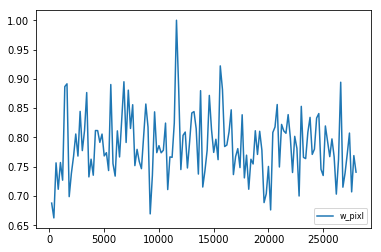

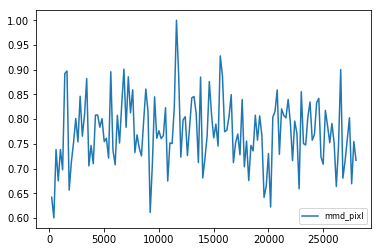

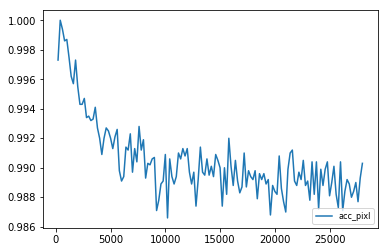

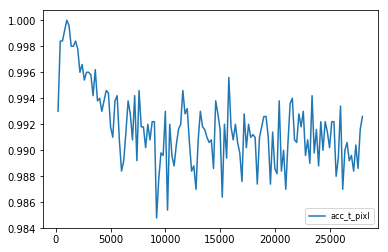

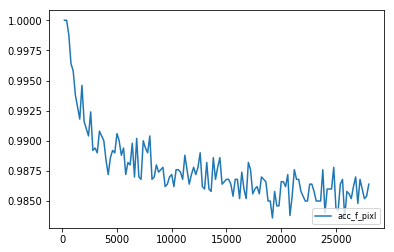

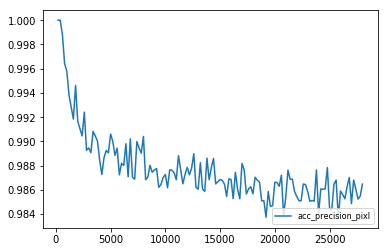

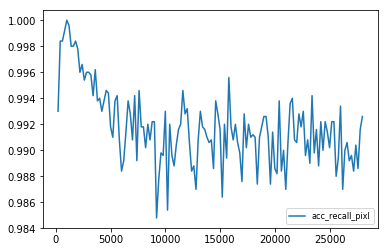

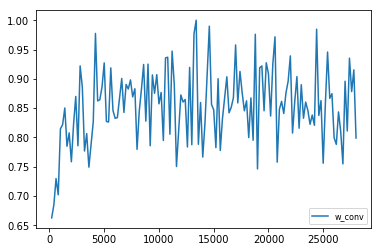

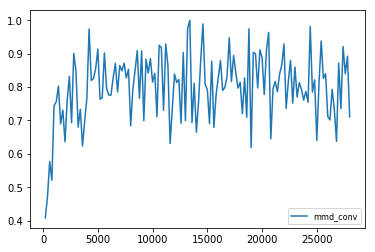

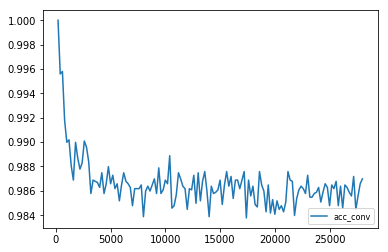

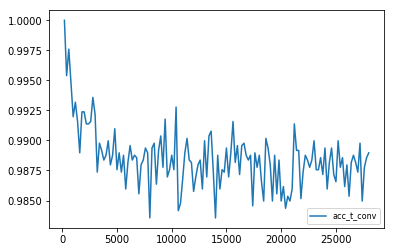

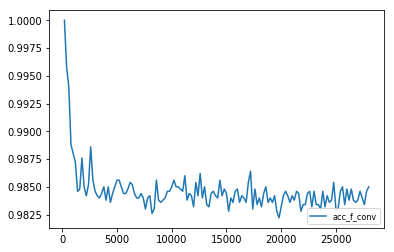

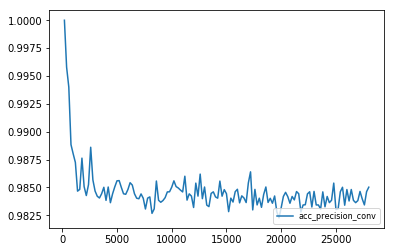

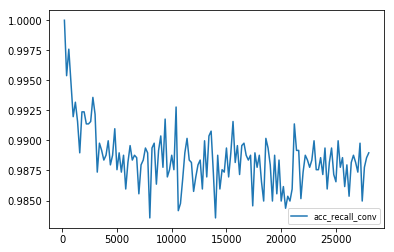

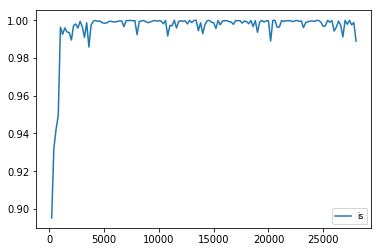

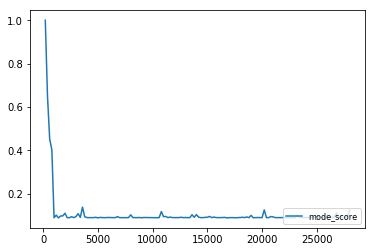

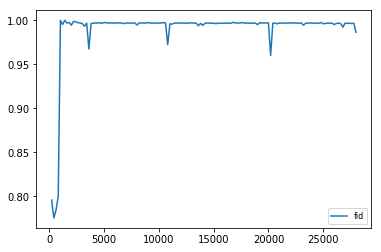

In [5]:

if not os.path.isdir('saved_models_{}'.format('acgan')):
    os.mkdir('saved_models_{}'.format('acgan'))
f = open('saved_models_{}/log_collapse1.txt'.format('acgan'), mode='w')

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import os
import numpy as np
import torch.utils.data as Data
class ACGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100
        self.x = []
        self.y = np.zeros((31, 1), dtype=np.int)
        self.y = list(self.y)
        for i in range(31):
            self.y[i] = []

        optimizer = Adam(0.0002, 0.5)
        losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=losses,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid, target_label = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model([noise, label], [valid, target_label])
        self.combined.compile(loss=losses,
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(self.channels, kernel_size=3, padding='same'))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, 100)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.summary()

        img = Input(shape=self.img_shape)

        # Extract feature representation
        features = model(img)

        # Determine validity and label of the image
        validity = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes, activation="softmax")(features)

        return Model(img, [validity, label])

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (X_test, _) = mnist.load_data()

        # Configure inputs
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)
        # Rescale -1 to 1
        X_test = (X_test.astype(np.float32) - 127.5) / 127.5
        # X_test = X_test / 127.5 - 1.
        X_test = np.expand_dims(X_test, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        nb_batches = int(X_train.shape[0] / batch_size)
        global_step = 0

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            # idx = np.random.randint(0, X_train.shape[0], batch_size)
            for index in range(nb_batches):
                global_step += 1
                # progress_bar.update(index)

                # get a batch of real images
                image_batch = X_train[index * batch_size:(index + 1) * batch_size]
                # Image labels. 0-9
                img_labels = y_train[index * batch_size:(index + 1) * batch_size]
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # The labels of the digits that the generator tries to create an
                # image representation of
                sampled_labels = np.random.randint(0, 10, (batch_size, 1))

                # Generate a half batch of new images
                gen_imgs = self.generator.predict([noise, sampled_labels])

                # Train the discriminator
                d_loss_real = self.discriminator.train_on_batch(image_batch, [valid, img_labels])
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, sampled_labels])
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # ---------------------
                #  Train Generator
                # ---------------------

                # Train the generator
                g_loss = self.combined.train_on_batch([noise, sampled_labels], [valid, sampled_labels])

                # Plot the progress
                print("epoch:%d step:%d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (
                    epoch, global_step, d_loss[0], 100 * d_loss[3], 100 * d_loss[4], g_loss[0]))

                sampleSize = 5000
                # If at save interval => save generated image samples
                if global_step % sample_interval == 0:
                    s = self.metrics(global_step, X_test, sampleSize)
        for i in range(len(s)):
            self.y[i] = [float(j) / max(self.y[i]) for j in self.y[i]]#对值进行归一化处理

        for i in range(len(s)):
            font1={'size':8}

            plt.plot(self.x, self.y[i], label=labels_name[i])
            plt.legend(loc='lower right',prop=font1)
            plt.savefig('saved_models_acgan/{}.png'.format(labels_name[i]))
            plt.show()
            plt.close()

    def metrics(self, epoch, X_test, sampleSize):
        self.x.append(epoch)
        r, c = 10, sampleSize//10
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.array([num for _ in range(r) for num in range(c)])
        gen_imgs = self.generator.predict([noise, sampled_labels])
        x_dataset = MyDataset(X_test[:sampleSize])
        # print(x_dataset[0].shape)
        x_real_loader = Data.DataLoader(dataset=x_dataset, batch_size=sampleSize, shuffle=True)
        x_fake_dataset = MyDataset(gen_imgs)
        x_fake_loader = Data.DataLoader(dataset=x_fake_dataset, batch_size=sampleSize, shuffle=True)
        s = compute_score_raw(x_real_loader, x_fake_loader, 256, '/real/', './fake', conv_model='tfgan',
                              workers=int(1))
        real_images = tf.convert_to_tensor(X_test)  # real images
        # MNIST_CLASSIFIER_FROZEN_GRAPH = '.\classify_mnist_graph_def.pb'
        gen_imgs = np.array(gen_imgs)
        eval_images = tf.convert_to_tensor(gen_imgs)
        eval_score = utils.mnist_score(eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH)  # IS score
        frechet_distance = utils.mnist_frechet_distance(real_images, eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH)
        mnist_score, f_distance = sess.run([eval_score, frechet_distance])
        # # print(mnist_score)
        # # print(f_distance)
        # # s[14]=mnist_score
        # # s[16]=f_distance
        s[17]=mnist_score
        s[18]=f_distance
        print('IS socre: %f' % mnist_score)
        print('FID: %f' % f_distance)

        for i in range(len(s)):
            print(i, "=", s[i])
        for i in range(len(s)):
            self.y[i].append(s[i])
        f.writelines('\n')
        f.writelines('epoch:' + str(epoch))
        f.writelines('\n')
        f.writelines('%.8f'%(i) for i in s)
        f.writelines('\n')
        return s


if __name__ == '__main__':
    acgan = ACGAN()
    acgan.train(epochs=20, batch_size=64, sample_interval=200)
